In [2]:
from __future__ import print_function

import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)



import tensorflow.keras as keras
from keras.datasets import mnist
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten,TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow.keras import layers,models
import h5py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import heapq
import warnings
warnings.filterwarnings('ignore')


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16096015806653538886
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6647417647964077193
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2137122372781096307
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5297864704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18072805287392371943
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


Using TensorFlow backend.


In [3]:

batch_size = 10
num_classes = 2
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets

#(x_train, y_train), (x_test, y_test) = mnist.load_data()


p='mnist_10instance_2.hdf5';

db=h5py.File(p);


X, y = db['images'],db['labels'];


# Split train and valid

i = int(db["images"].shape[0] * 1/3)

x_train, x_test, y_train, y_test = X[:i],X[i:],y[:i],y[i:];

print(x_train.shape)



class ScaleLayer(Layer):

    def __init__(self,scale, **kwargs):

        self.scale=scale;
        
        super(ScaleLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        super(ScaleLayer, self).build(input_shape)

       
    def call(self, inputs):

        output=tf.image.resize(inputs,[self.scale,self.scale],method=tf.image.ResizeMethod.BICUBIC)


        output = tf.keras.backend.concatenate((output, output,output),axis=-1) 

        print(output.shape)

        return output

       

    def compute_output_shape(self, input_shape):
        return (input_shape[0],self.scale,self.scale,3)





classes = 1;
pooling = 'No'
num_sequence = 10;
include_top = False;

input_shape =  [num_sequence,img_rows, img_cols, 1];


img_input = layers.Input(shape=input_shape)

x = TimeDistributed(ScaleLayer(224))(img_input)

x = TimeDistributed(layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1'))(x)
x = TimeDistributed(layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2'))(x)
x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))(x)

# Block 2
x = TimeDistributed(layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1'))(x)
x = TimeDistributed(layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2'))(x)
x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))(x)

# Block 3
x = TimeDistributed(layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1'))(x)
x = TimeDistributed(layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2'))(x)
x = TimeDistributed(layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv3'))(x)
x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))(x)

# Block 4
x = TimeDistributed(layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv1'))(x)
x = TimeDistributed(layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv2'))(x)
x = TimeDistributed(layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv3'))(x)
x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))(x)

# Block 5
x = TimeDistributed(layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv1'))(x)
x = TimeDistributed(layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv2'))(x)
x = TimeDistributed(layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv3'))(x)
x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))(x)

if include_top:
    # Classification block
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)
else:
    if pooling == 'avg':
        x = layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
        x = layers.GlobalMaxPooling2D()(x)
    elif pooling =='No':
        x = x;

# Ensure that the model takes into account
# any potential predecessors of `input_tensor`.
#if input_tensor is not None:
#    inputs = keras_utils.get_source_inputs(input_tensor)
#else:
inputs = img_input
# Create model.
base_model = models.Model(inputs, x, name='vgg16')

weights ='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5';

base_model.load_weights(weights)

class AttentionLayer(Layer):

    def __init__(self, **kwargs):

        
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)


        self.input_shape_r = input_shape;
        print('self.input_shape_r')
        print(self.input_shape_r)

        L_size = 256;

        self.w = self.add_weight(name='w', 
                              shape=[L_size,1],
                              initializer='uniform',
                              trainable=True)
        self.V = self.add_weight(name='V', 
                      shape=[input_shape[2],L_size],
                      initializer='uniform',
                      trainable=True)

        self.U = self.add_weight(name='U', 
                      shape=[input_shape[2],L_size],
                      initializer='uniform',
                      trainable=True)

        

        self.bias_w = self.add_weight(shape=[1,1],
                              initializer='uniform',
                              name='bias_w')
        self.bias_V = self.add_weight(shape=[1,L_size],
                                      initializer='uniform',
                                      name='bias_V')
        self.bias_U = self.add_weight(shape=[1,L_size],
                                      initializer='uniform',
                                      name='bias_U')
      

  
       
    def call(self, inputs):


        inputs_r = K.expand_dims(inputs,axis=-2)


        print('inputs')
        print(inputs_r.shape)


        dot_products_V = K.dot(inputs_r,self.V)
        dot_products_U = K.dot(inputs_r,self.U)

        dot_products_V += self.bias_V;
        dot_products_U += self.bias_U;


        print('dot product')
        print(dot_products_V.shape)

        tanh_V = K.tanh(dot_products_V);
        sigmoid_U = K.sigmoid(dot_products_U);

        print('tanh')
        print(tanh_V.shape)

        comb_UV = tanh_V*sigmoid_U;

        print('combUV')
        print(comb_UV.shape)

        attention_weights = K.dot(comb_UV,self.w);

        attention_weights +=self.bias_w;

        attention_weights = K.exp(attention_weights);


        print('attention_weights')
        print(attention_weights.shape)


        attention_weights /= K.cast(K.sum(attention_weights,
                                  axis=1,
                                  keepdims=True) + K.epsilon(),
                            K.floatx());
        print('attention_weights sum')
        print(attention_weights.shape)

        #attention_weights = K.expand_dims(attention_weights);
        attention_weights= K.squeeze(attention_weights,axis = -1);
        print('attention_weights last')
        print(attention_weights.shape)

        weighted_output = inputs * attention_weights;

        self.Save =  attention_weights;


        output = K.sum(weighted_output, axis=1)

        print('output')
        print(output.shape)

        return output


       

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[2])

    def get_config(self):
        base_config = super(AttentionLayer, self).get_config()
        base_config['w'] = self.w
        base_config['V'] = self.V
        base_config['U'] = self.U
        base_config['bias_w'] = self.bias_w
        base_config['bias_V'] = self.bias_V
        base_config['bias_U'] = self.bias_U
        return base_config





class FCHeadNet:
  @staticmethod
  def build(baseModel, classes, D):
    # initialize the head model that will be placed on top of
    # the base, then add a FC layer
    headModel = baseModel.output
    headModel = TimeDistributed(layers.Flatten(name='flatten'))(headModel)
    headModel = TimeDistributed(layers.Dense(D, activation='relu', name='fc1'))(headModel)
    headModel = TimeDistributed(layers.Dense(D, activation='relu', name='fc2'))(headModel)
    headModel = AttentionLayer(name='attentionlayer')(headModel)
    headModel = layers.Dense(classes, activation='sigmoid', name='predictions')(headModel)
    # add a softmax layer
    #headModel = layers.Dense(classes, activation="softmax")(headModel)
    #headModel = layers.Dense(classes, activation='softmax', name='predictions2')(headModel)

    # return the model
    return headModel


head_model = FCHeadNet.build(base_model, 1, 256)

model = Model(inputs=base_model.input, outputs=head_model)

Dont_Want_to_train_all = True;


if (Dont_Want_to_train_all):

  for layer in base_model.layers:
    layer.trainable = False





(500, 10, 28, 28, 1)
(None, 224, 224, 3)
self.input_shape_r
(None, 10, 256)
inputs
(None, 10, 1, 256)
dot product
(None, 10, 1, 256)
tanh
(None, 10, 1, 256)
combUV
(None, 10, 1, 256)
attention_weights
(None, 10, 1, 1)
attention_weights sum
(None, 10, 1, 1)
attention_weights last
(None, 10, 1)
output
(None, 256)


In [4]:
save_dir = "./"


weights_dir = save_dir + "weights_test.h5"

In [5]:
model_dir_current = weights_dir


model.load_weights(model_dir_current)


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 28, 28, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 224, 224, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 224, 224, 64)  1792      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 224, 224, 64)  36928     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 112, 112, 64)  0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 112, 112, 128) 73856     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 112, 112, 128) 147584

In [7]:
attention_weight = model.layers[23].get_weights();
attention_weight= np.array(attention_weight);
print(attention_weight[5].shape)

(1, 256)


In [8]:
print(x_train.shape)

(500, 10, 28, 28, 1)


In [9]:
x_train_test = x_train[4];
x_train_test = x_train_test[...,None];
x_train_test = x_train_test.reshape([1,10,28,28,1])
layer_name='time_distributed_21';
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train_test)

In [10]:
intermediate_output.shape

(1, 10, 256)

In [11]:
attention_weight = model.layers[23].get_weights();
attention_weight= np.array(attention_weight);
w = attention_weight[0];
V = attention_weight[1];
U = attention_weight[2];
bw = attention_weight[3];
bV = attention_weight[4];
bU = attention_weight[5];


In [12]:
out_V = np.tanh(np.dot(intermediate_output,V)+bV)
out_U = 1 / (1 + np.exp((np.dot(intermediate_output,U)+bU)))

combines = out_U*out_V

total = np.exp(np.dot(combines,w)+bw);


In [13]:
total

array([[[0.40814665],
        [0.40369233],
        [0.4628568 ],
        [2.7754824 ],
        [0.31866446],
        [3.35152   ],
        [0.38787946],
        [0.28444913],
        [0.7988554 ],
        [0.28058097]]], dtype=float32)

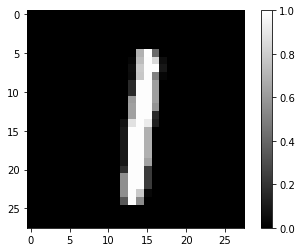

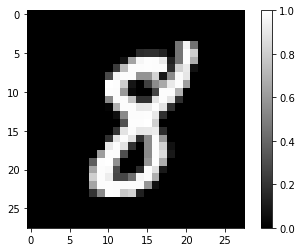

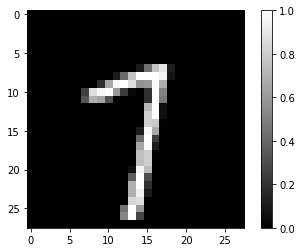

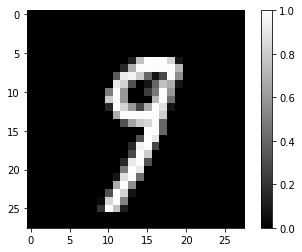

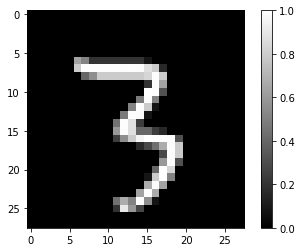

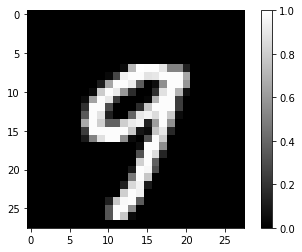

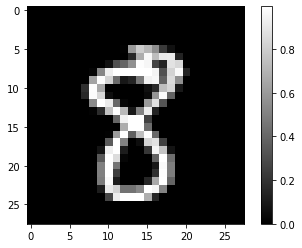

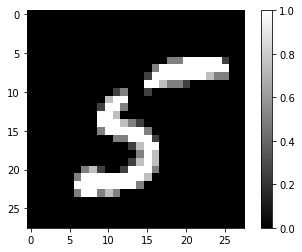

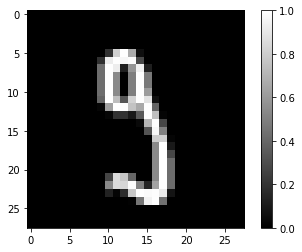

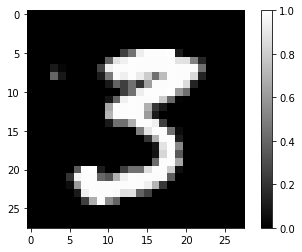

[1]


In [14]:
for xx in x_train[4]:
    xx = np.squeeze(xx)
    plt.imshow(xx, cmap='gray')
    plt.colorbar()
    plt.show()
print(y_train[4])

In [36]:
import cv2 

class GradCAM:
    def __init__(self, model, classIdx, layerName = None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        
        
        """
        
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            print(len(layer.output_shape))
            if len(layer.output_shape) == 5:
                print(layer.name)
                return layer.name
            
        """
        count = 0;
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            print(len(layer.output_shape))
            
            if len(layer.output_shape) == 5 and count ==1:
                print(layer.name)
                return layer.name
            
            if len(layer.output_shape) == 5:
                count = count+1;
            
            
            
            
            
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        from tensorflow.keras.models import Model
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients

        guidedGrads =  grads
        
        
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        castcam= tf.cast(cam > 0, "float32")
        
        cam = castcam * cam
        
        
        
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (s,w, h,c) = (image.shape[1],image.shape[2],image.shape[3],image.shape[4])
        print('*')
        print(w)
        print(h)
        print(cam.numpy().shape)
        #heatmap = cv2.resize(cam.numpy(), (w, h))
        
        # Force c to equal 3 for rbg
        
        #c = 3;
        
        heat_final = np.zeros((s,w,h,c))
        cam_seq = cam.numpy()
        for seq in range(s):
        
            heatmap =cv2.resize(cam_seq[seq,...], (w, h))
        
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
            
            heatmap = heatmap[...,None];
            #heatmap = np.concatenate([heatmap,heatmap,heatmap],axis=-1)
            # return the resulting heatmap to the calling function
            heat_final[seq,...] = heatmap
        
        return heat_final
    def overlay_heatmap(self, heatmap_seq, image_seq, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        
        (s,w,h,c) = heatmap_seq.shape;
        print('overlay final')
        print(str(s)+','+str(w)+','+str(h))
        heat_final = np.zeros((s,w,h,3))
        output_final = np.zeros((s,w,h,3))
        for seq in range(s):
            heatmap = heatmap_seq[seq,...];
            image = image_seq[0,seq,...];
            heatmap = heatmap.astype("uint8")
    
            image = (image * 255).astype("uint8")
            
            print('overlay')
            print(image.shape)
            print(heatmap.shape)
            heatmap = cv2.applyColorMap(heatmap, colormap)
            print(heatmap.shape)
            output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
            
            # return a 2-tuple of the color mapped heatmap and the output,
            # overlaid image
            heat_final[seq,...] = heatmap
            output_final[seq,...] = output
        return (heat_final, output_final)

2
2
3
3
3
5
5
time_distributed_17
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
inputs
(1, 10, 1, 256)
dot product
(1, 10, 1, 256)
tanh
(1, 10, 1, 256)
combUV
(1, 10, 1, 256)
attention_weights
(1, 10, 1, 1)
attention_weights sum
(1, 10, 1, 1)
attention_weights last
(1, 10, 1)
output
(1, 256)
*
28
28
(10, 14, 14)
254.0
overlay final
10,28,28
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)


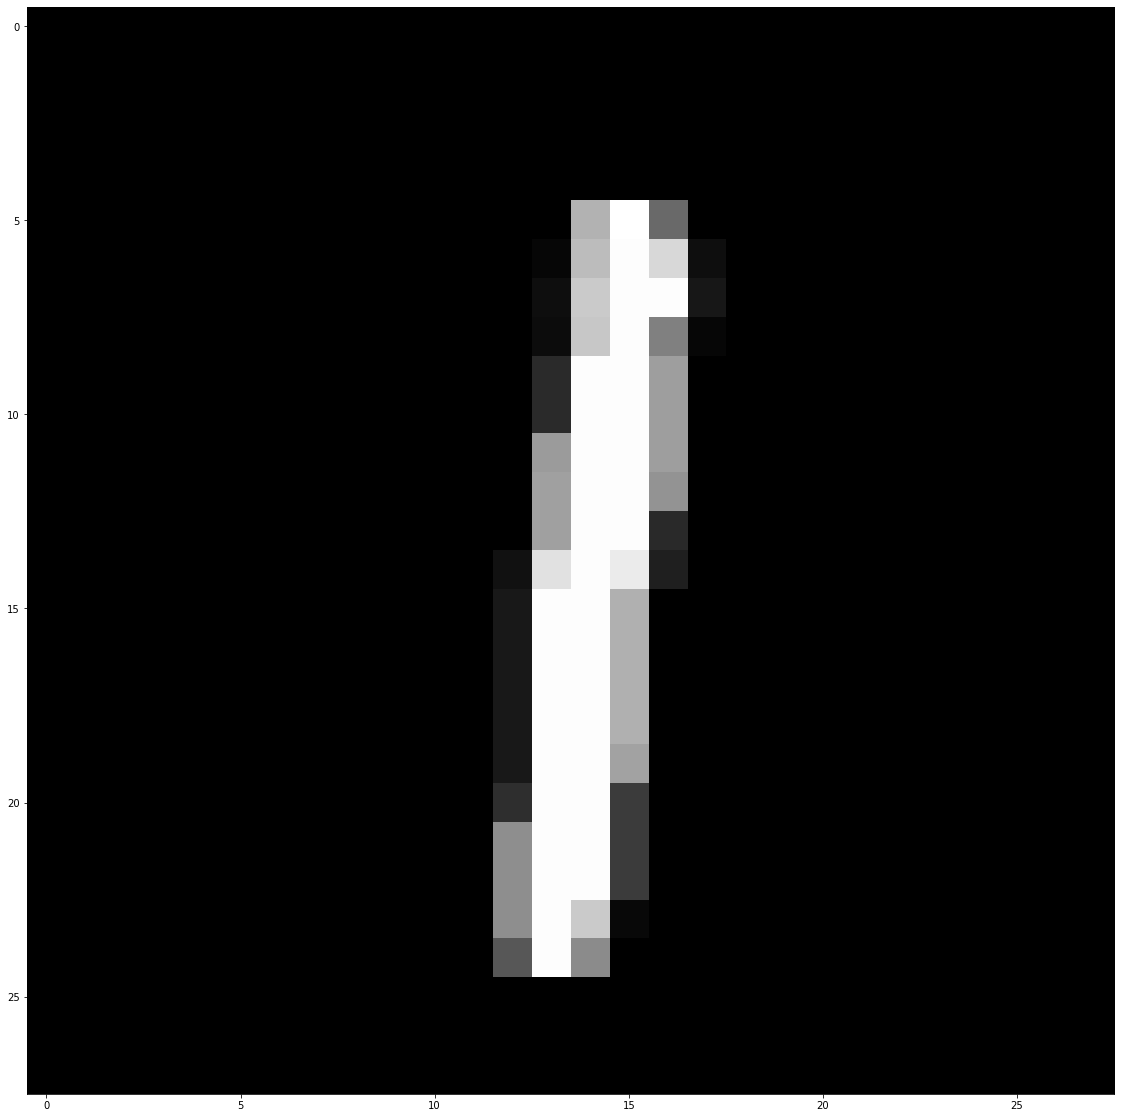

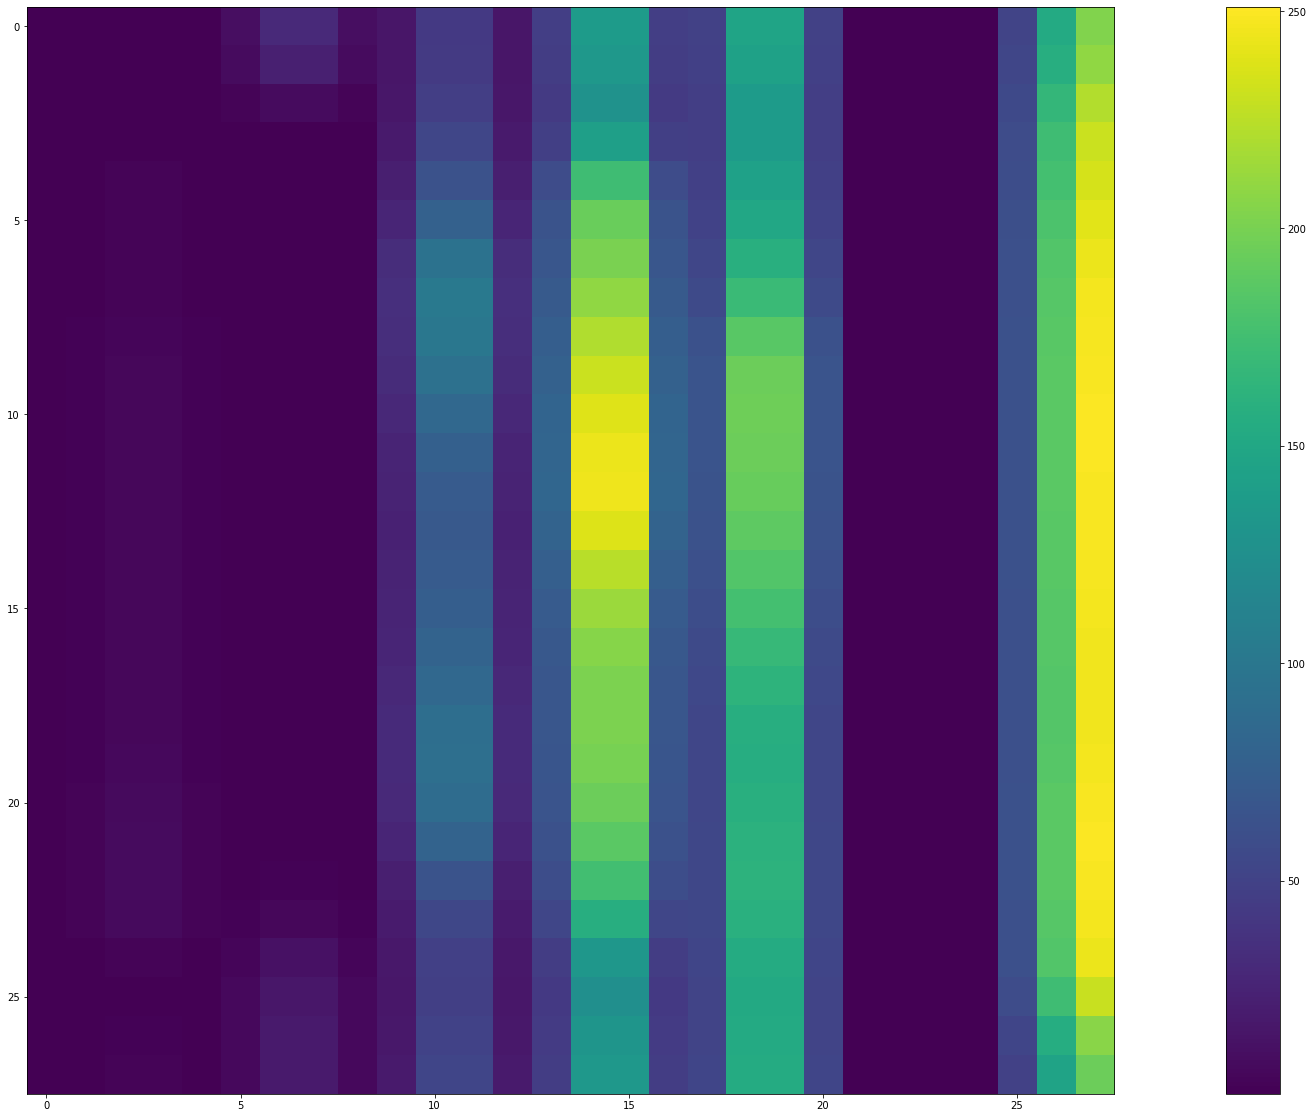

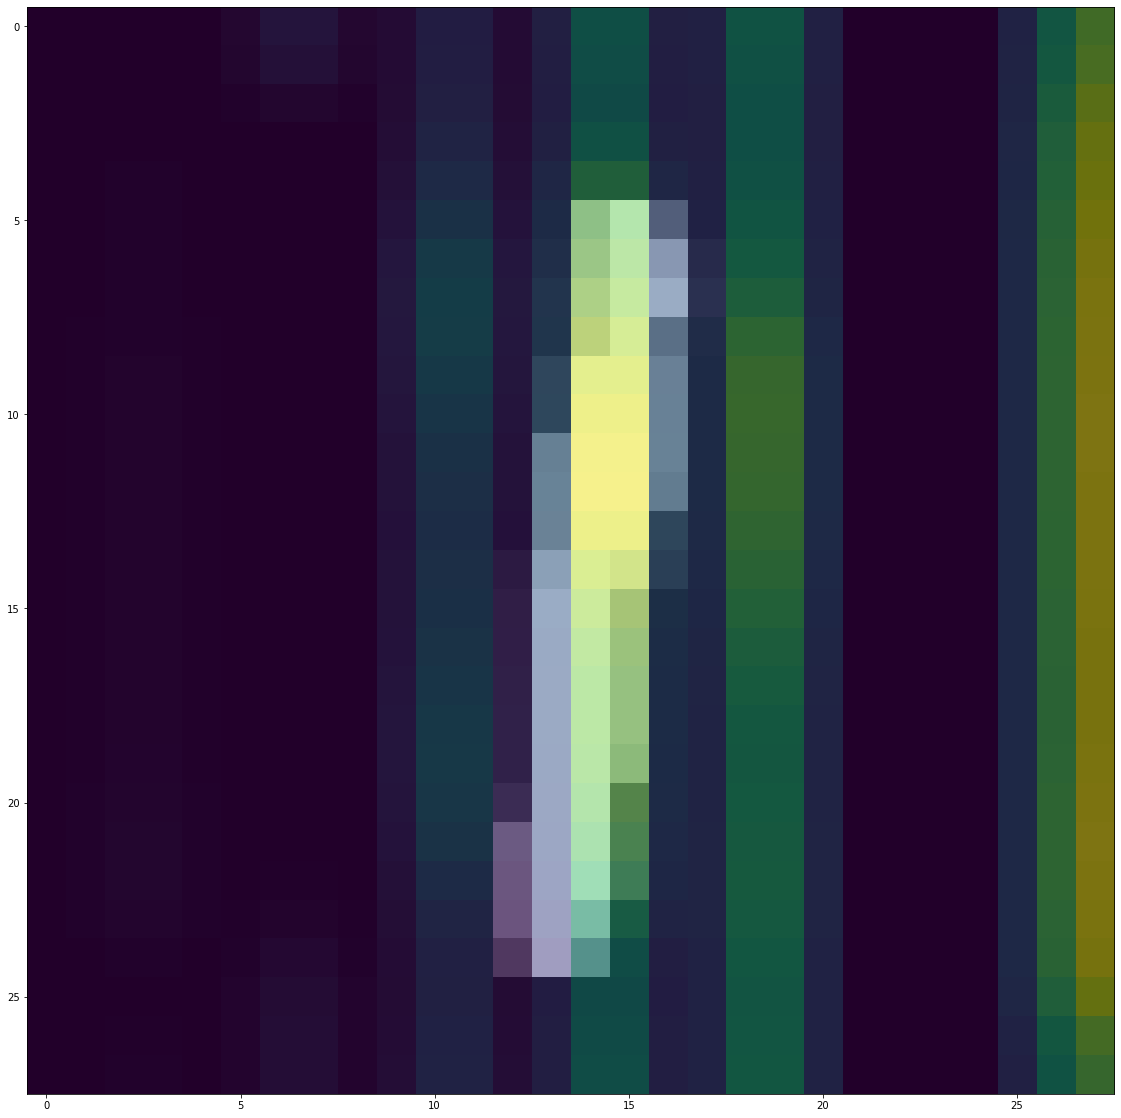

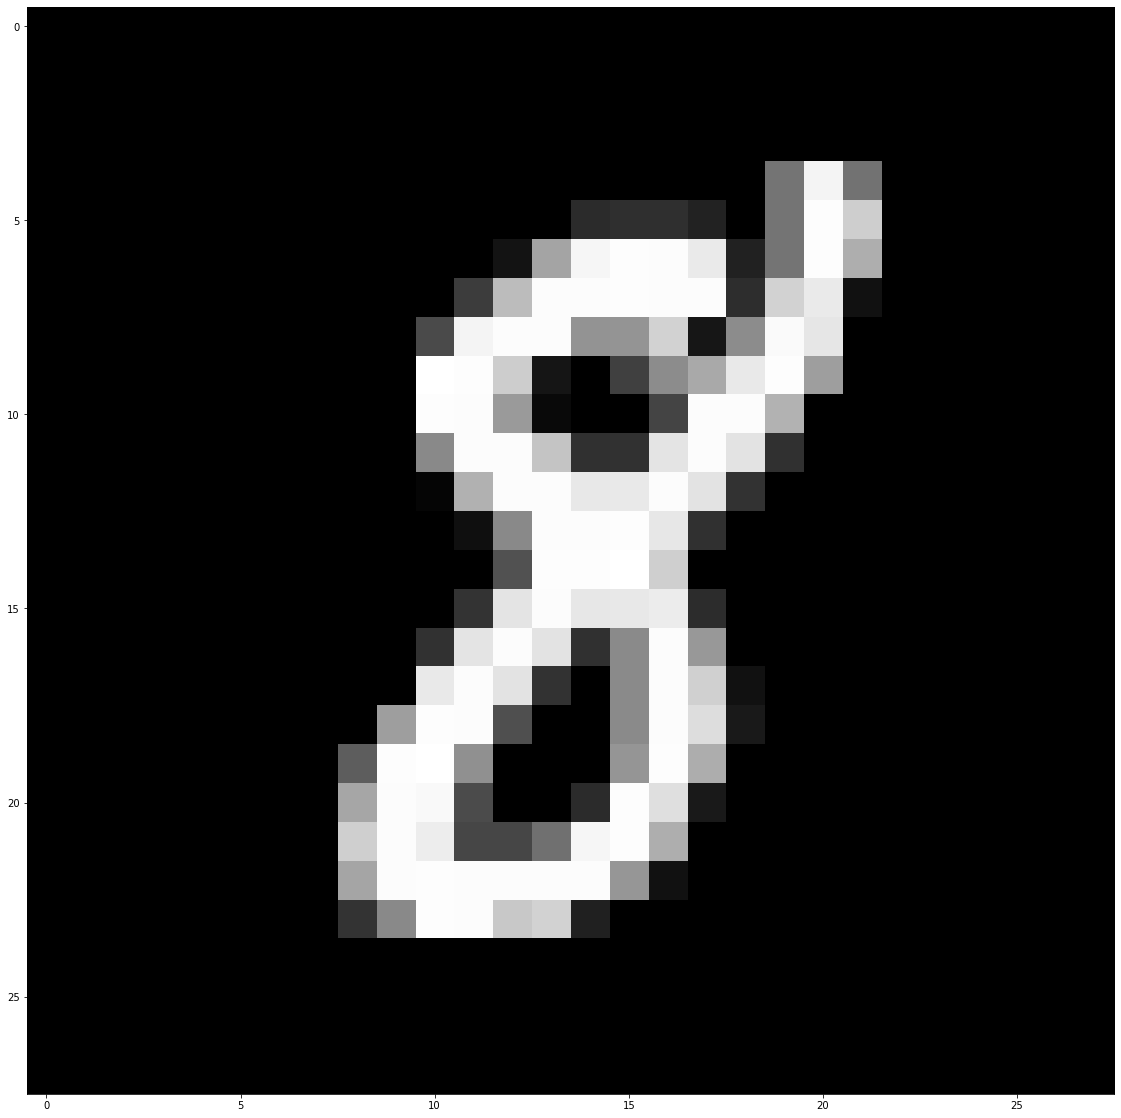

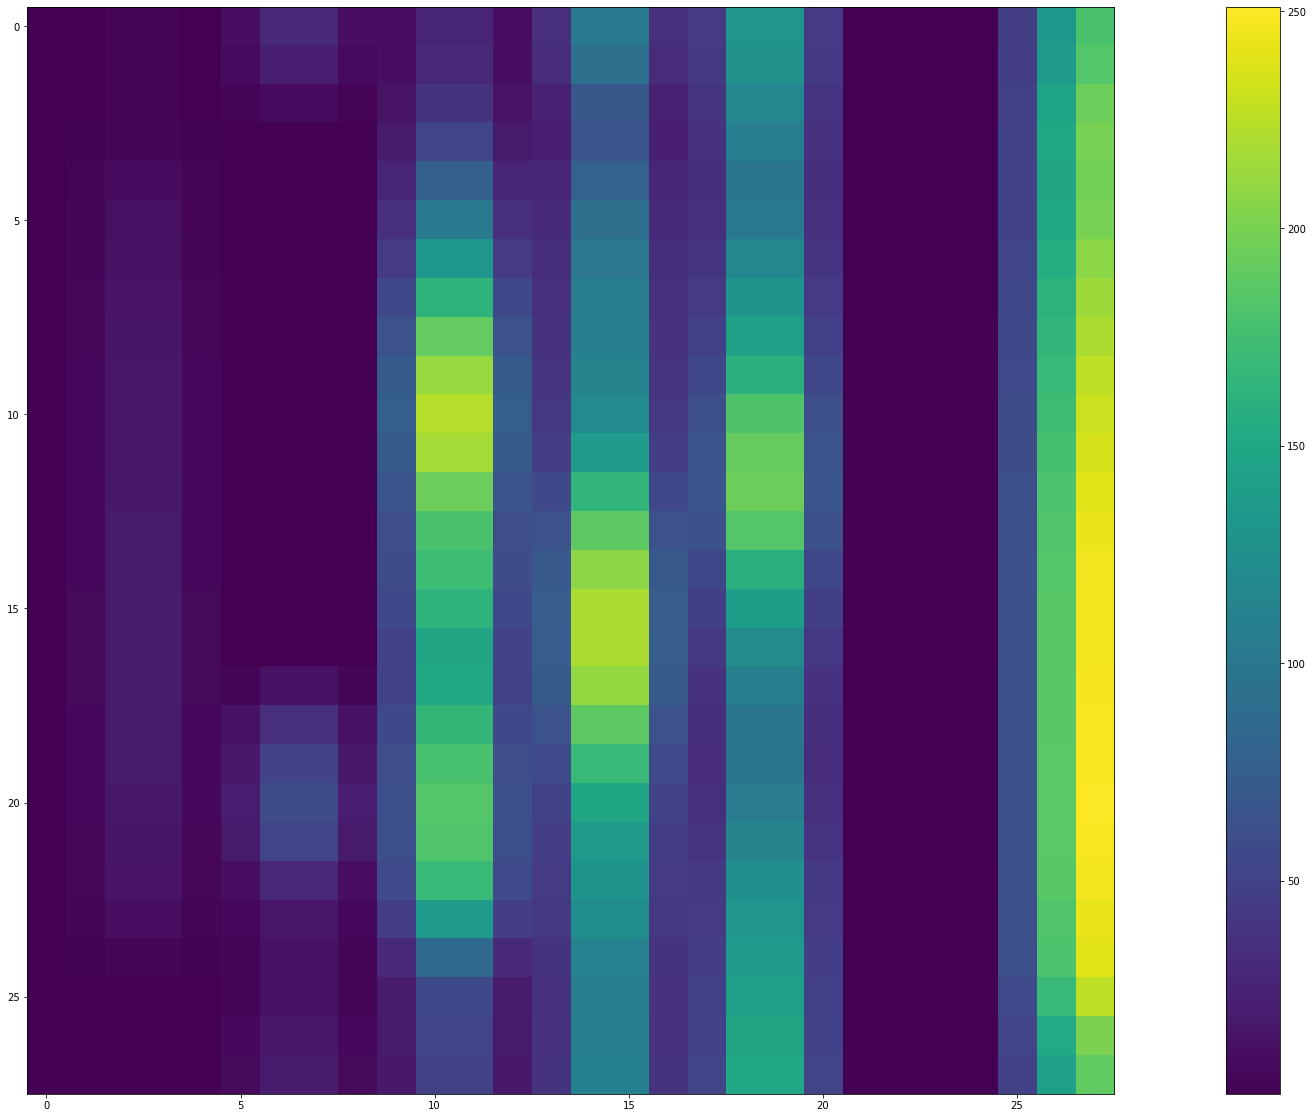

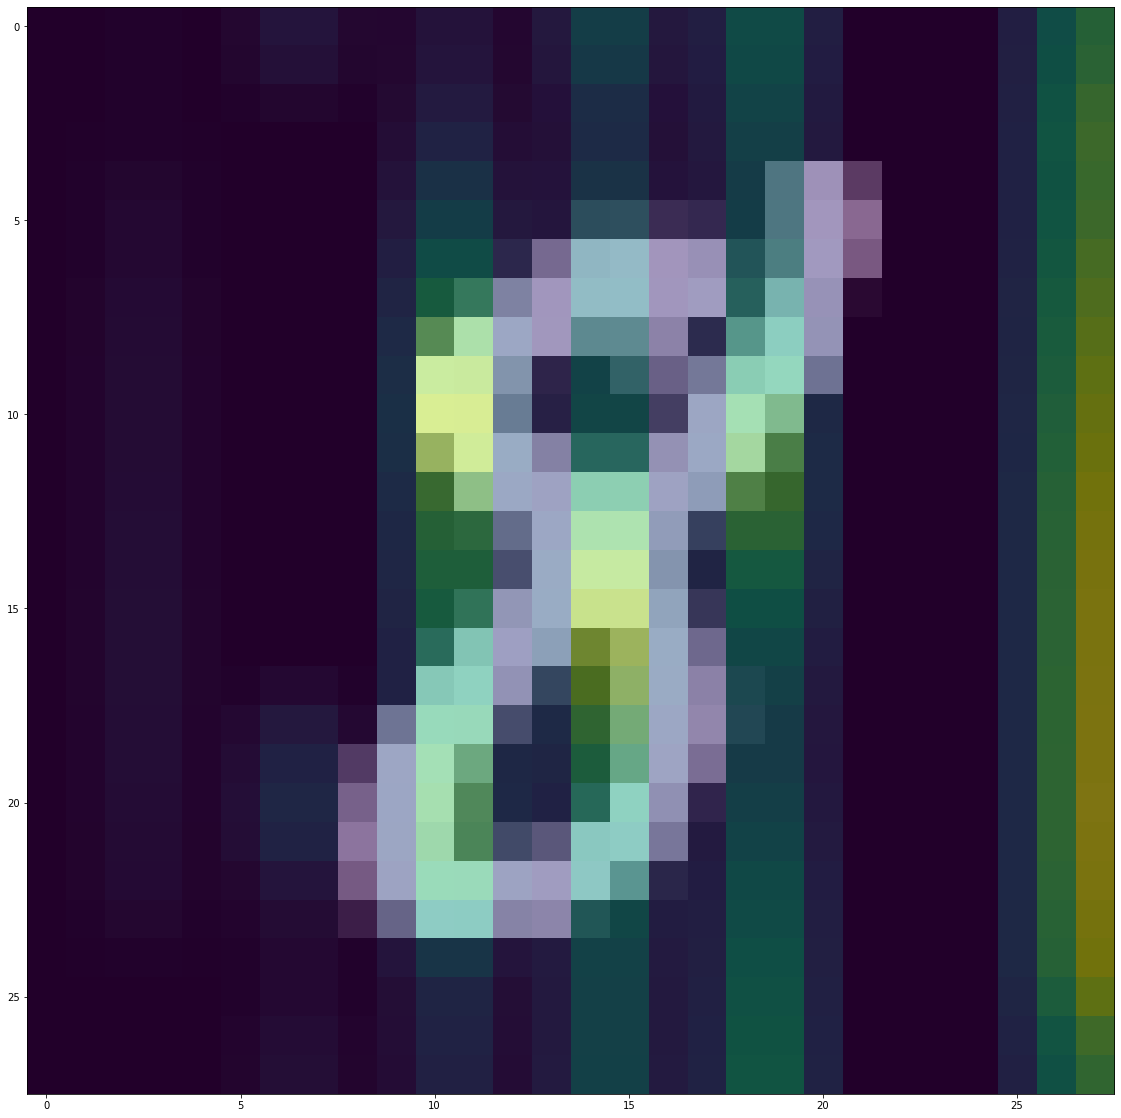

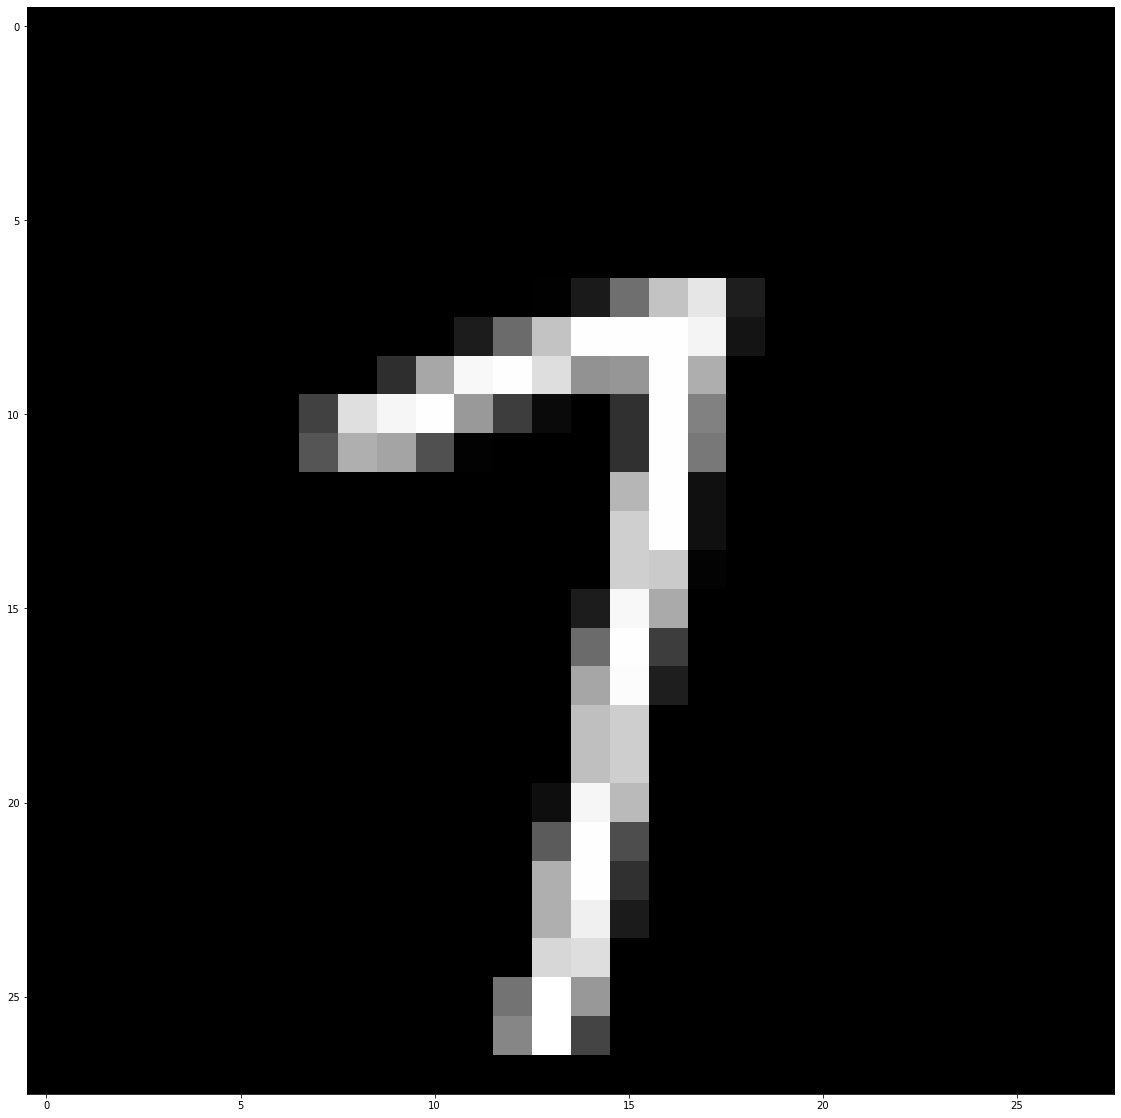

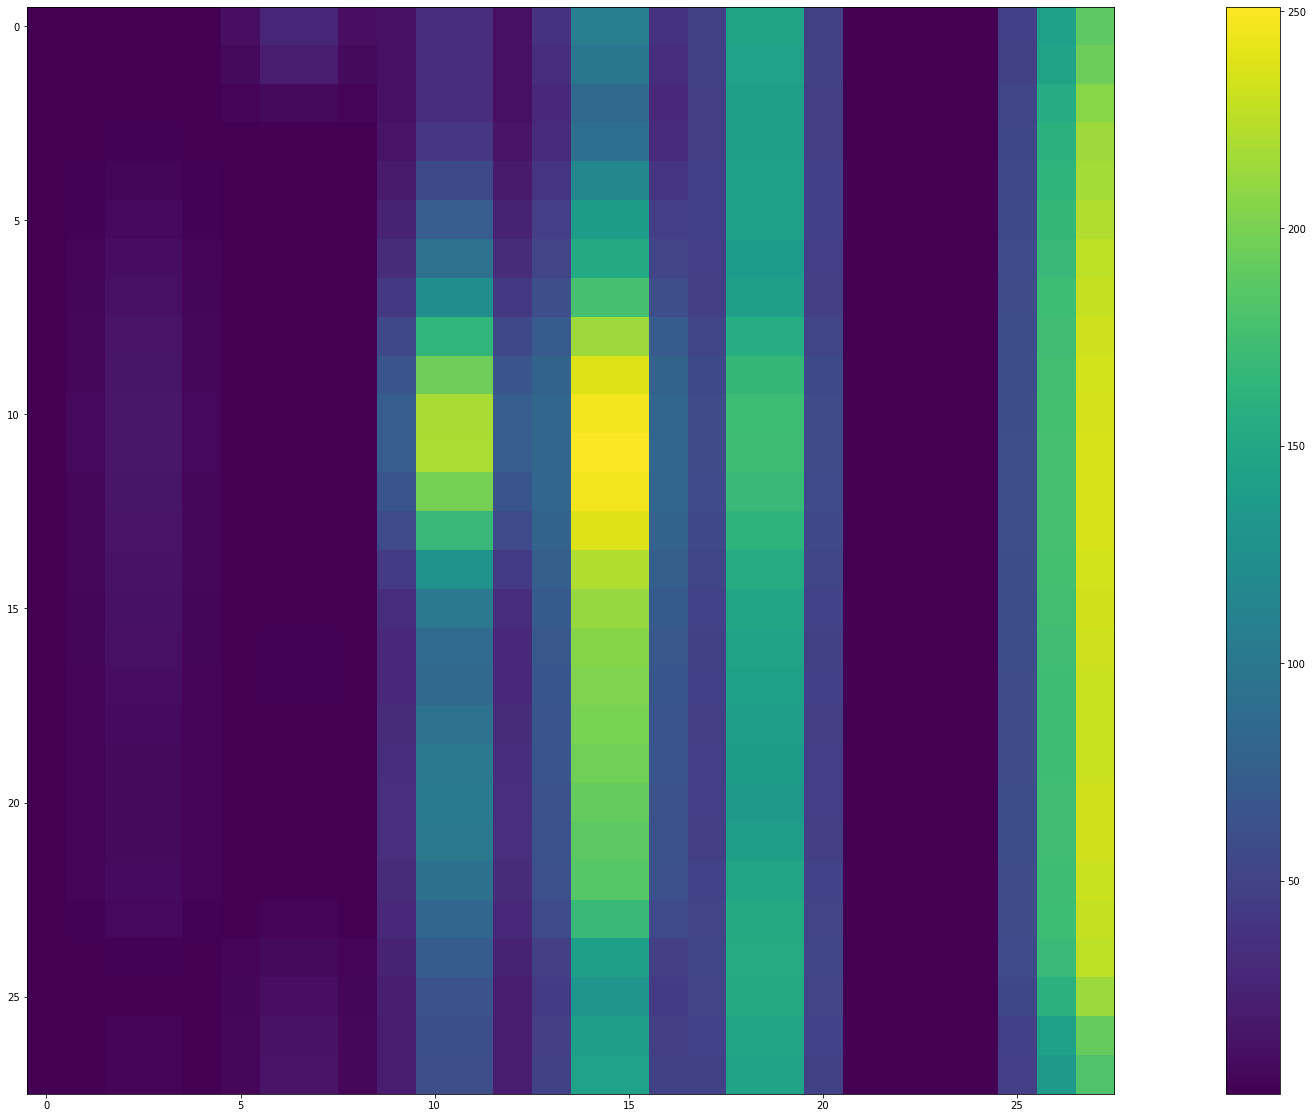

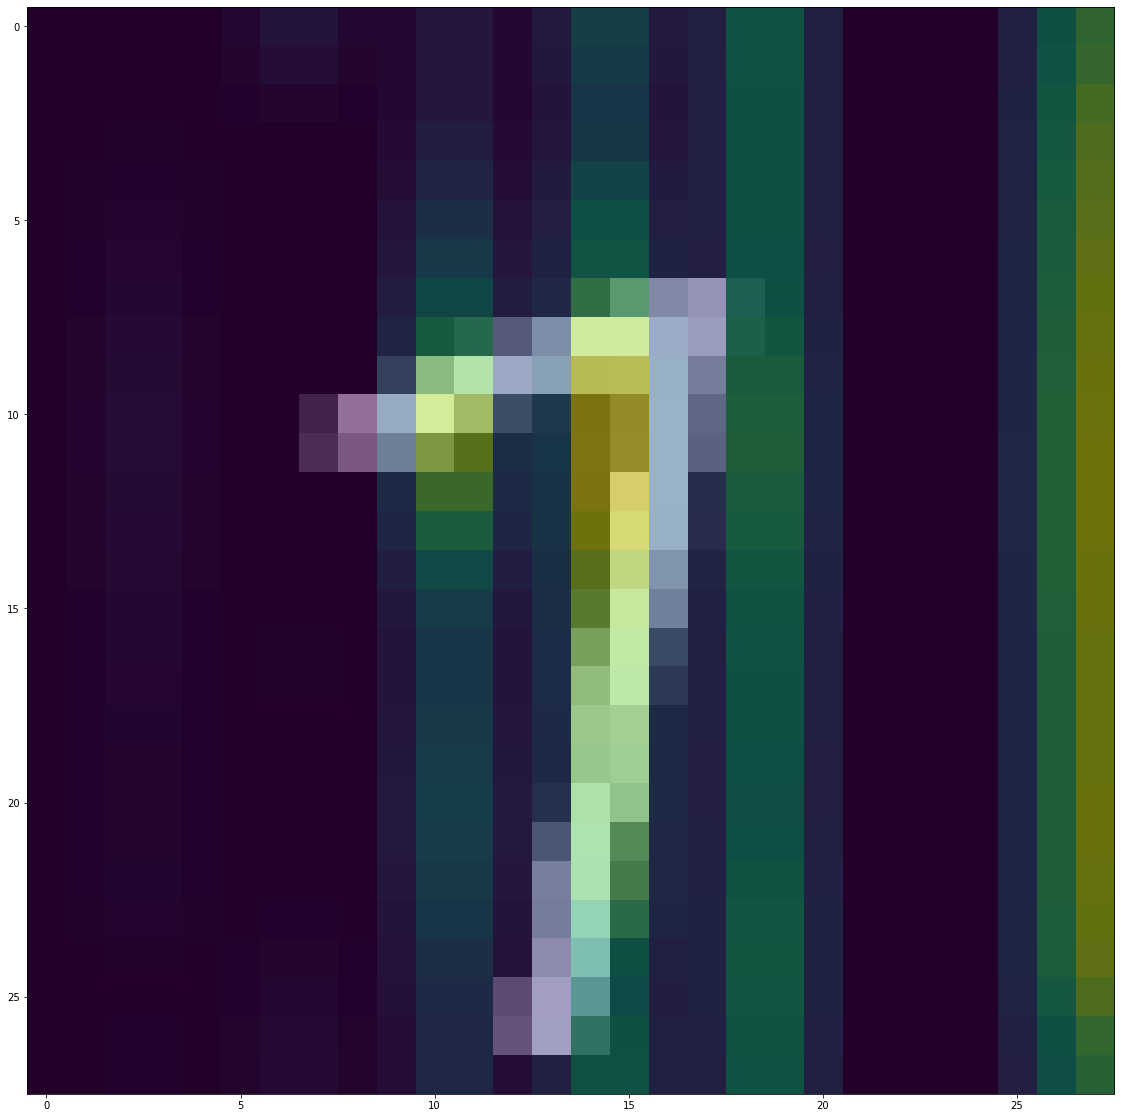

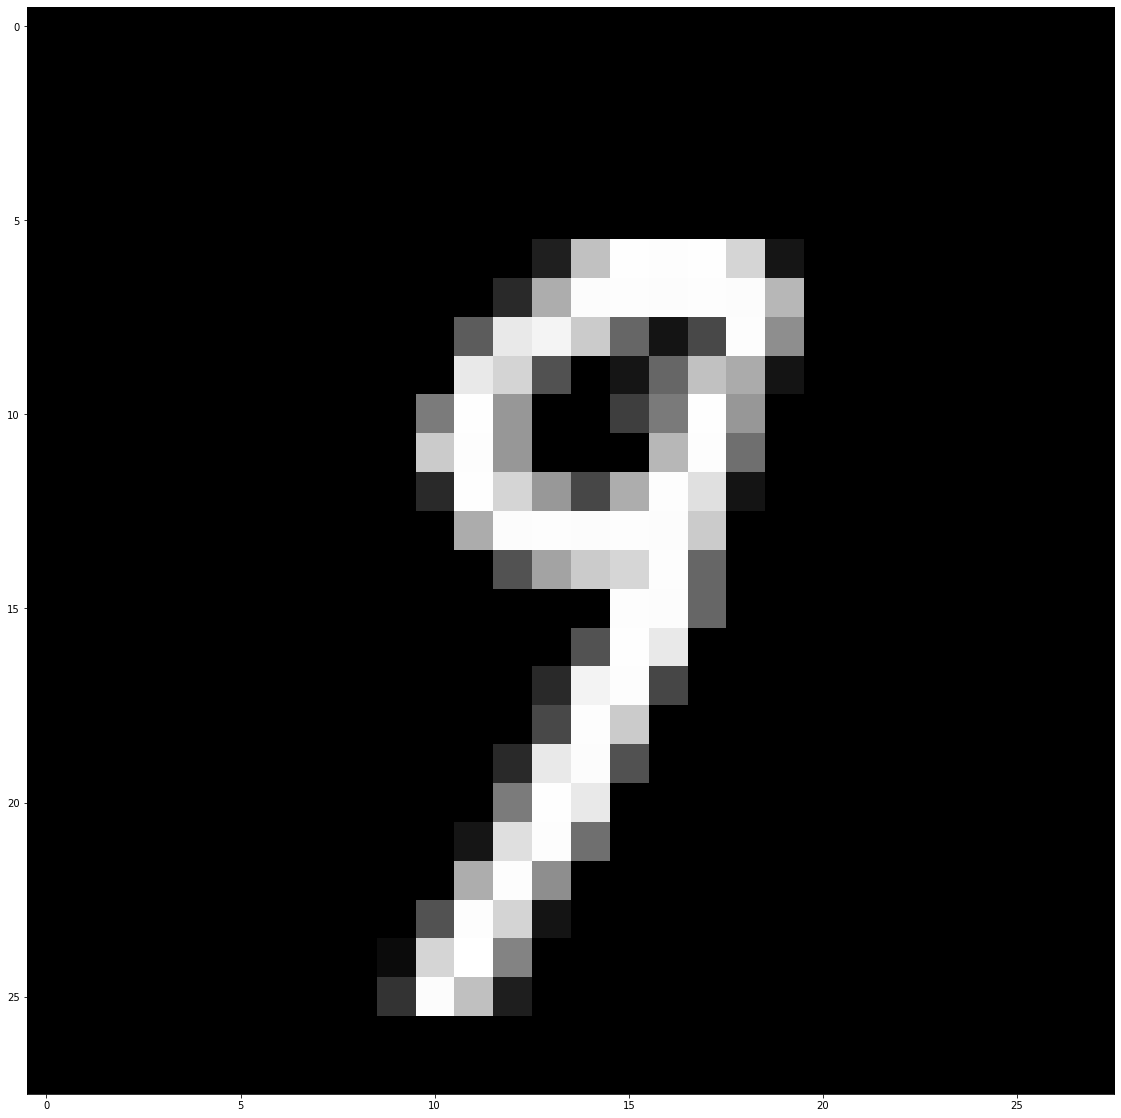

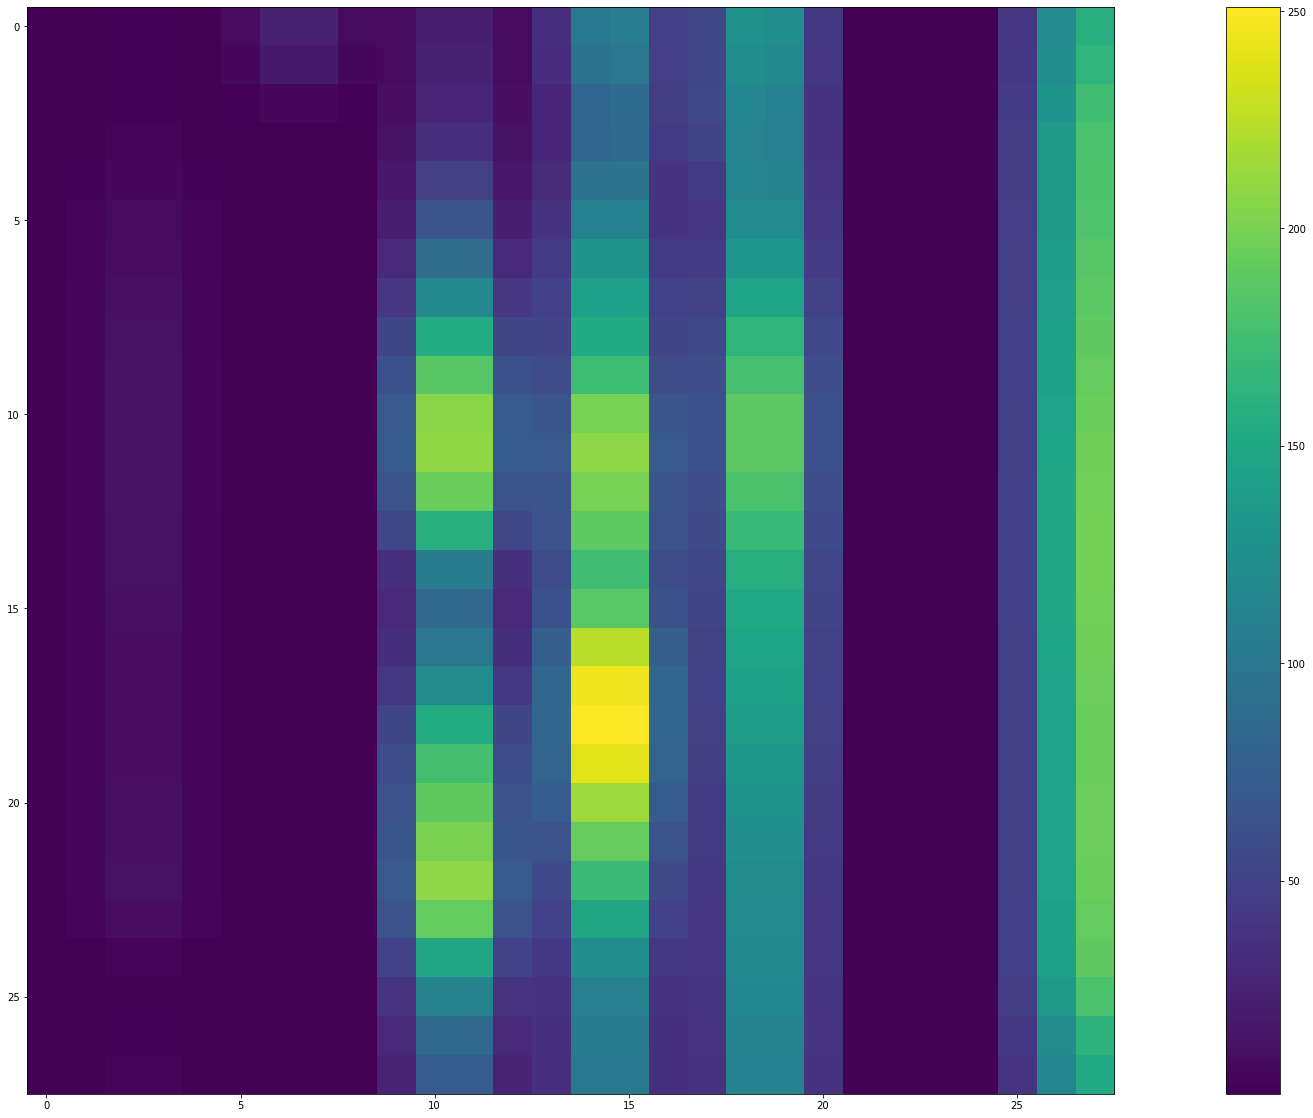

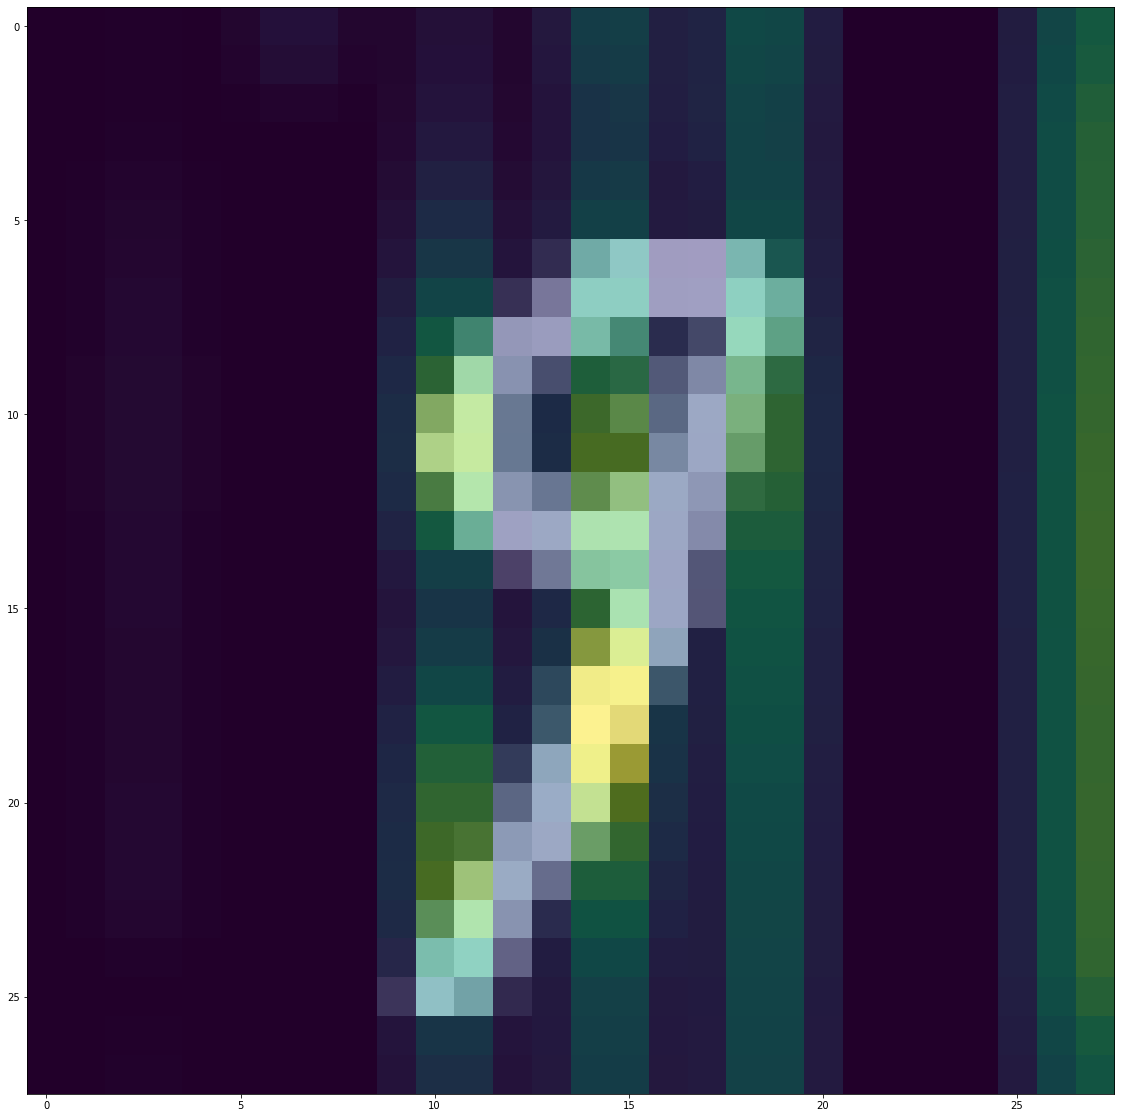

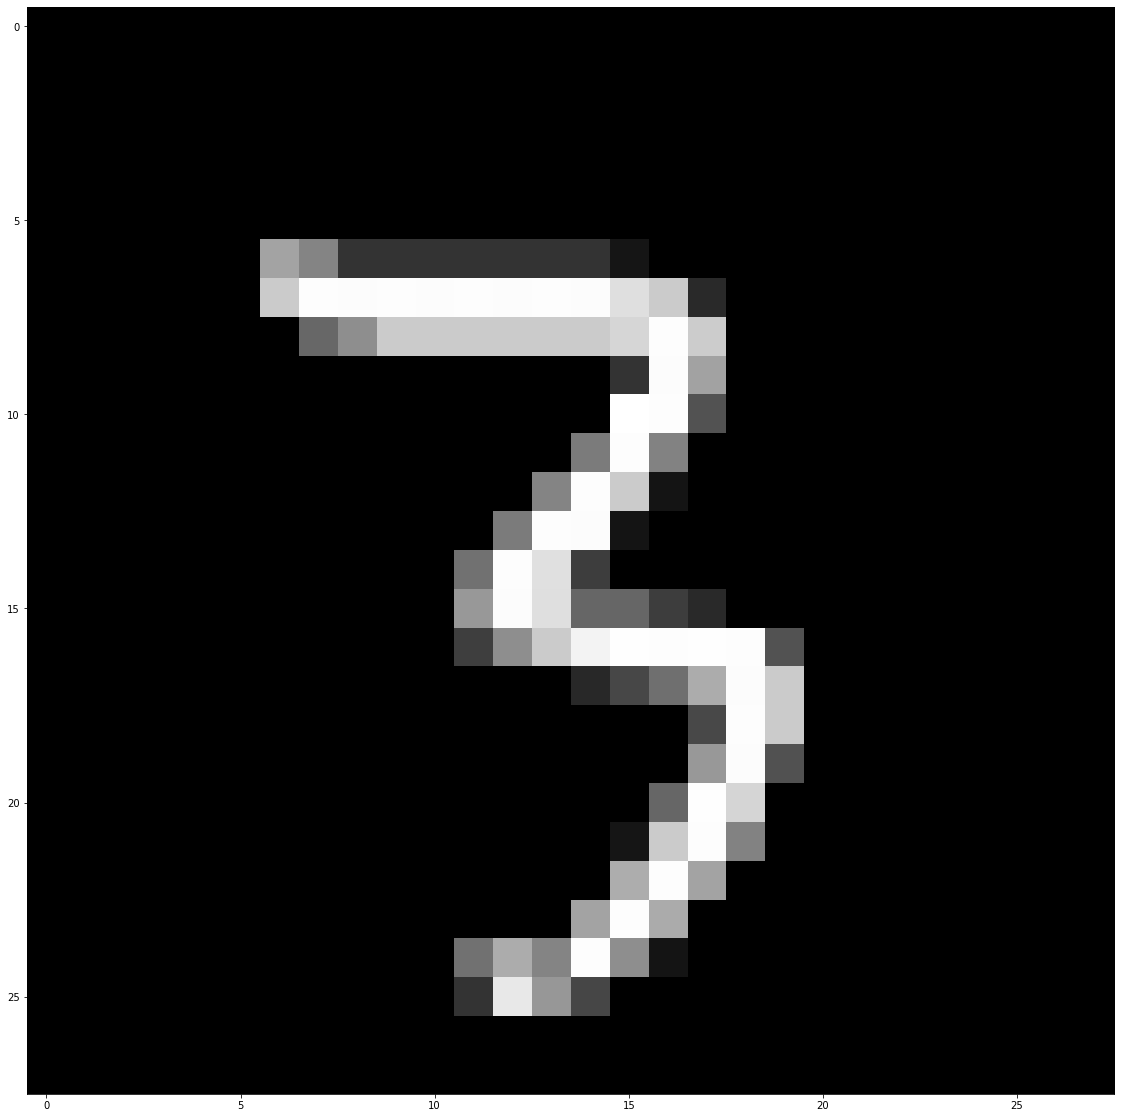

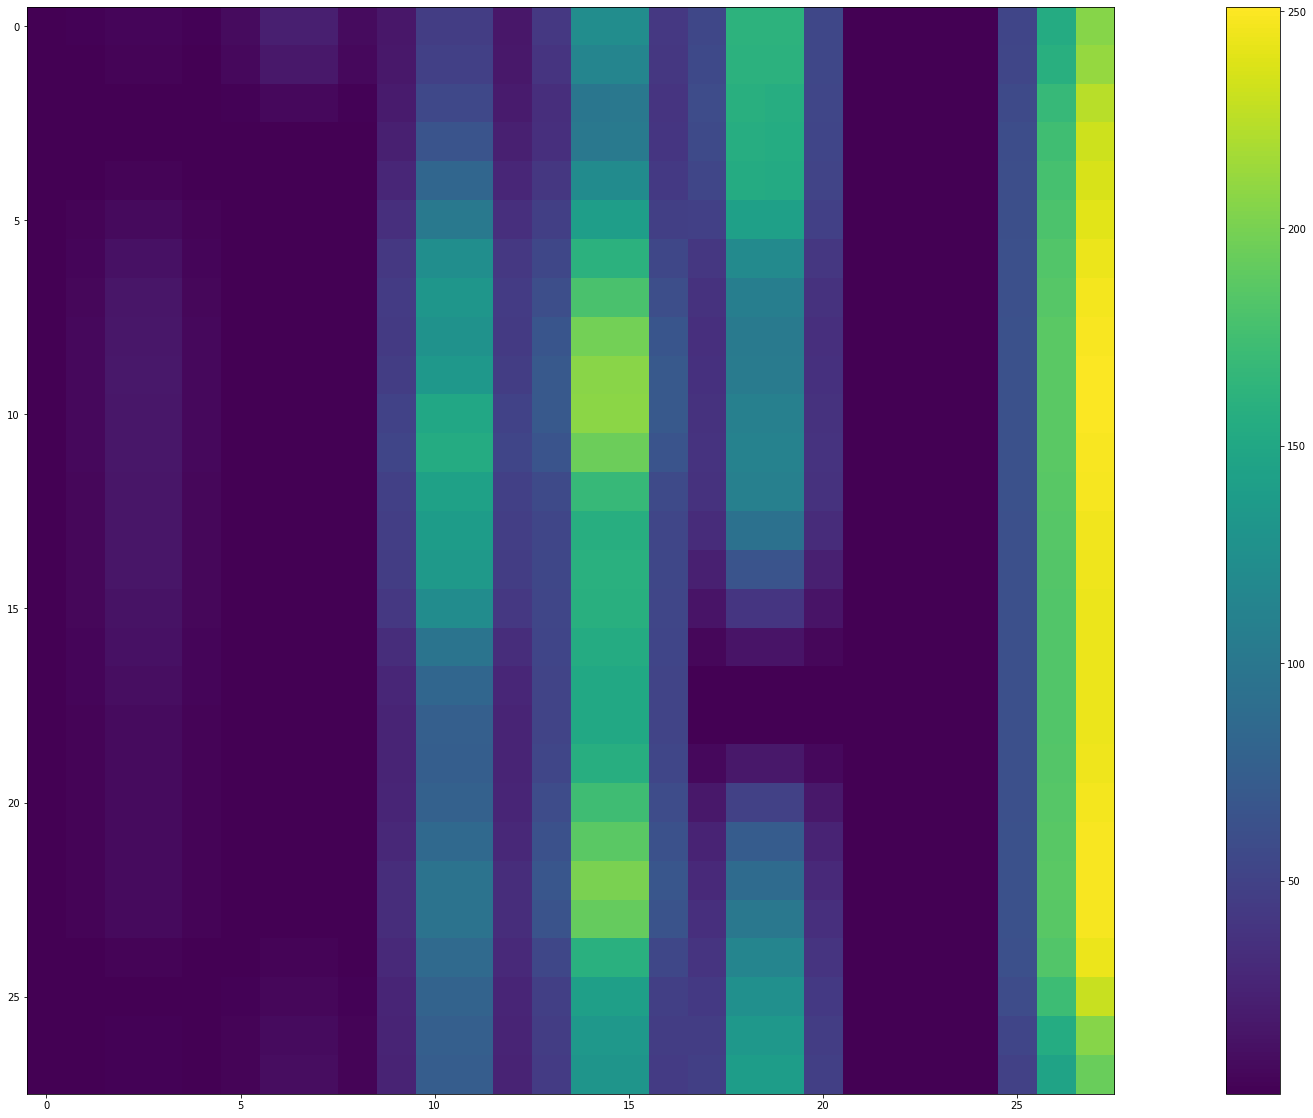

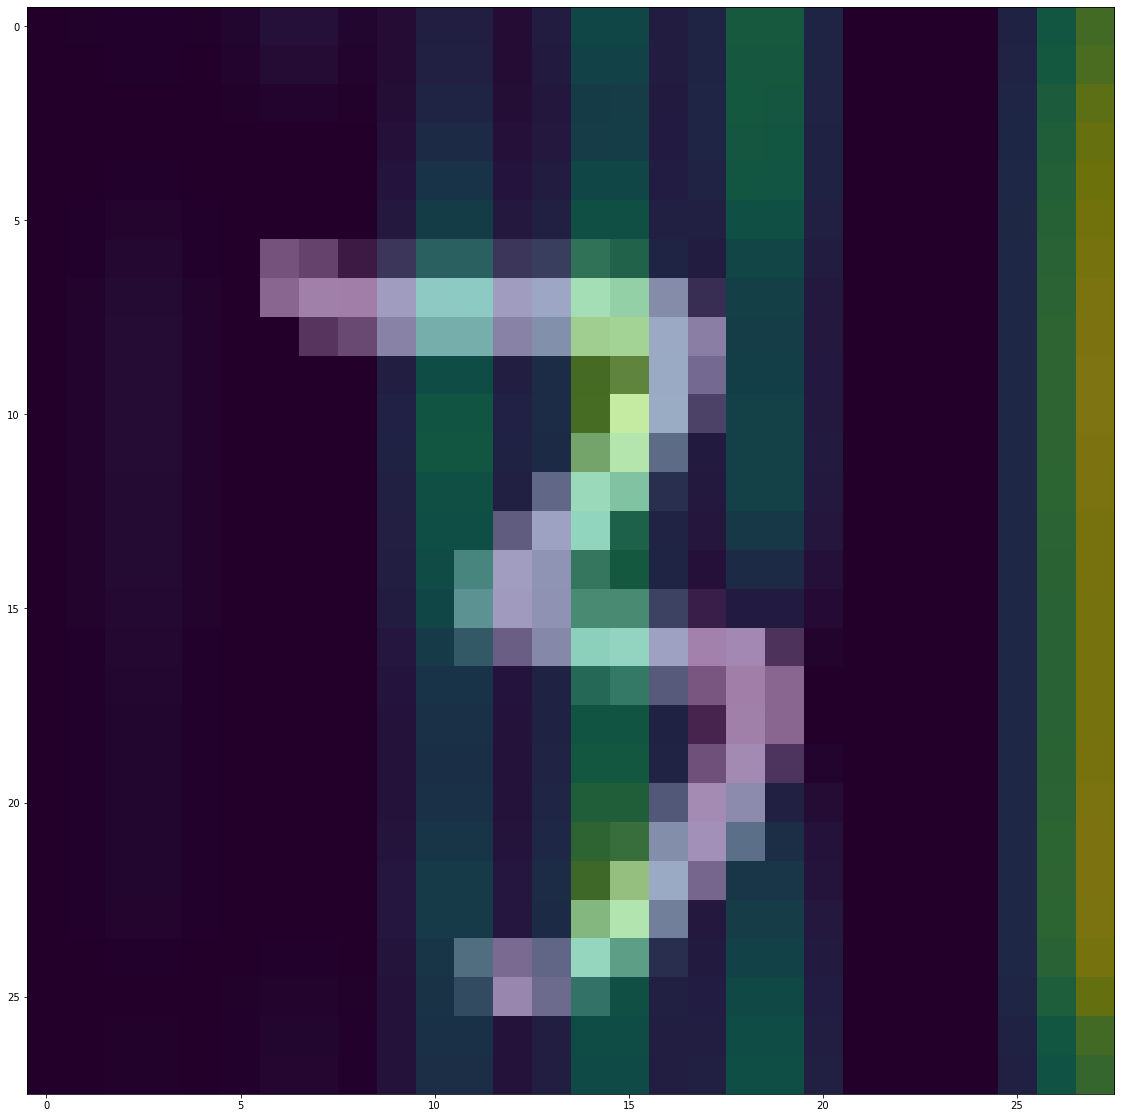

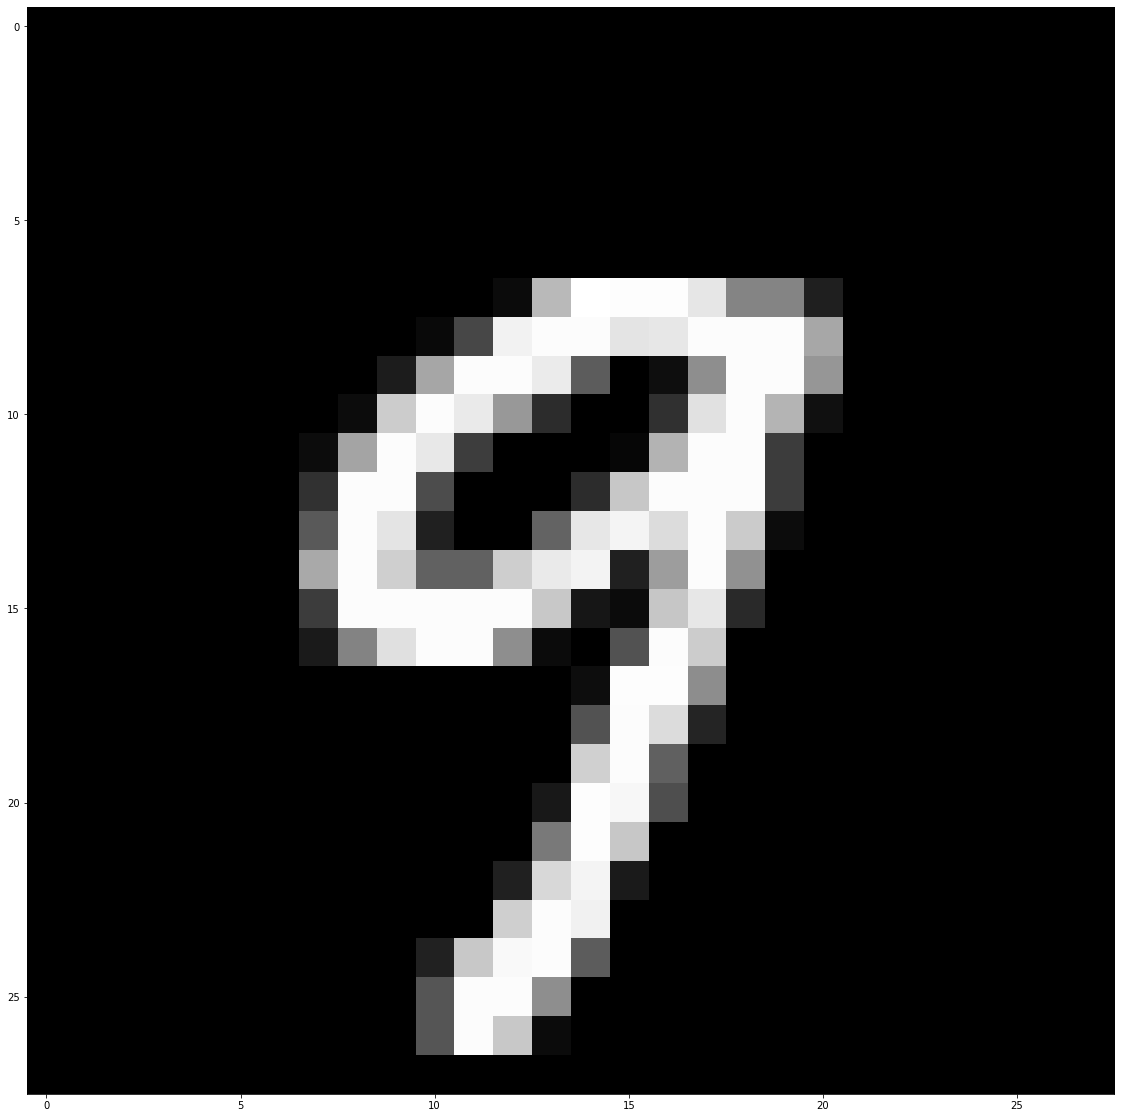

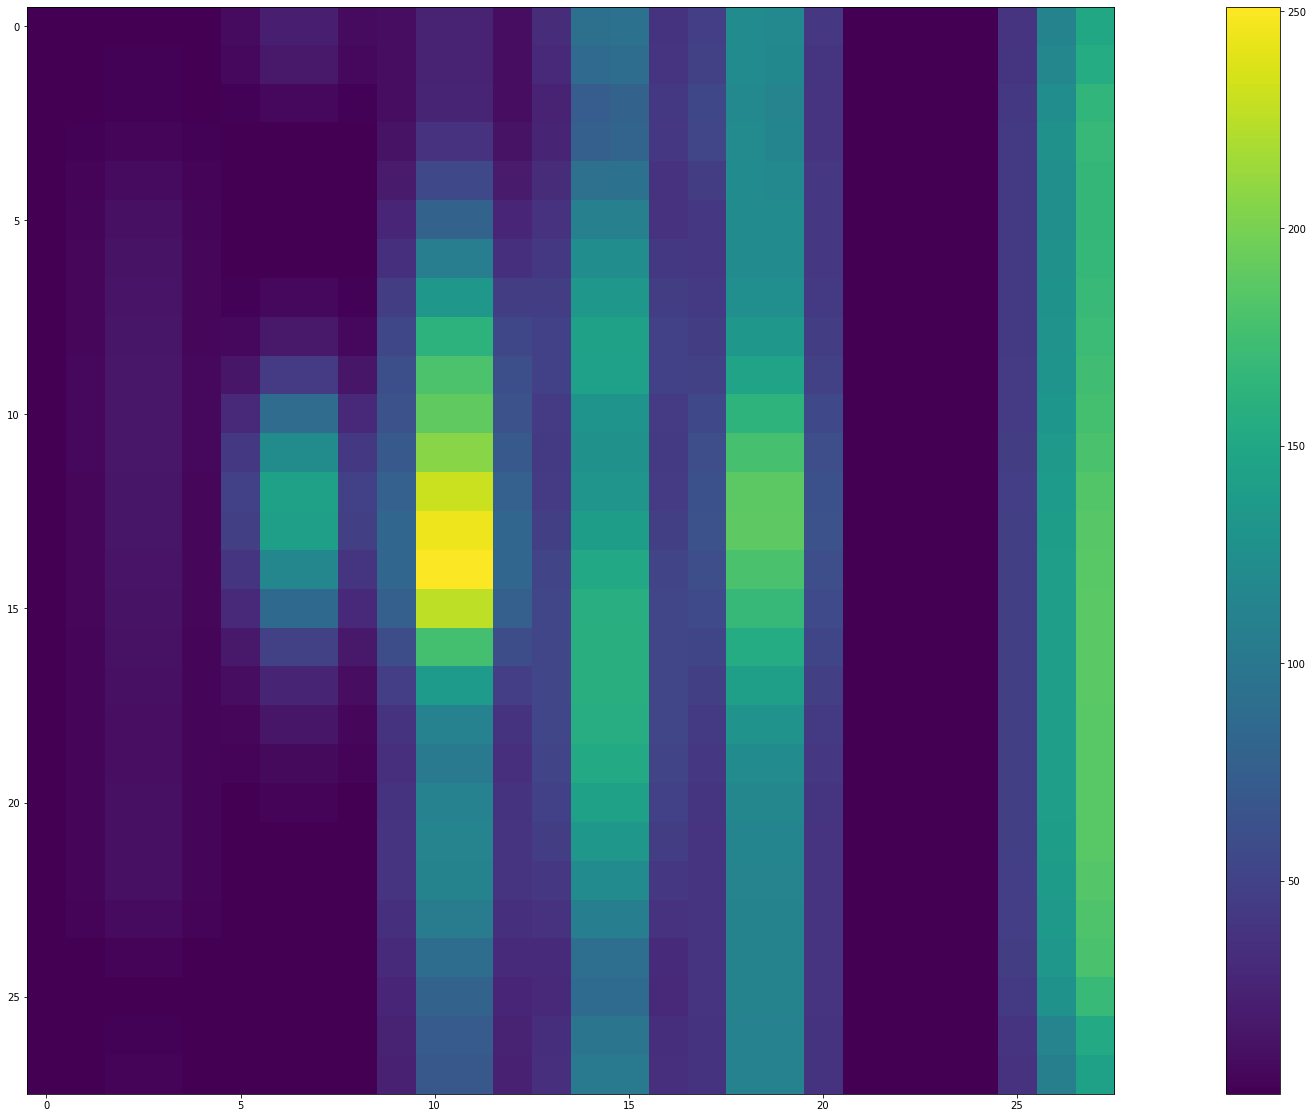

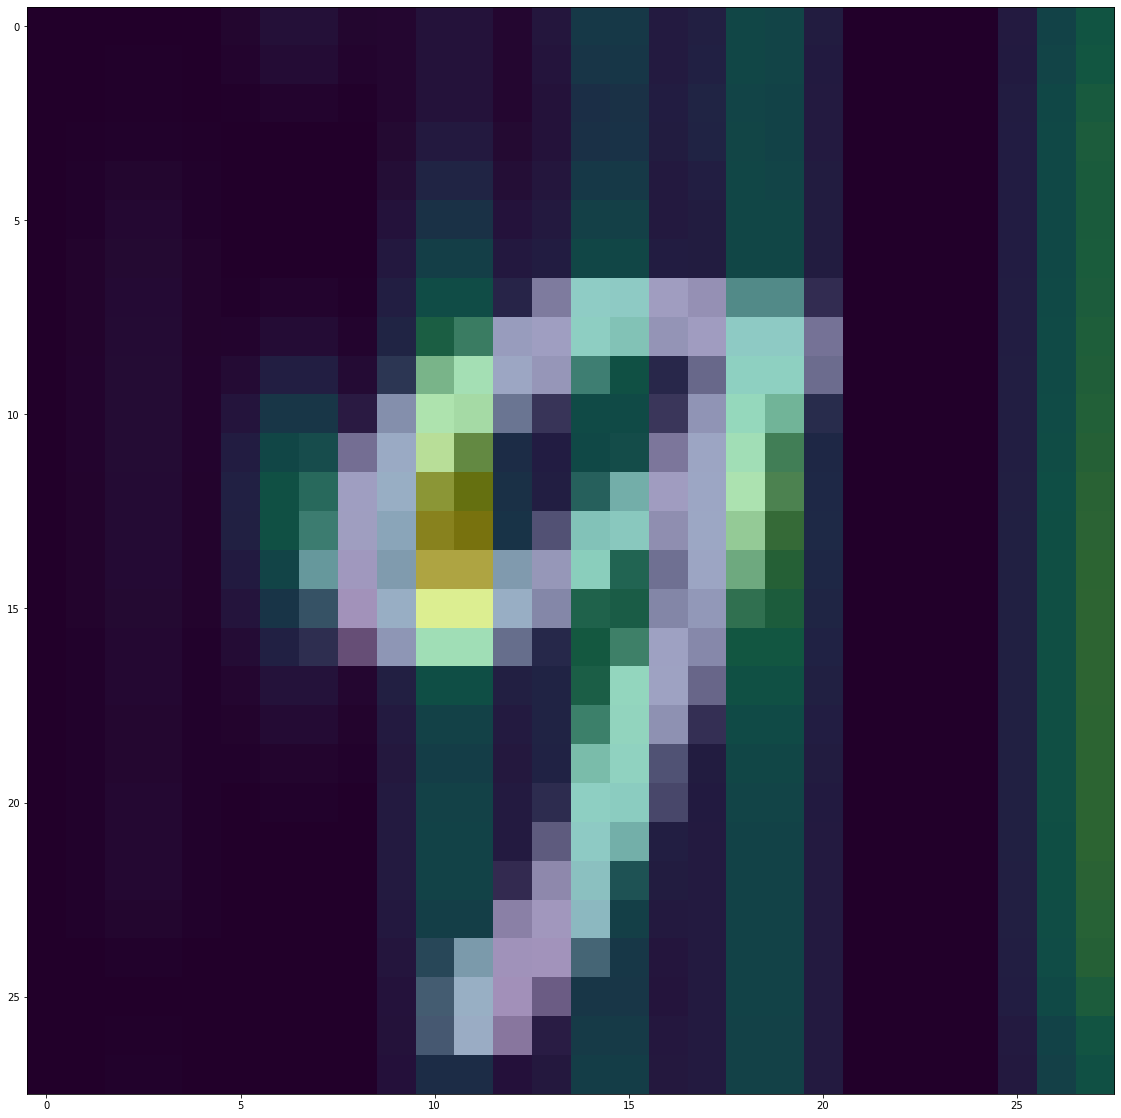

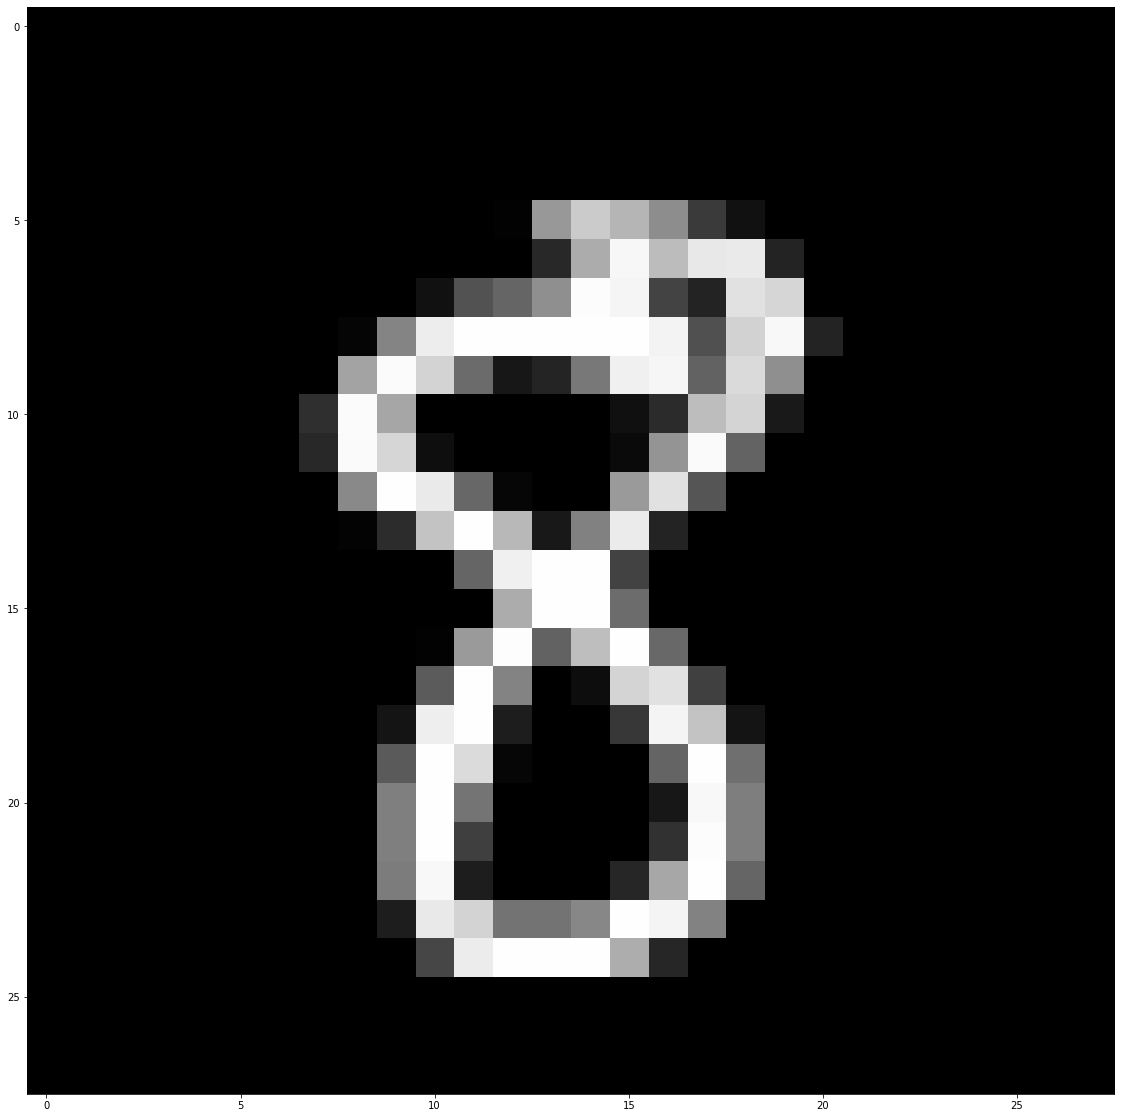

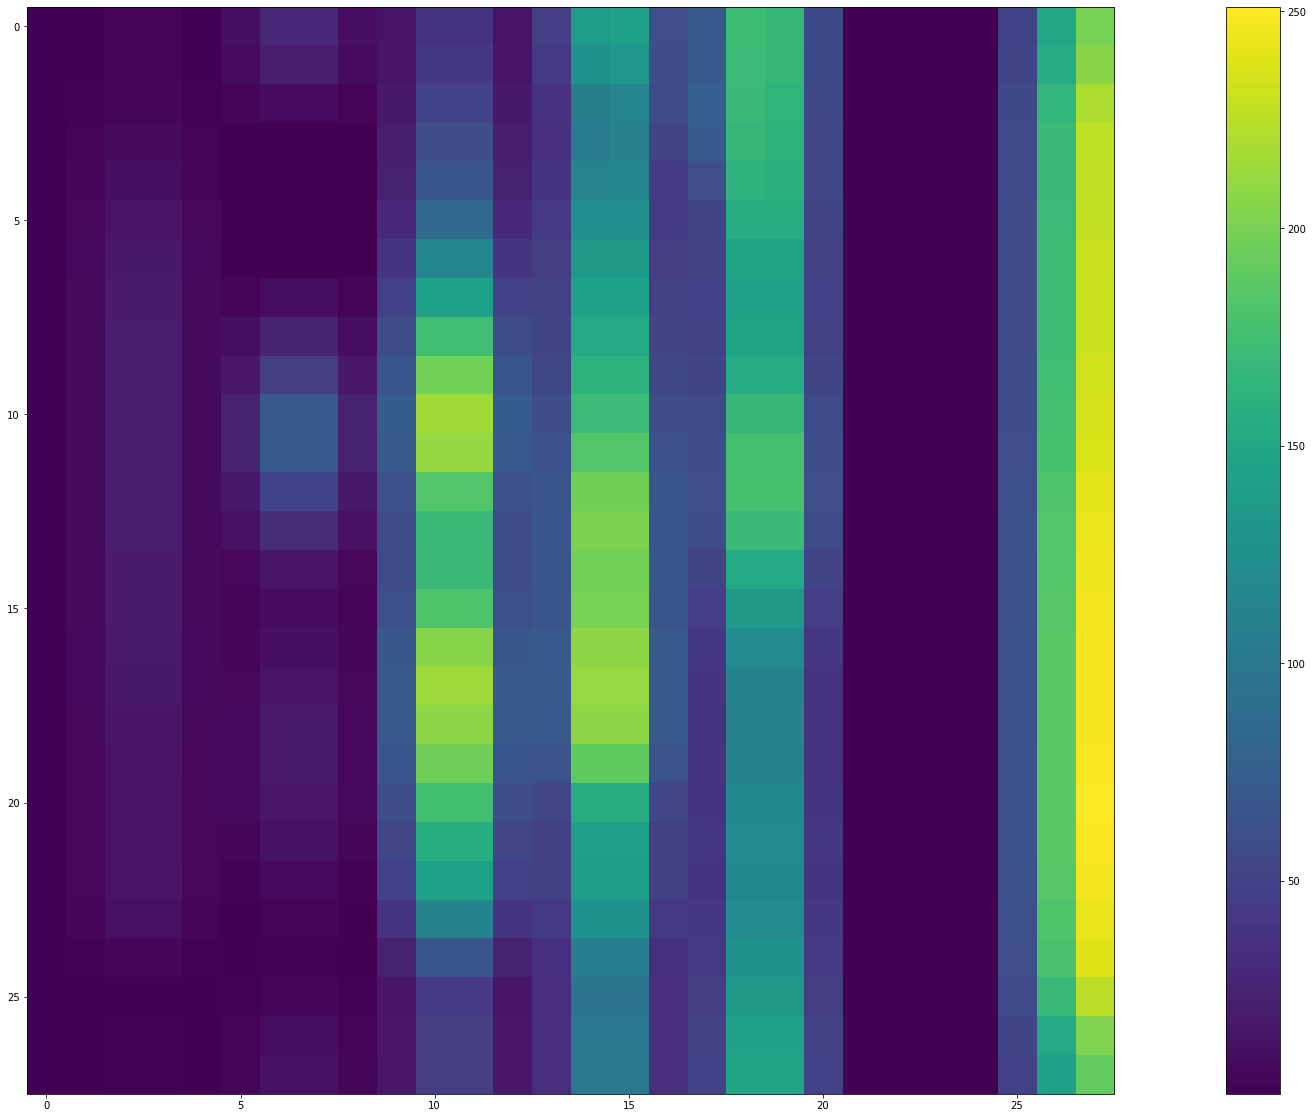

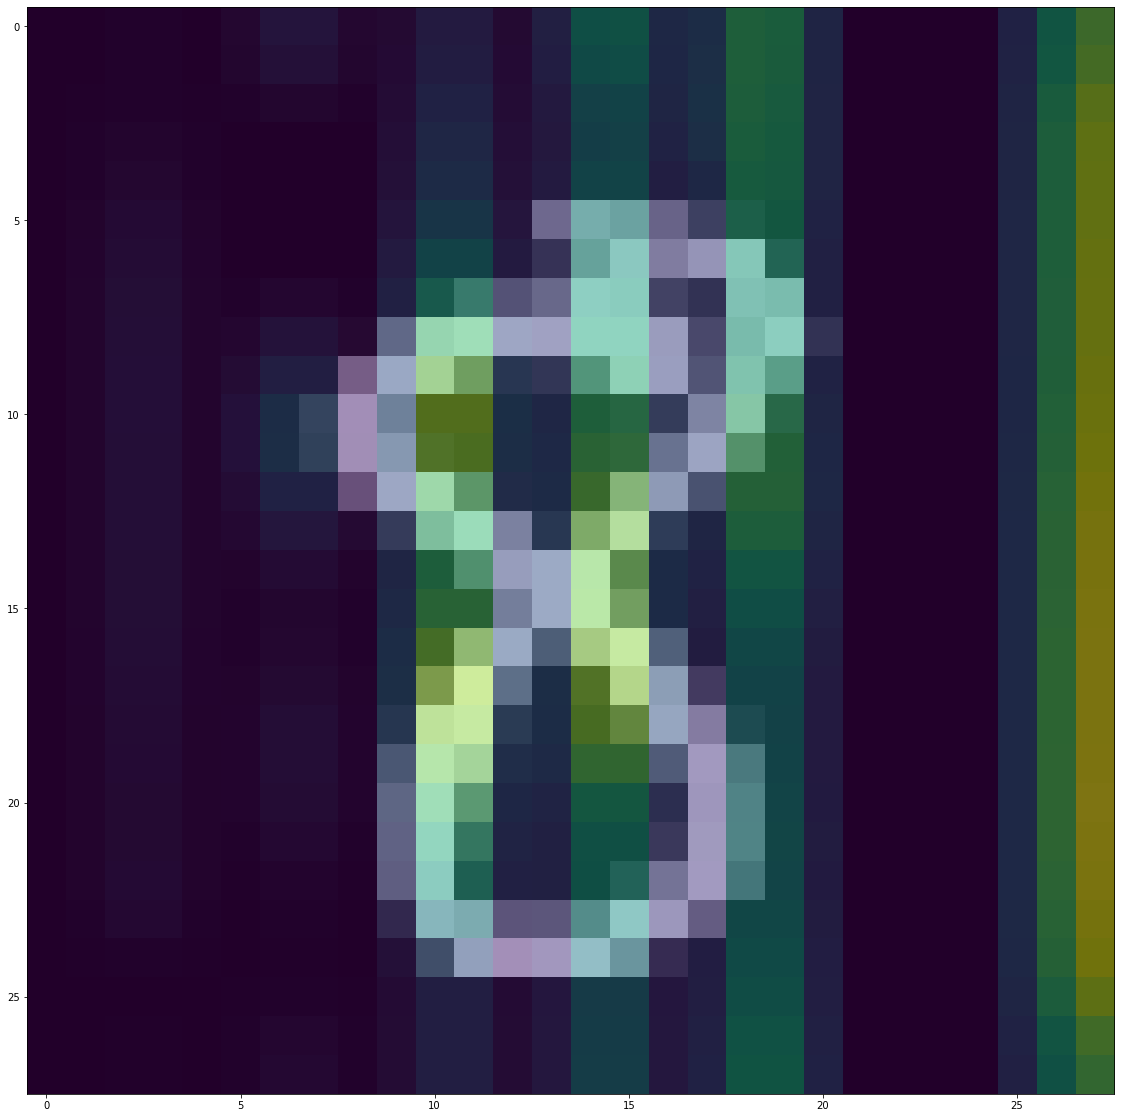

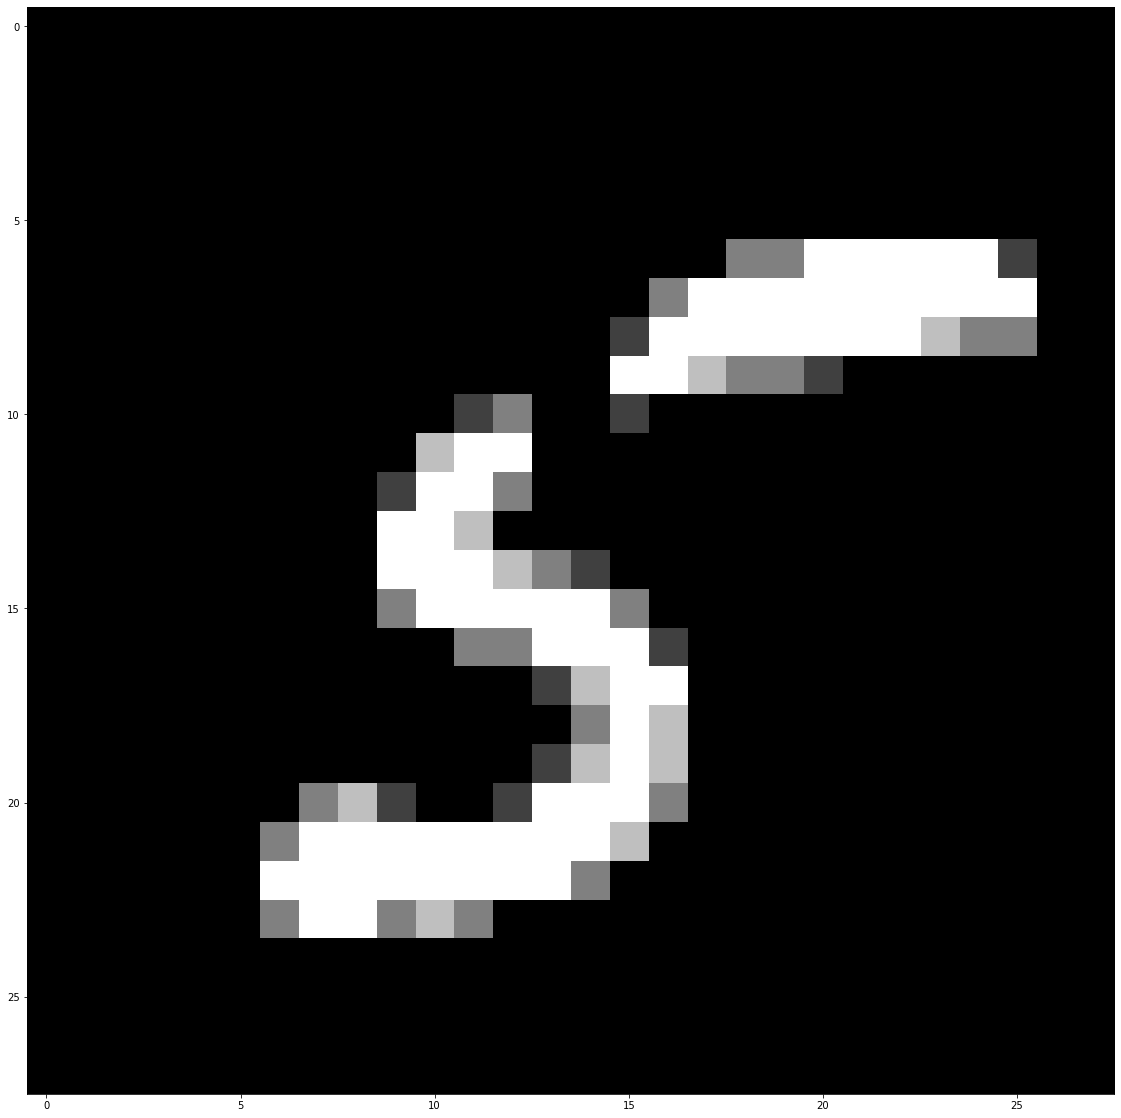

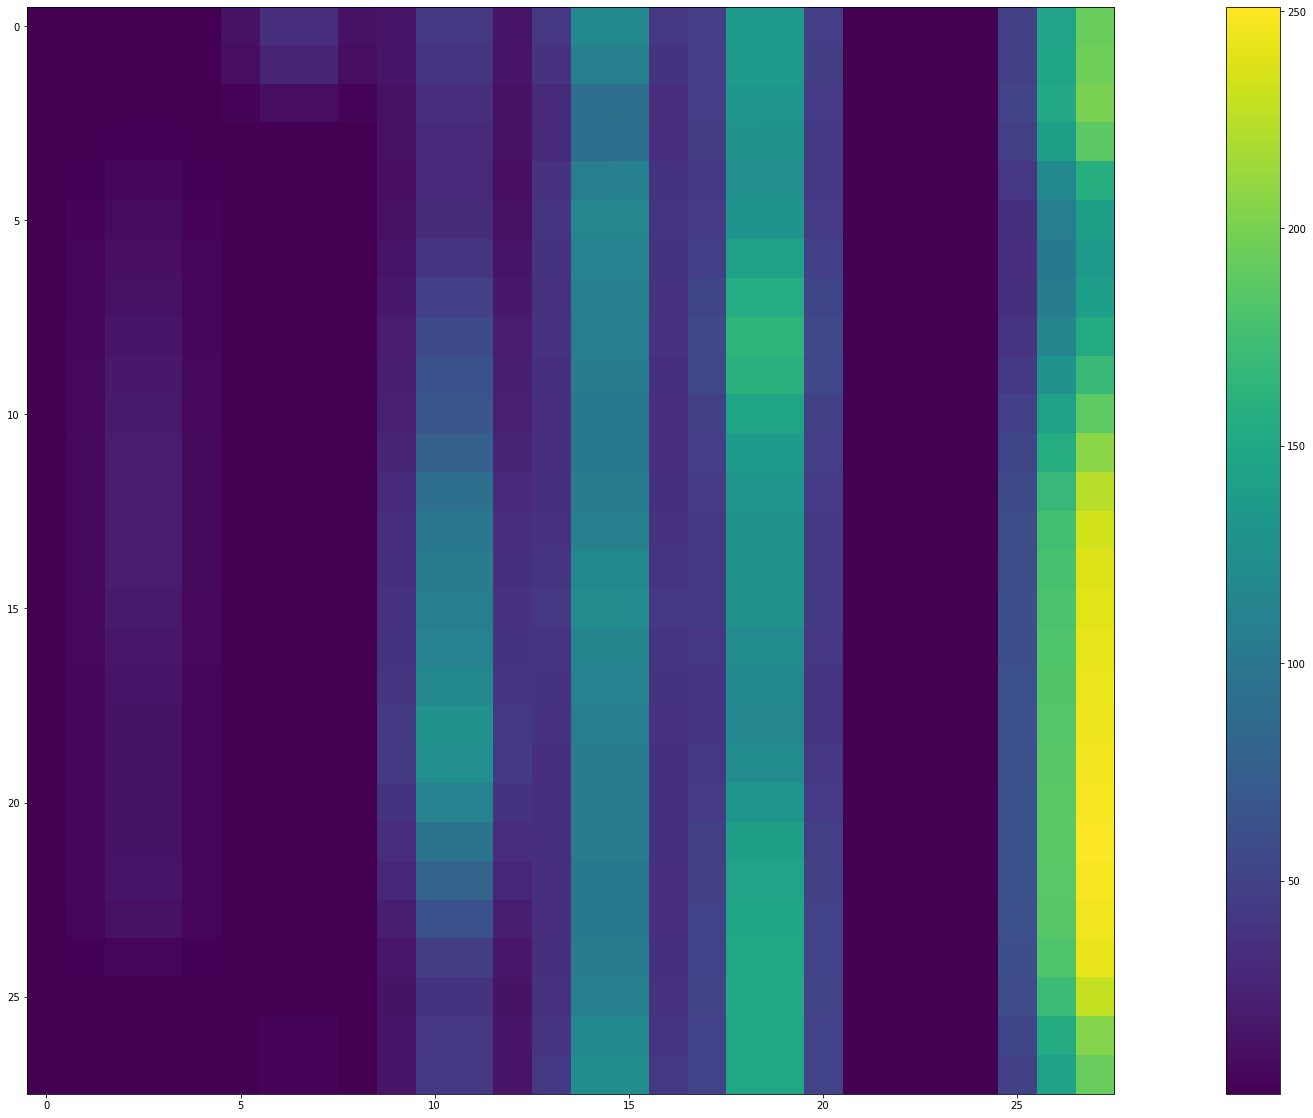

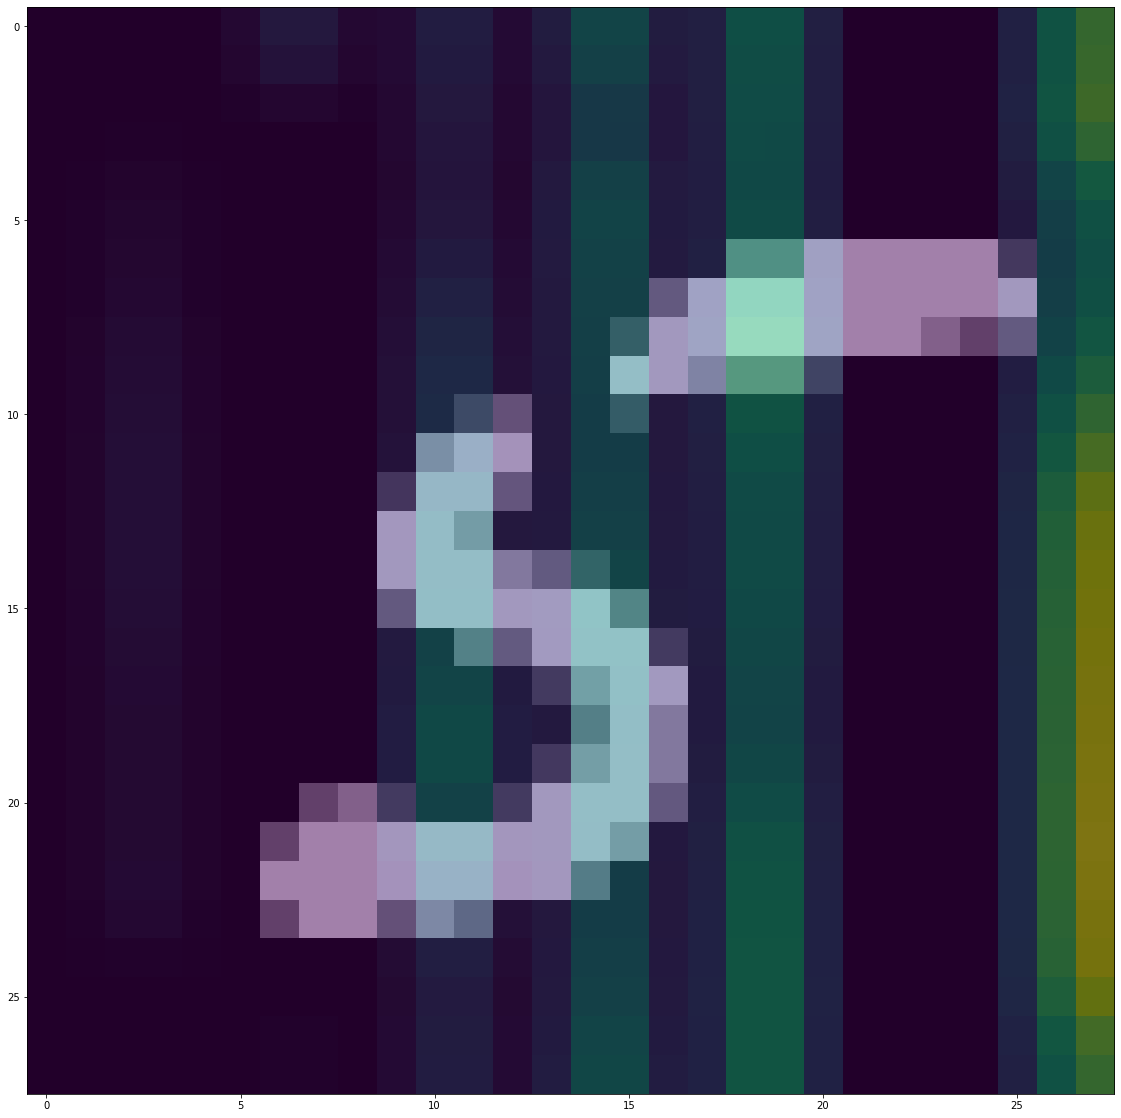

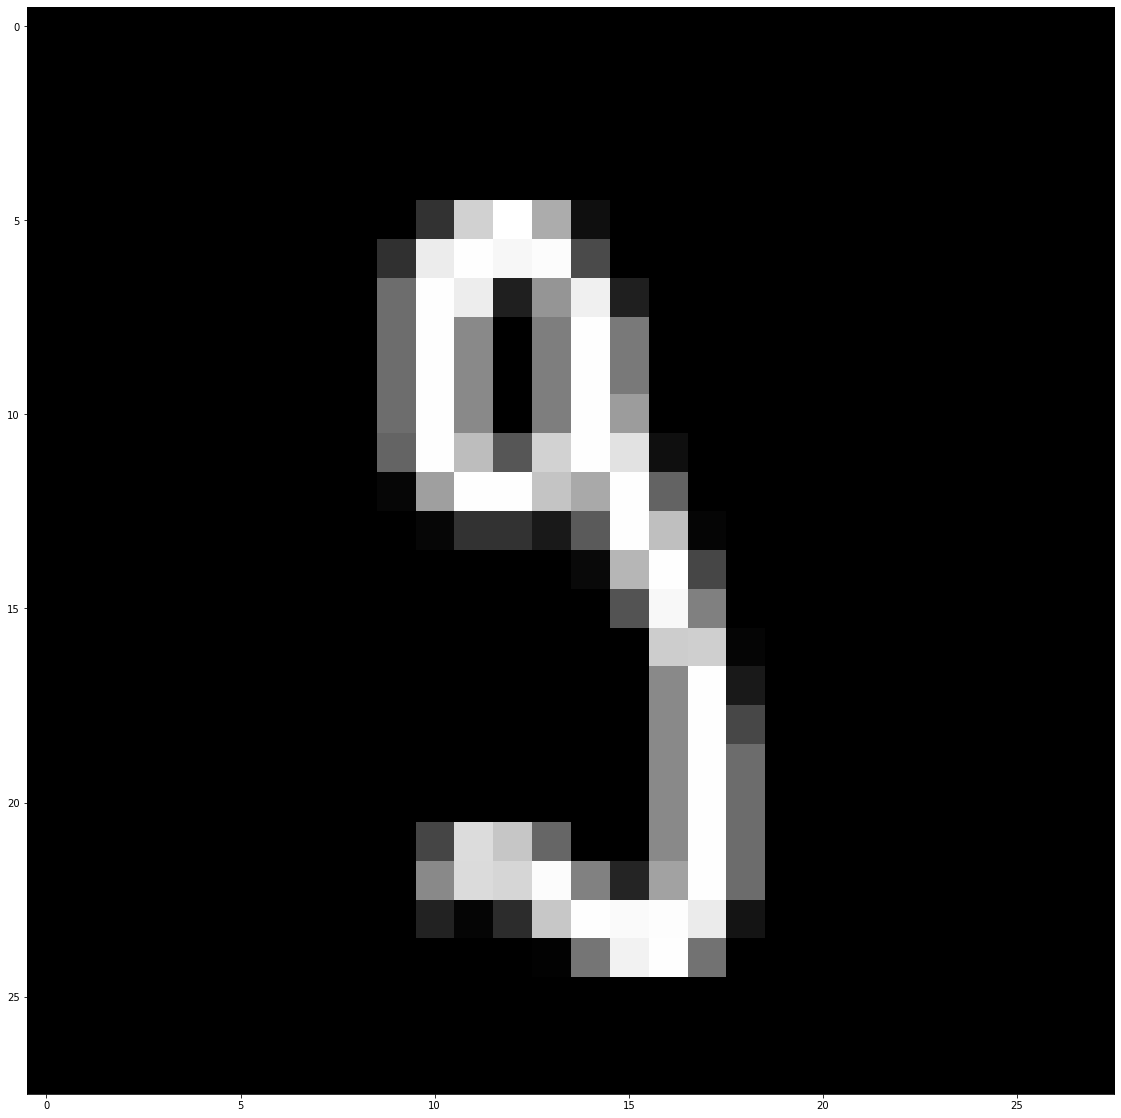

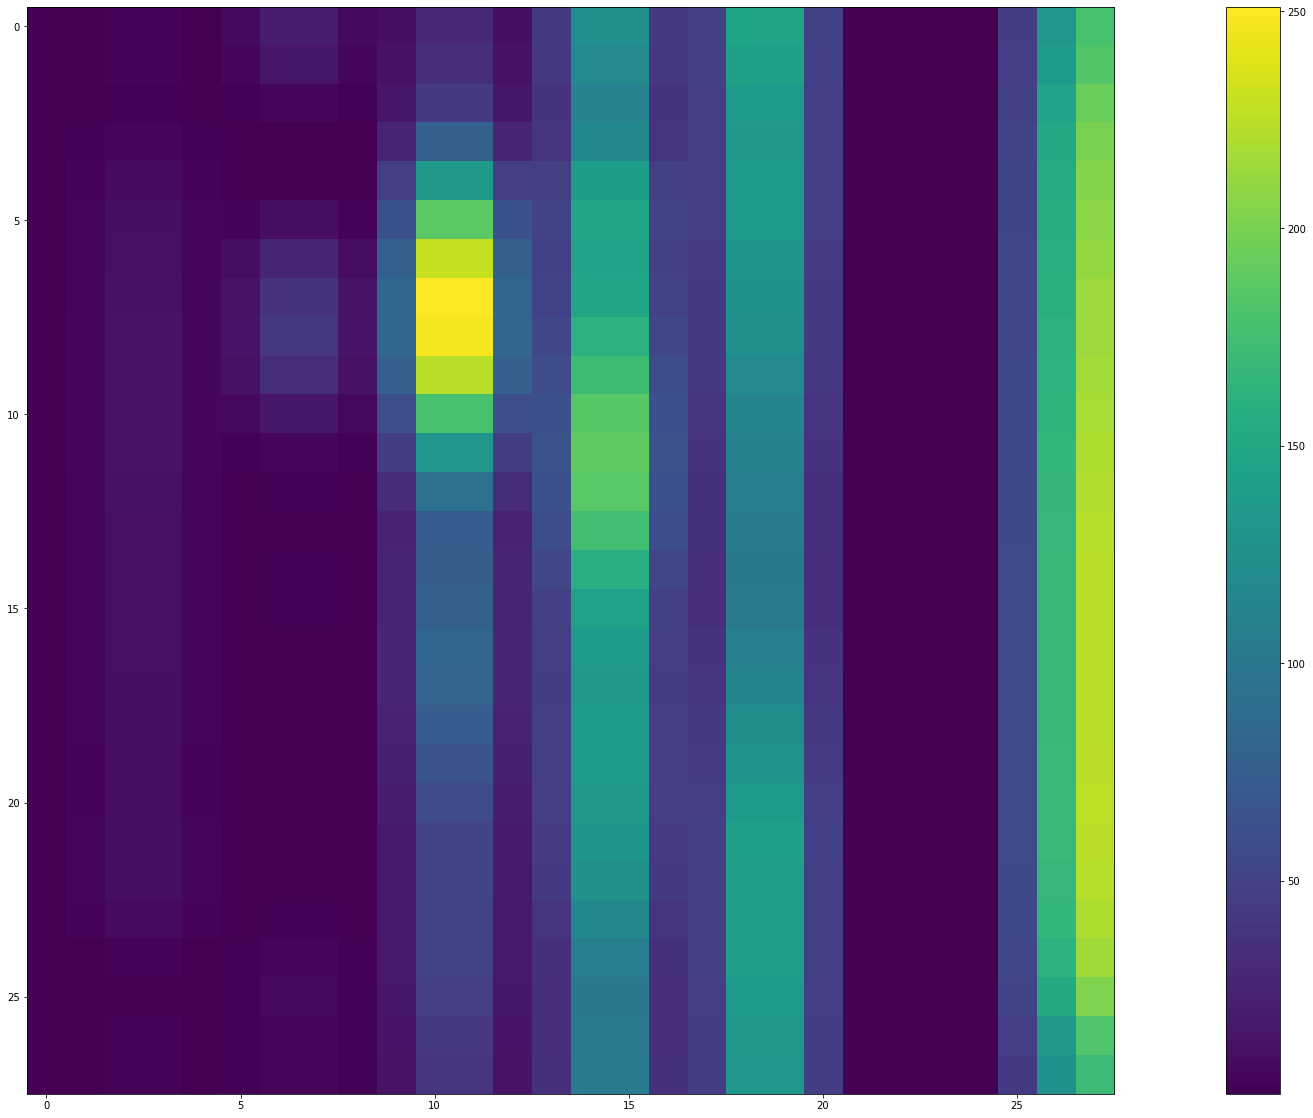

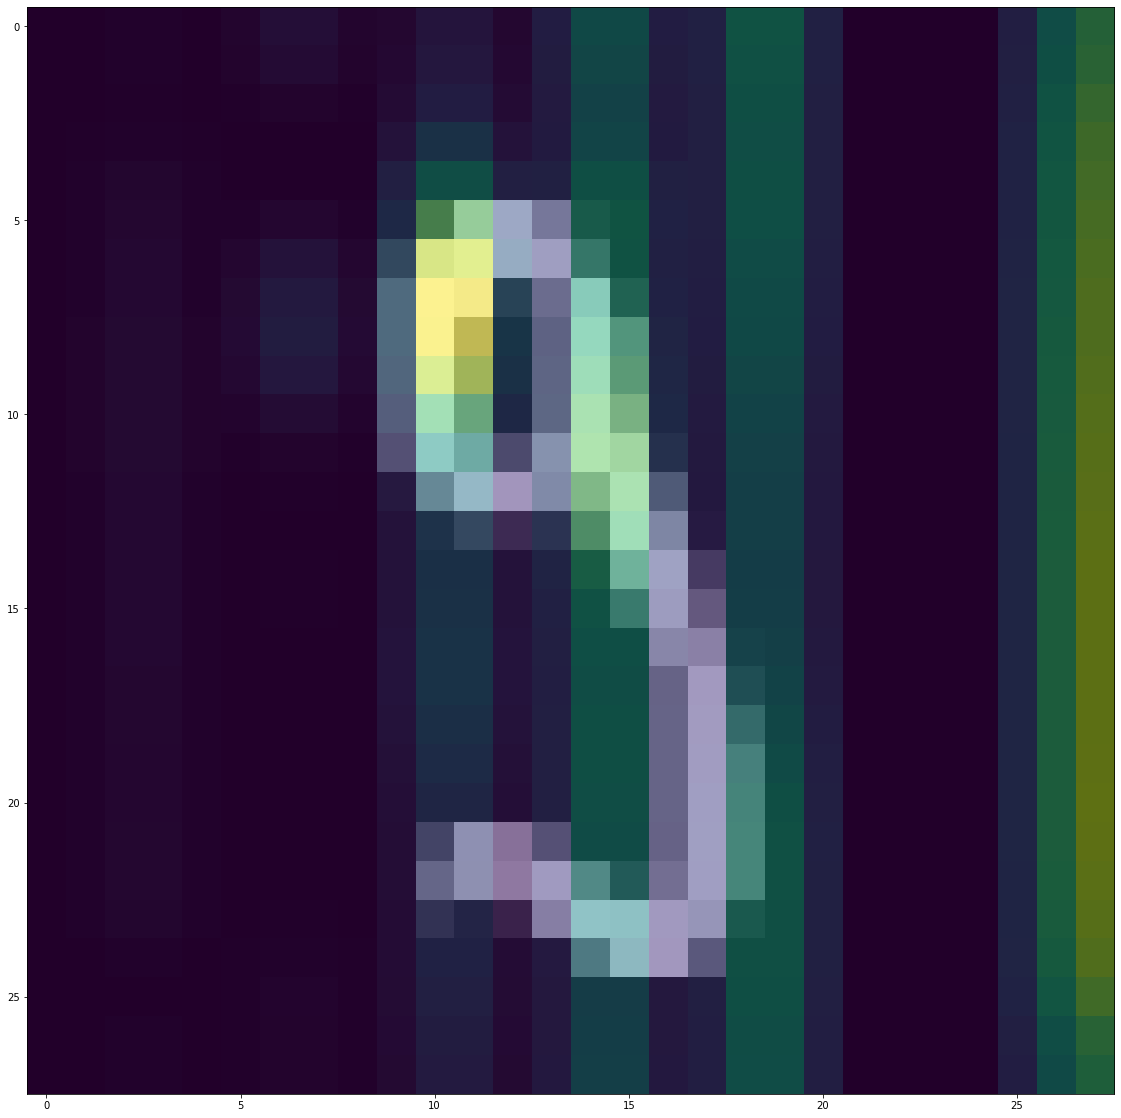

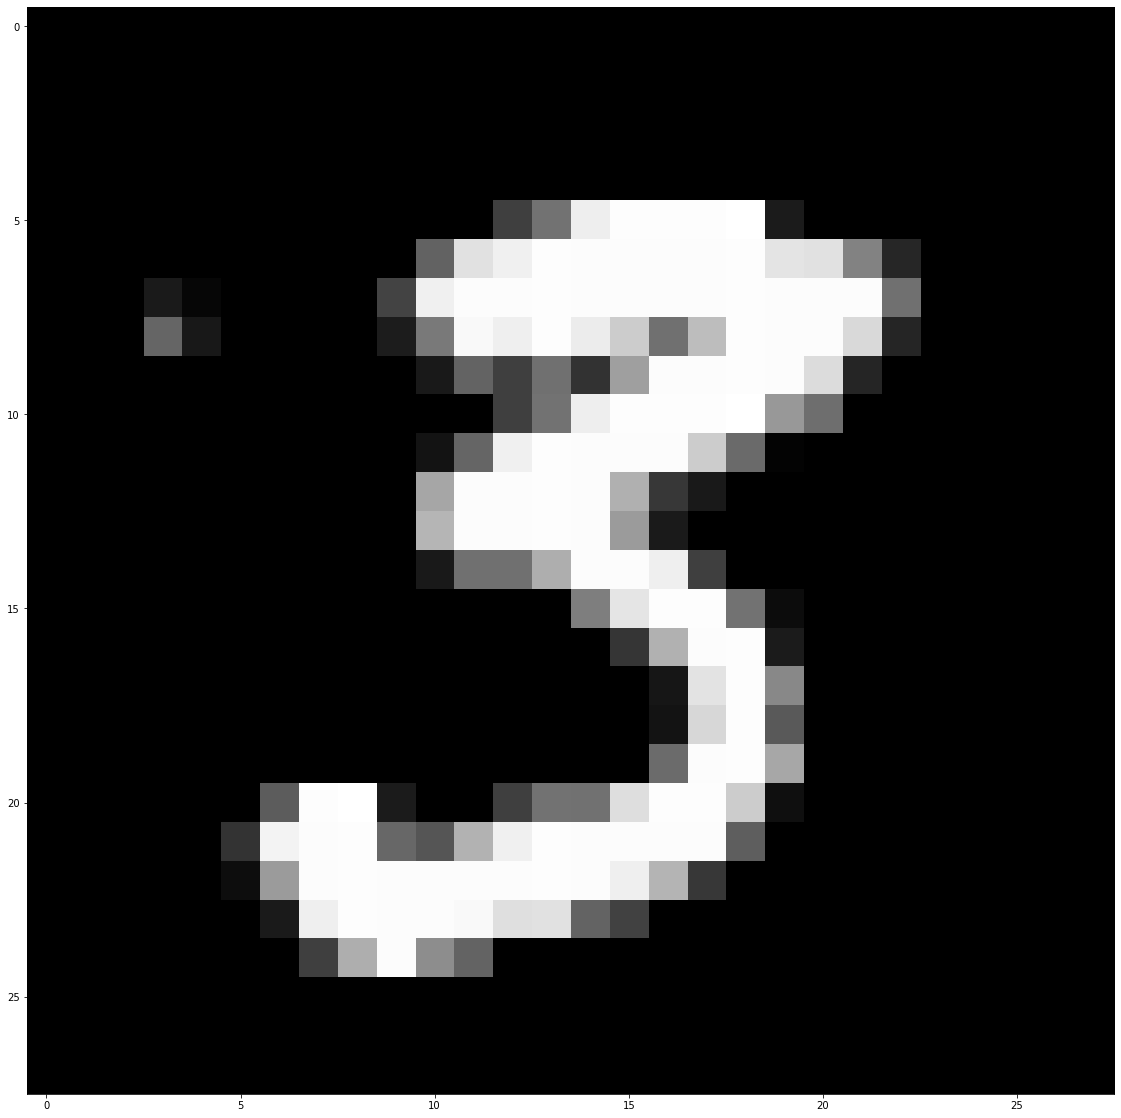

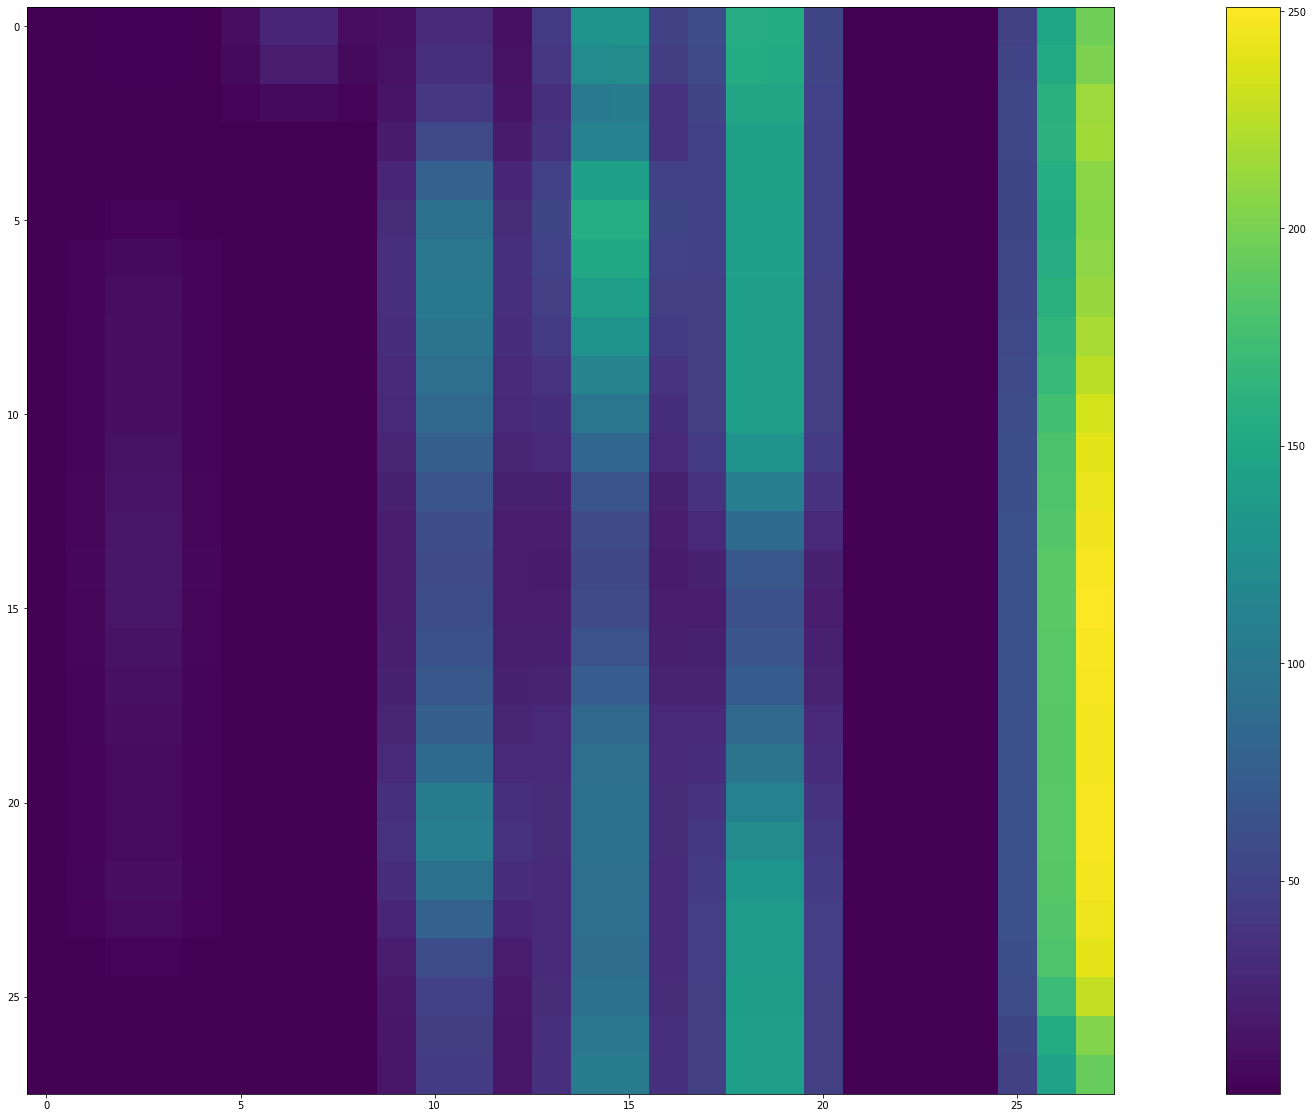

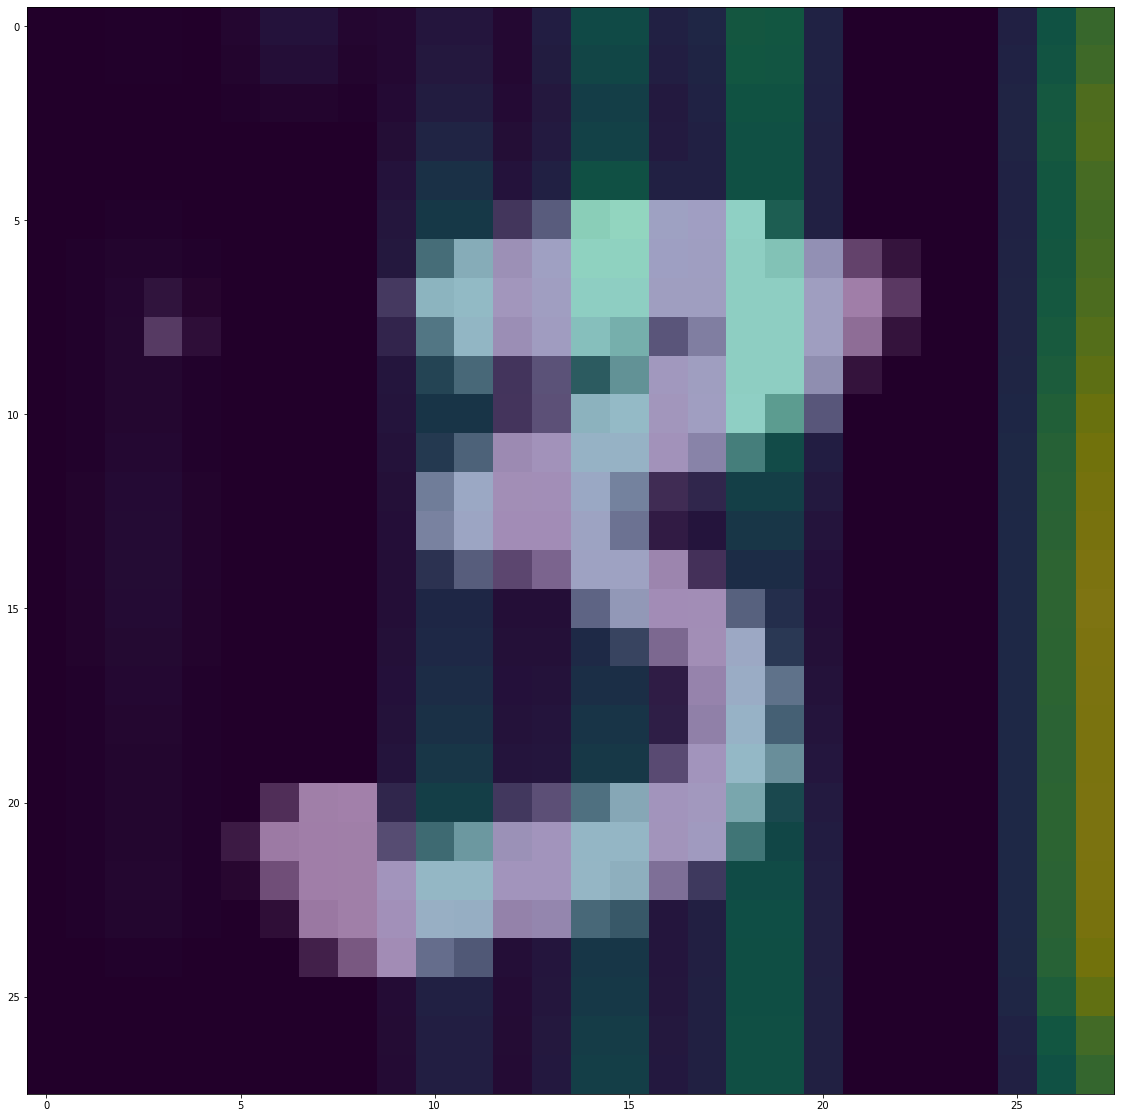

In [41]:

import imutils

model = model

image = x_train[4,:,:,:]
image = np.expand_dims(image,axis=0)


preds = model.predict(image)
i = np.argmax(preds[0])
cam = GradCAM(model, i)


heatmap_seq = cam.compute_heatmap(image)

image = np.concatenate([image,image,image],axis=-1)
print(np.max(heatmap_seq))

(heatmap_seq, output_seq) = cam.overlay_heatmap(heatmap_seq, image, alpha=0.5)


num_sequence = 10;

for seq in range(num_sequence):
    orig = image[0,seq,...];
    heatmap = heatmap_seq[seq,...];
    output = output_seq[seq,...];
    heatmap = (heatmap ).astype("uint8")
    orig = (orig * 255).astype("uint8")
    output = (output ).astype("uint8")
    
    
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(40,20))
    plt.imshow(orig)
    plt.figure(figsize=(40,20))
    plt.imshow(heatmap)
    plt.colorbar()
    plt.figure(figsize=(40,20))
    plt.imshow(output)


In [44]:
x_train_test = x_test[20];
x_train_test = x_train_test[...,None];
x_train_test = x_train_test.reshape([1,10,28,28,1])
layer_name='time_distributed_21';
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train_test)

attention_weight = model.layers[23].get_weights();
attention_weight= np.array(attention_weight);
w = attention_weight[0];
V = attention_weight[1];
U = attention_weight[2];
bw = attention_weight[3];
bV = attention_weight[4];
bU = attention_weight[5];

out_V = np.tanh(np.dot(intermediate_output,V)+bV)
out_U = 1 / (1 + np.exp((np.dot(intermediate_output,U)+bU)))

combines = out_U*out_V

total = np.exp(np.dot(combines,w)+bw);

total

array([[[0.56645393],
        [3.3934445 ],
        [0.40908438],
        [0.30562624],
        [0.3401887 ],
        [0.5724552 ],
        [0.5158114 ],
        [0.3374785 ],
        [2.7493463 ],
        [3.5585368 ]]], dtype=float32)

2
2
3
3
3
5
5
time_distributed_17
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
inputs
(1, 10, 1, 256)
dot product
(1, 10, 1, 256)
tanh
(1, 10, 1, 256)
combUV
(1, 10, 1, 256)
attention_weights
(1, 10, 1, 1)
attention_weights sum
(1, 10, 1, 1)
attention_weights last
(1, 10, 1)
output
(1, 256)
*
28
28
(10, 14, 14)
254.0
overlay final
10,28,28
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)
overlay
(28, 28, 3)
(28, 28, 1)
(28, 28, 3)


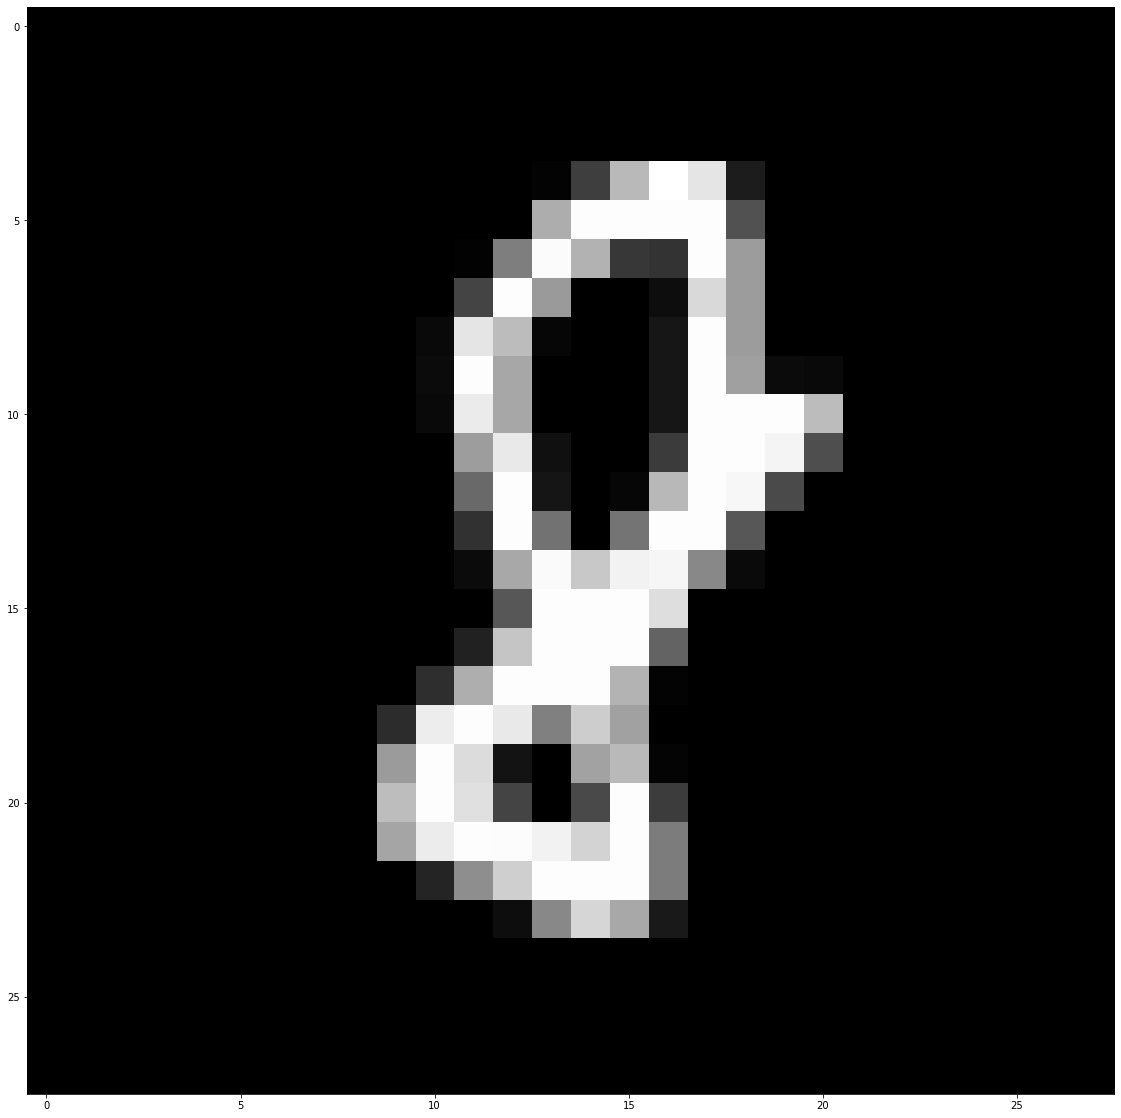

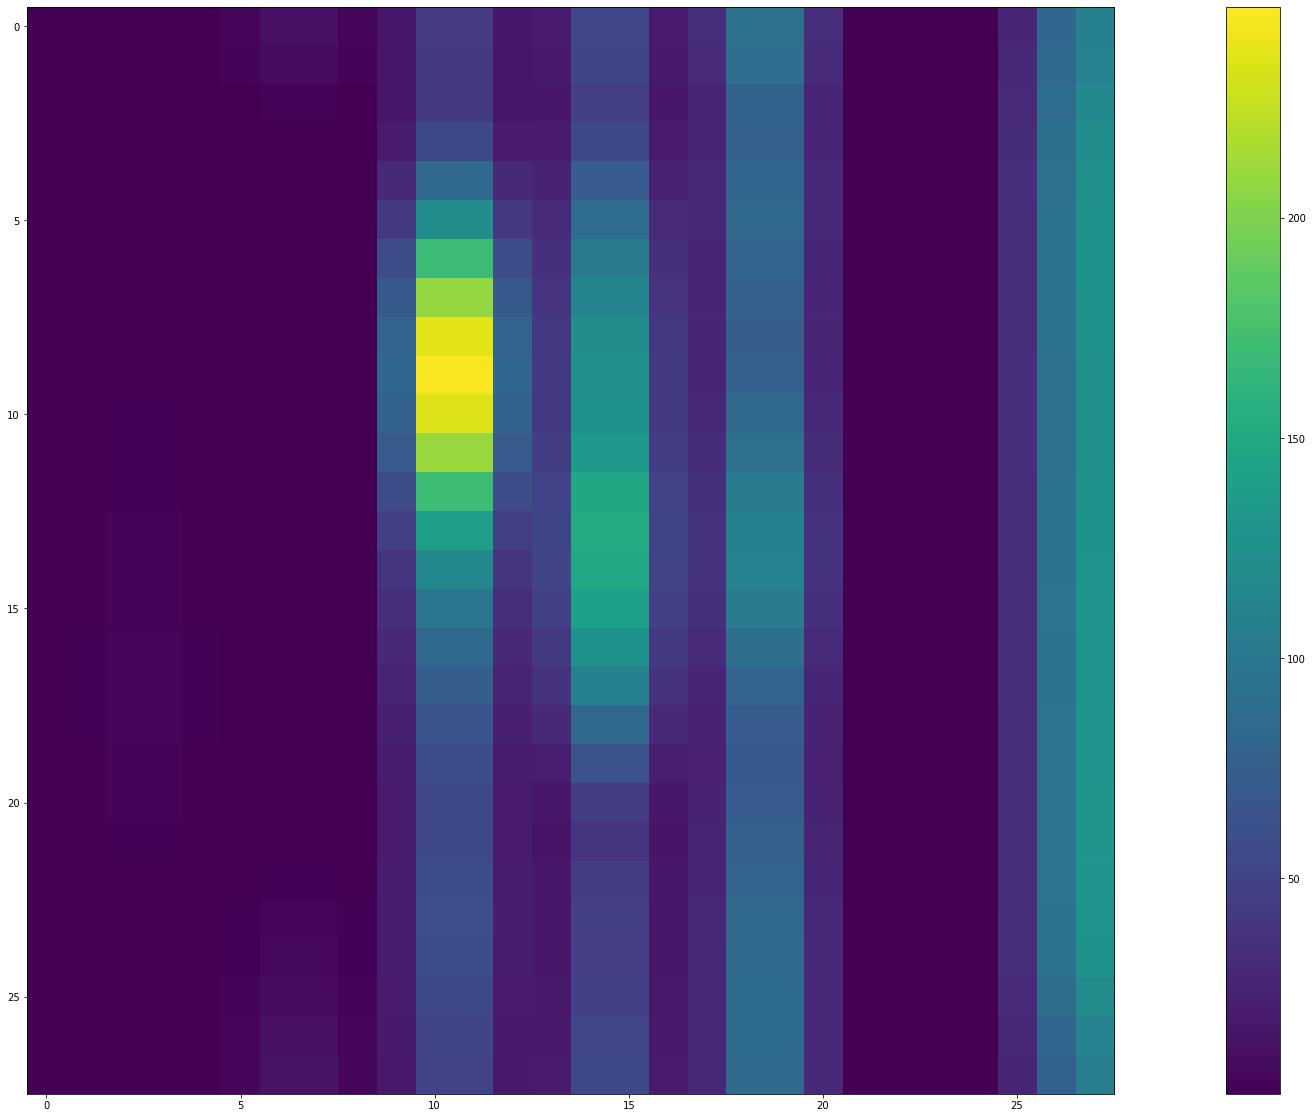

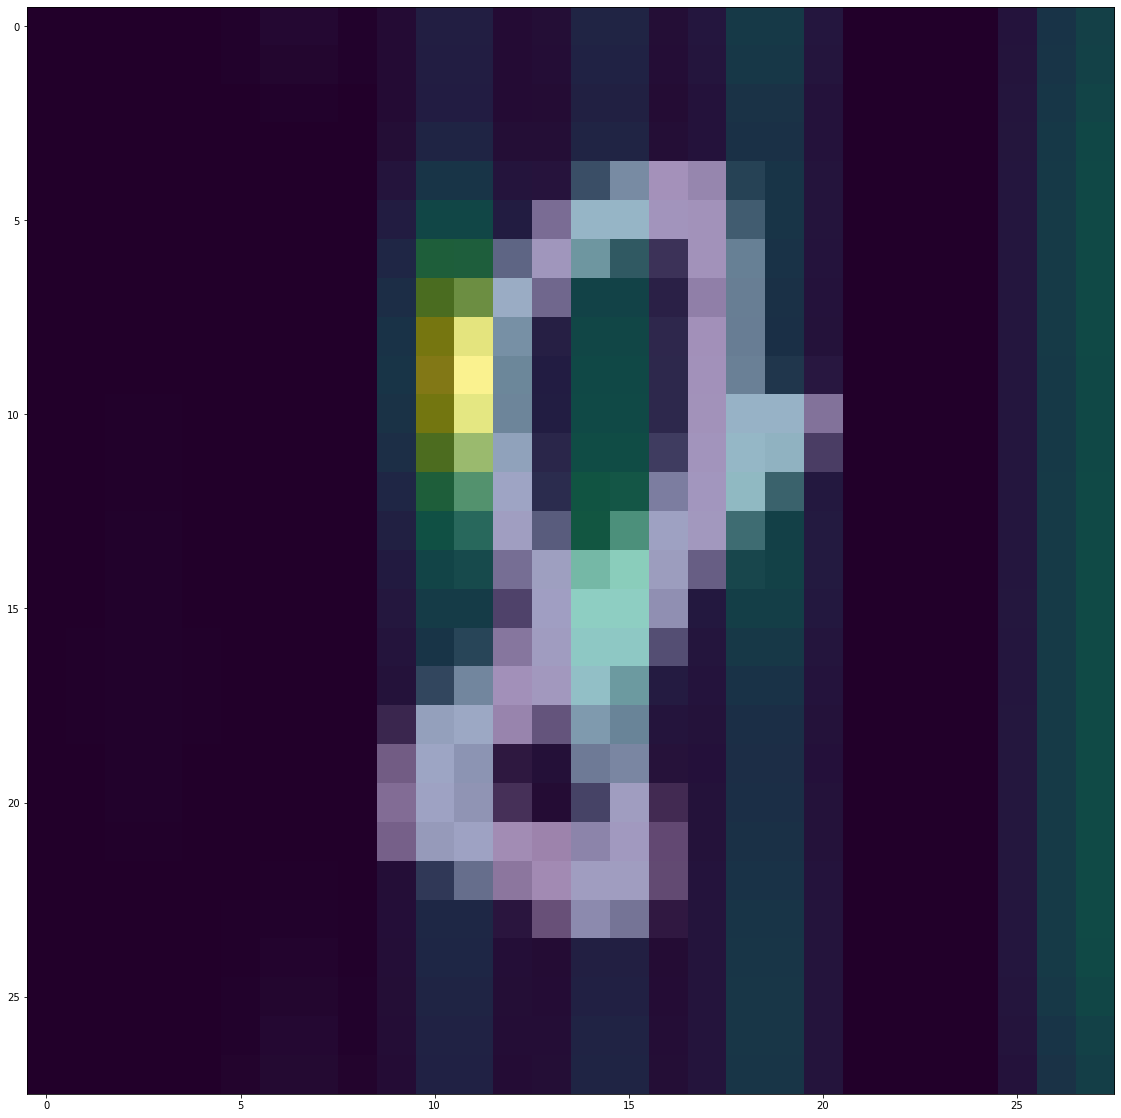

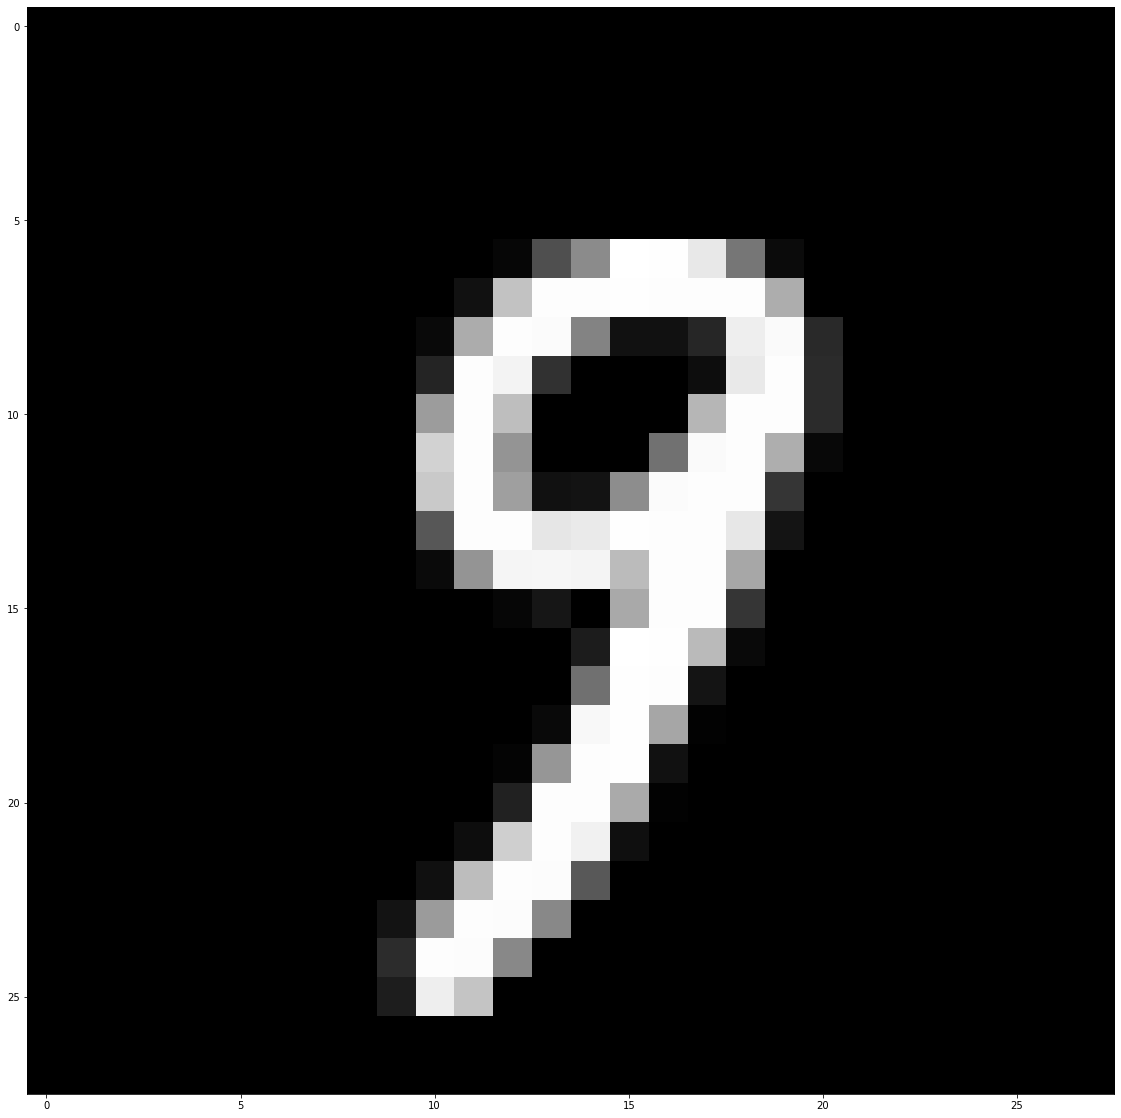

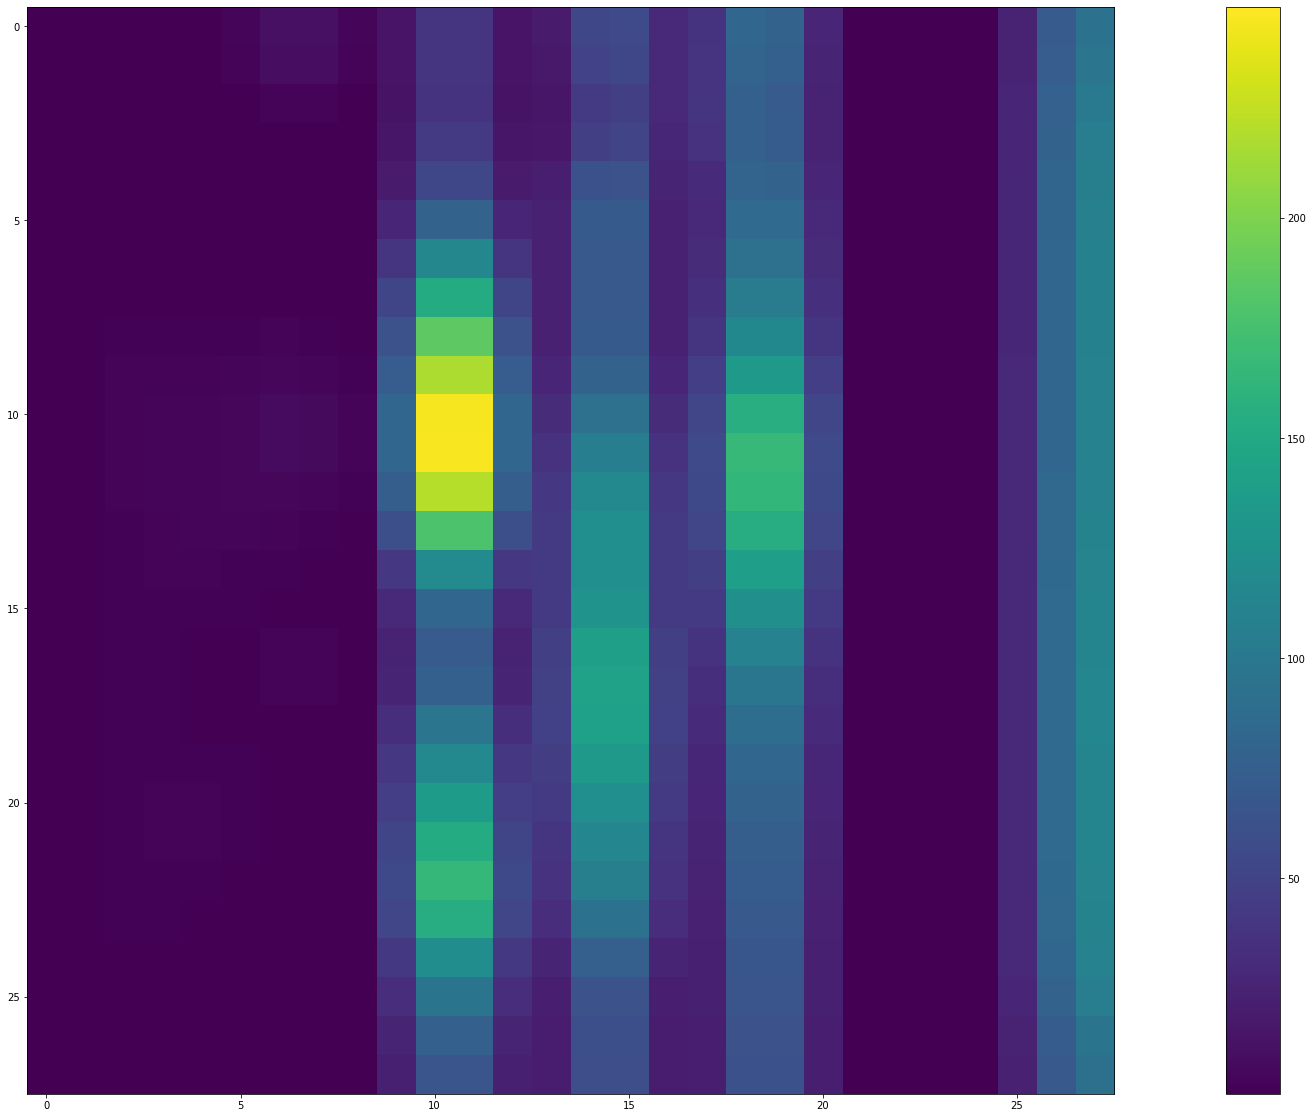

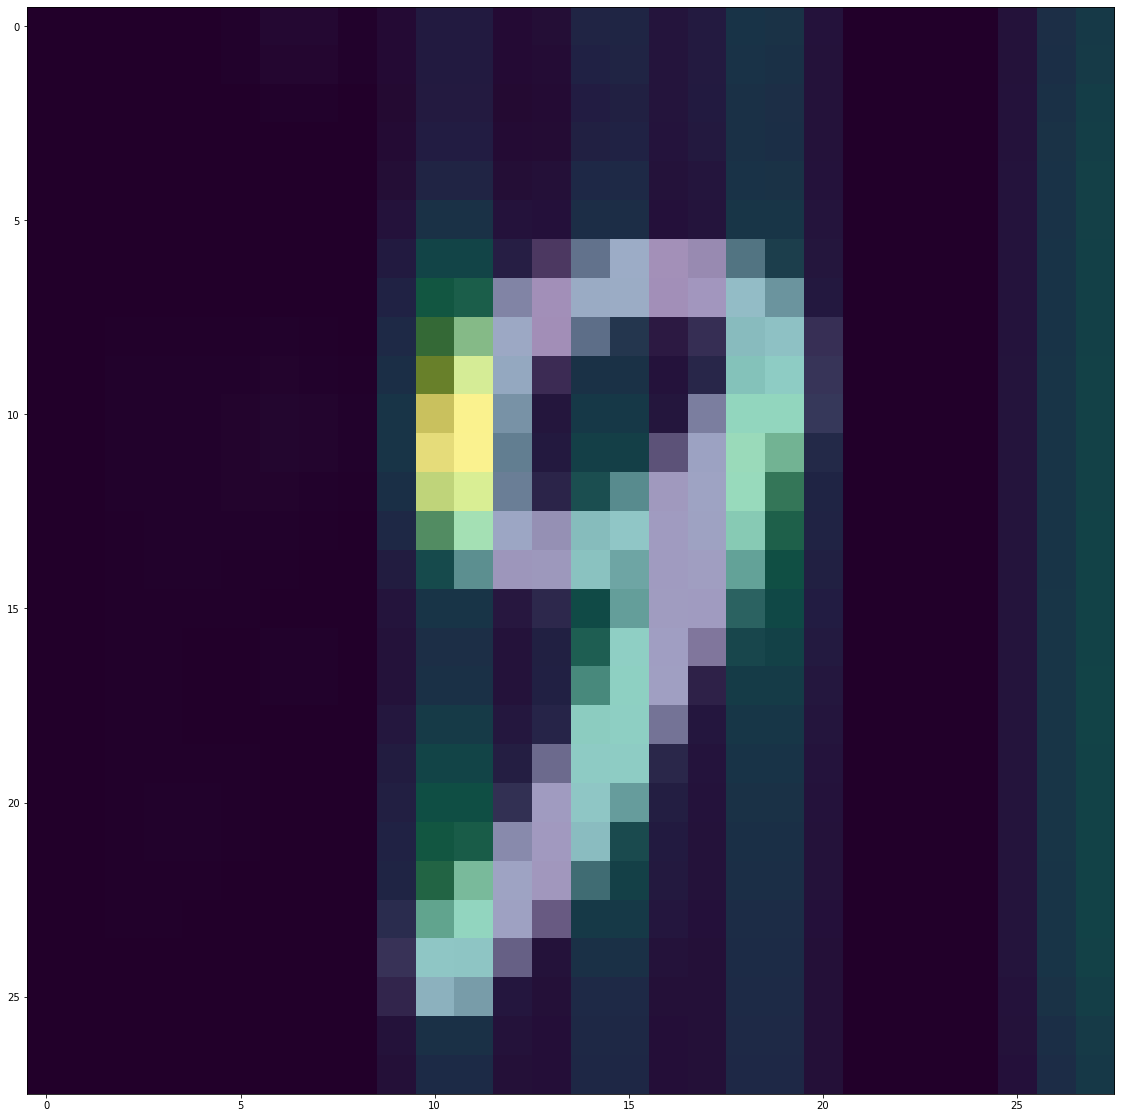

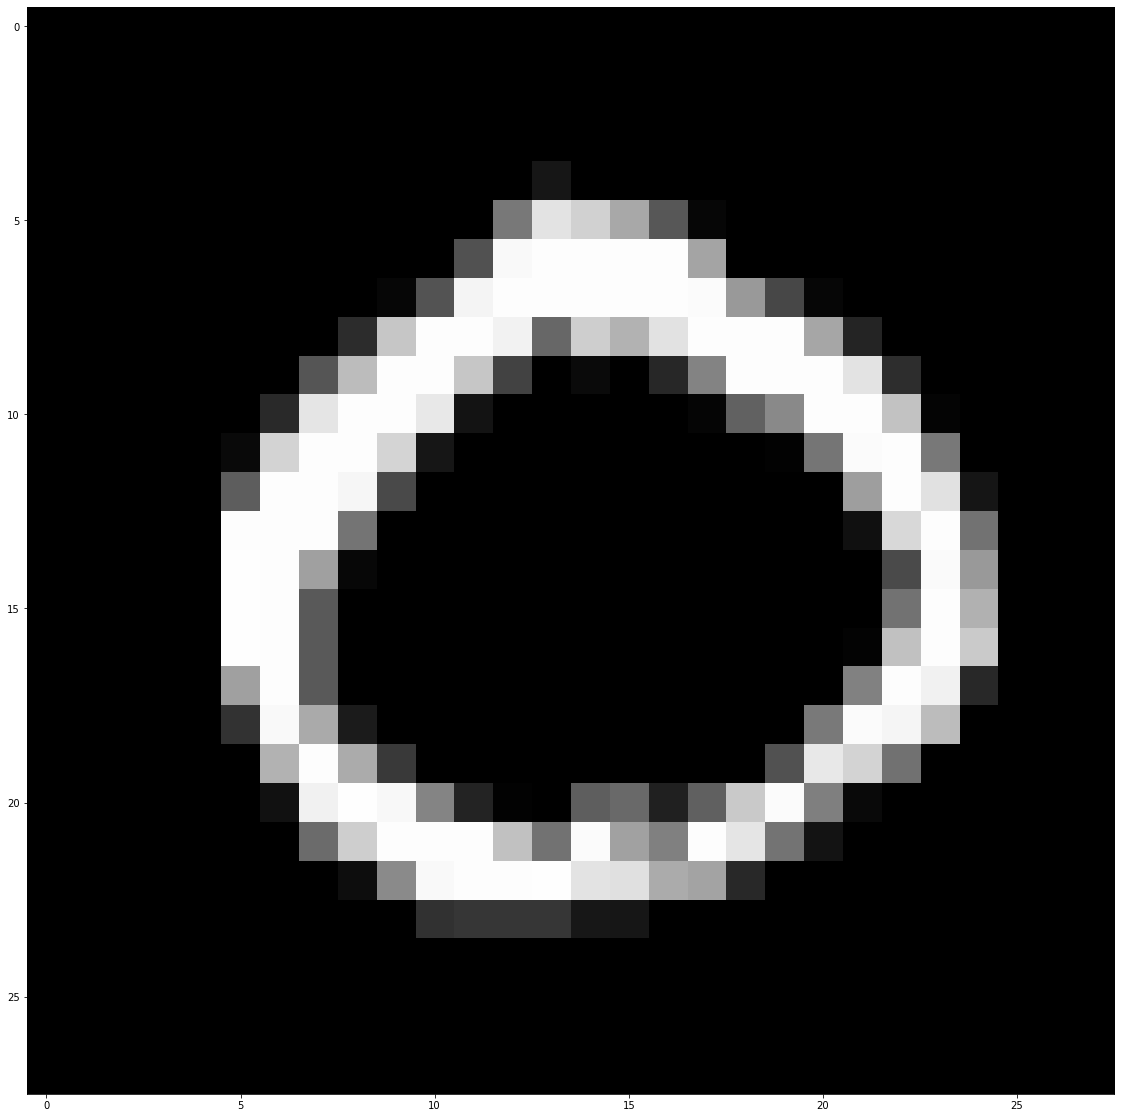

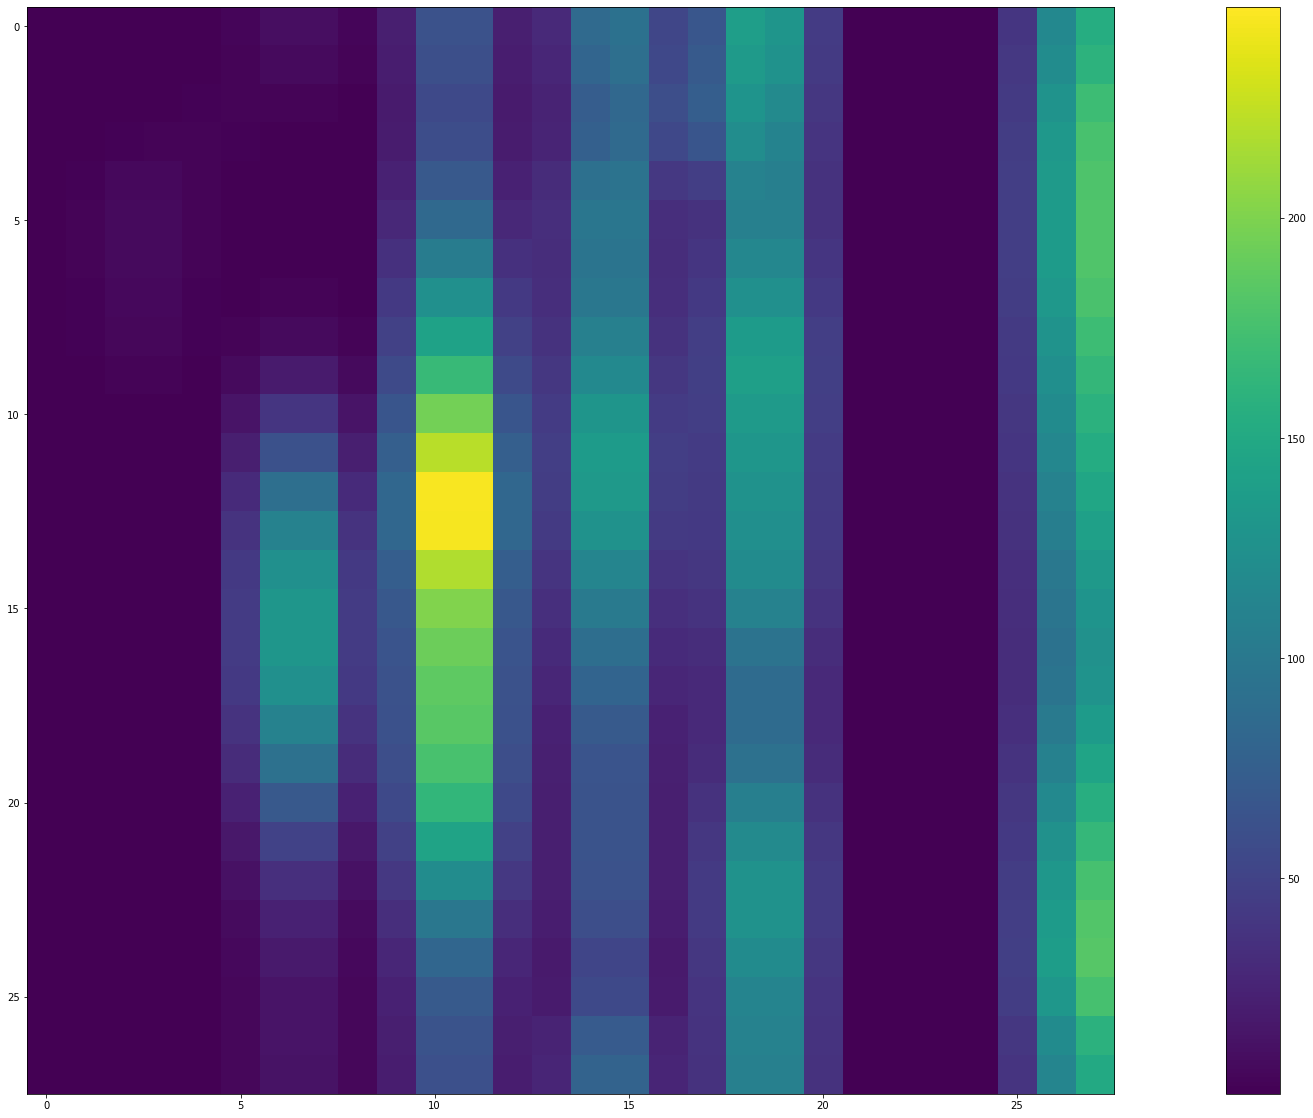

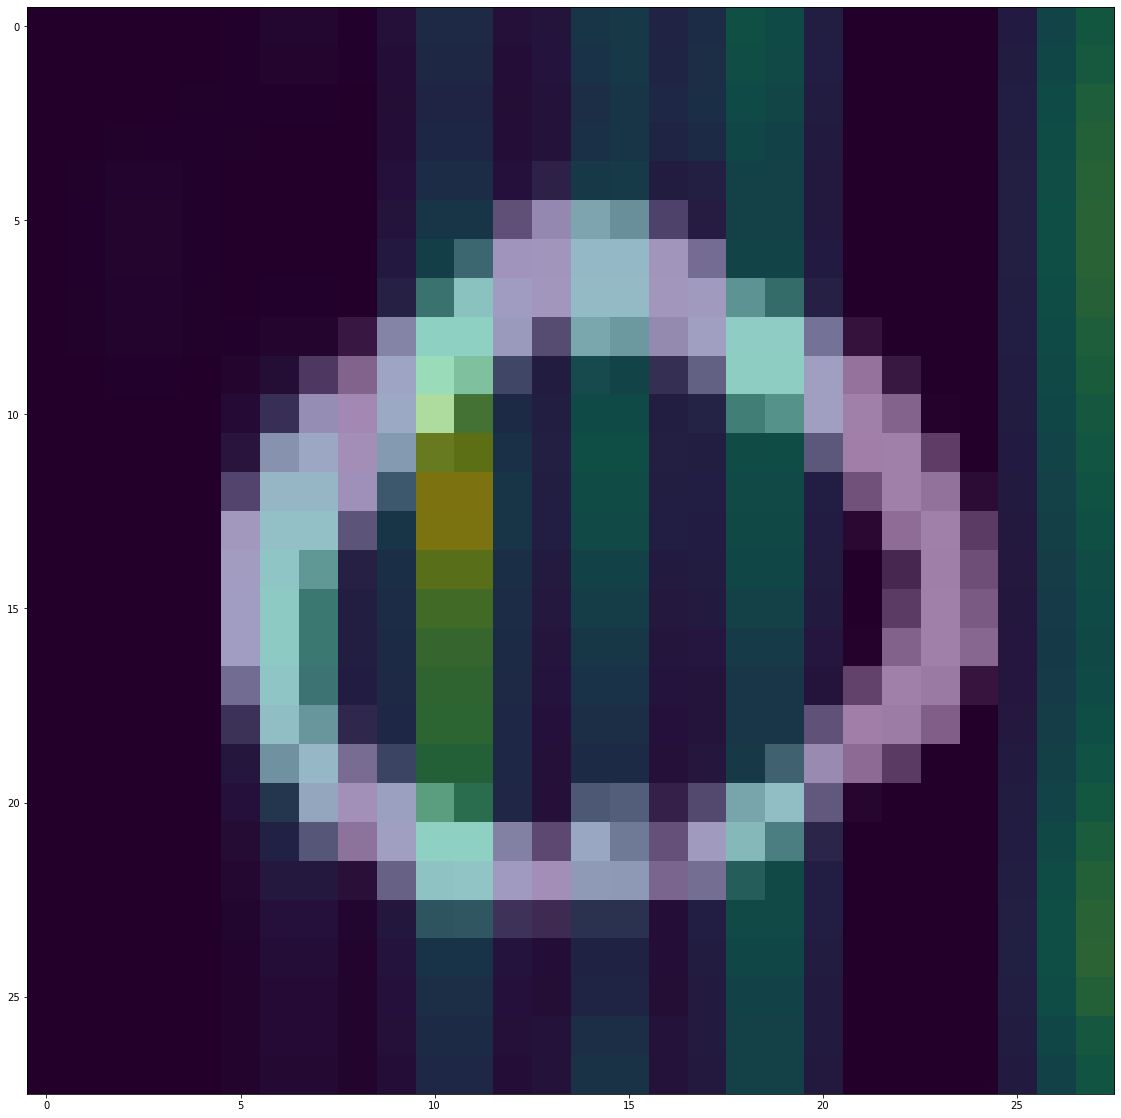

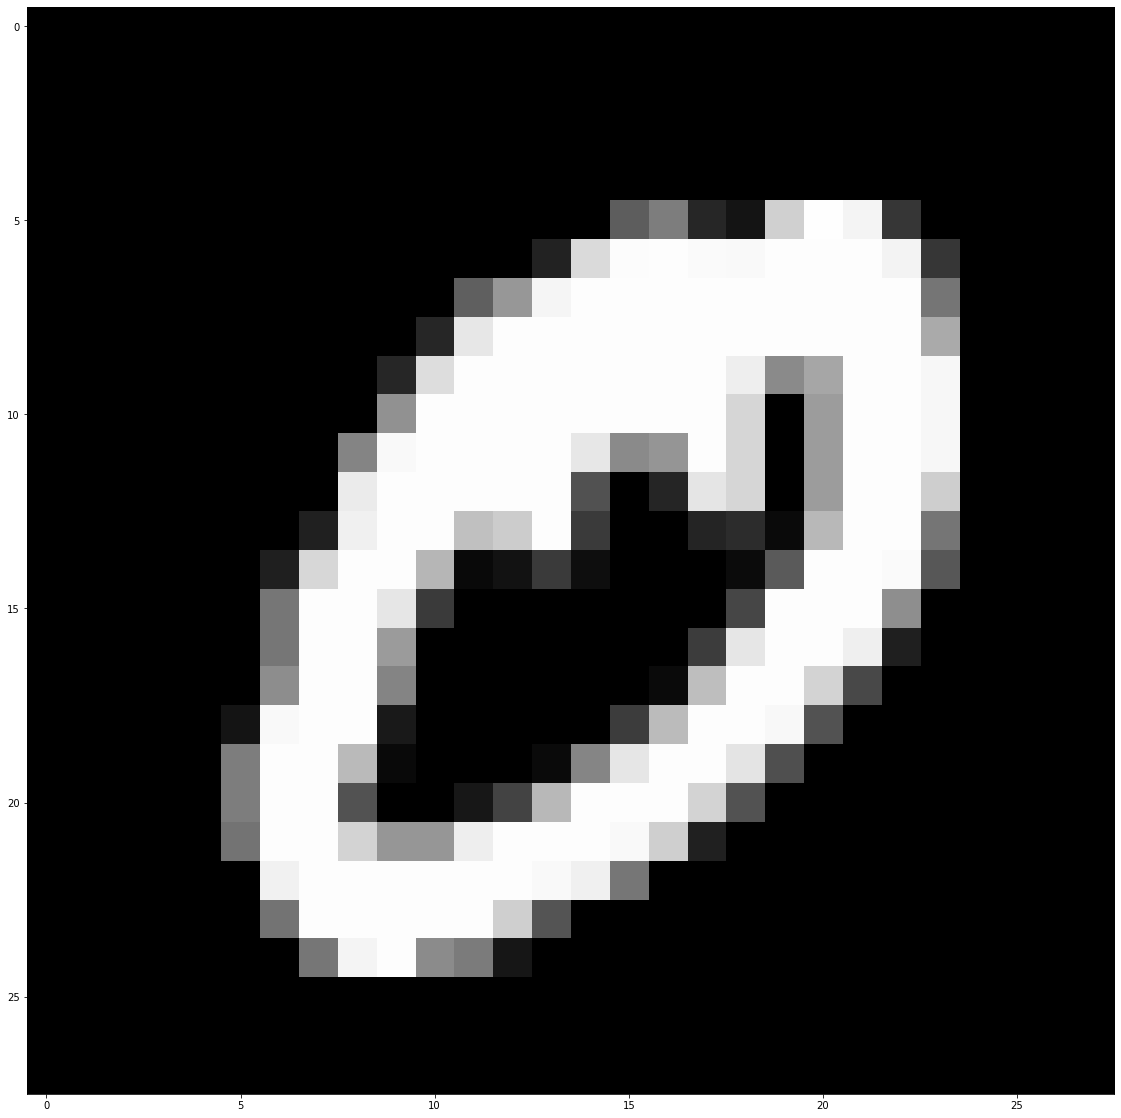

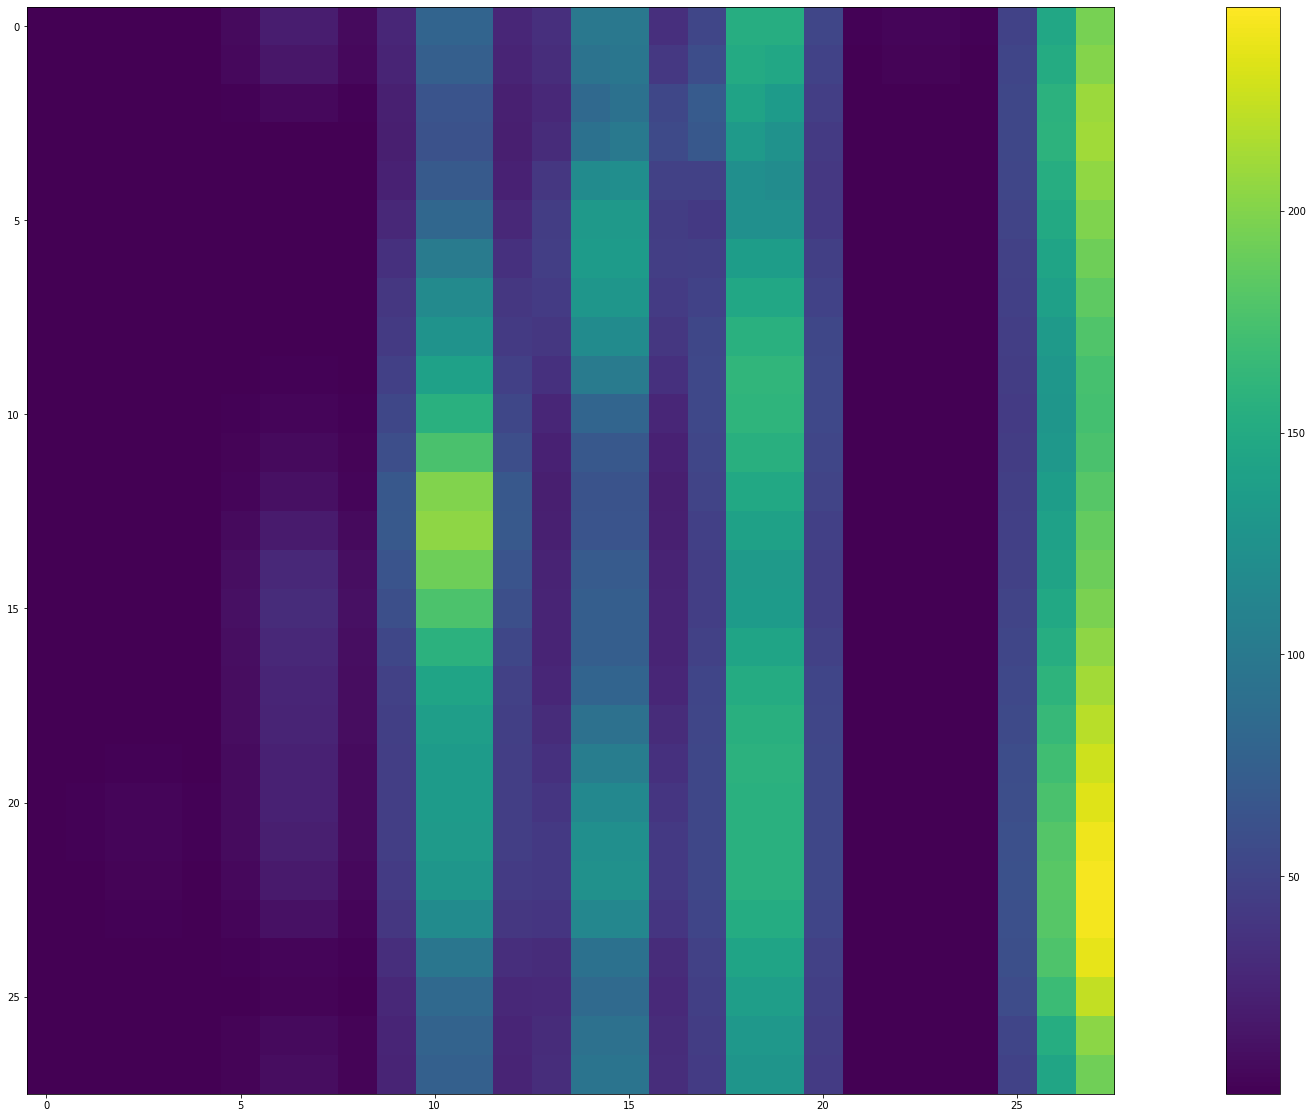

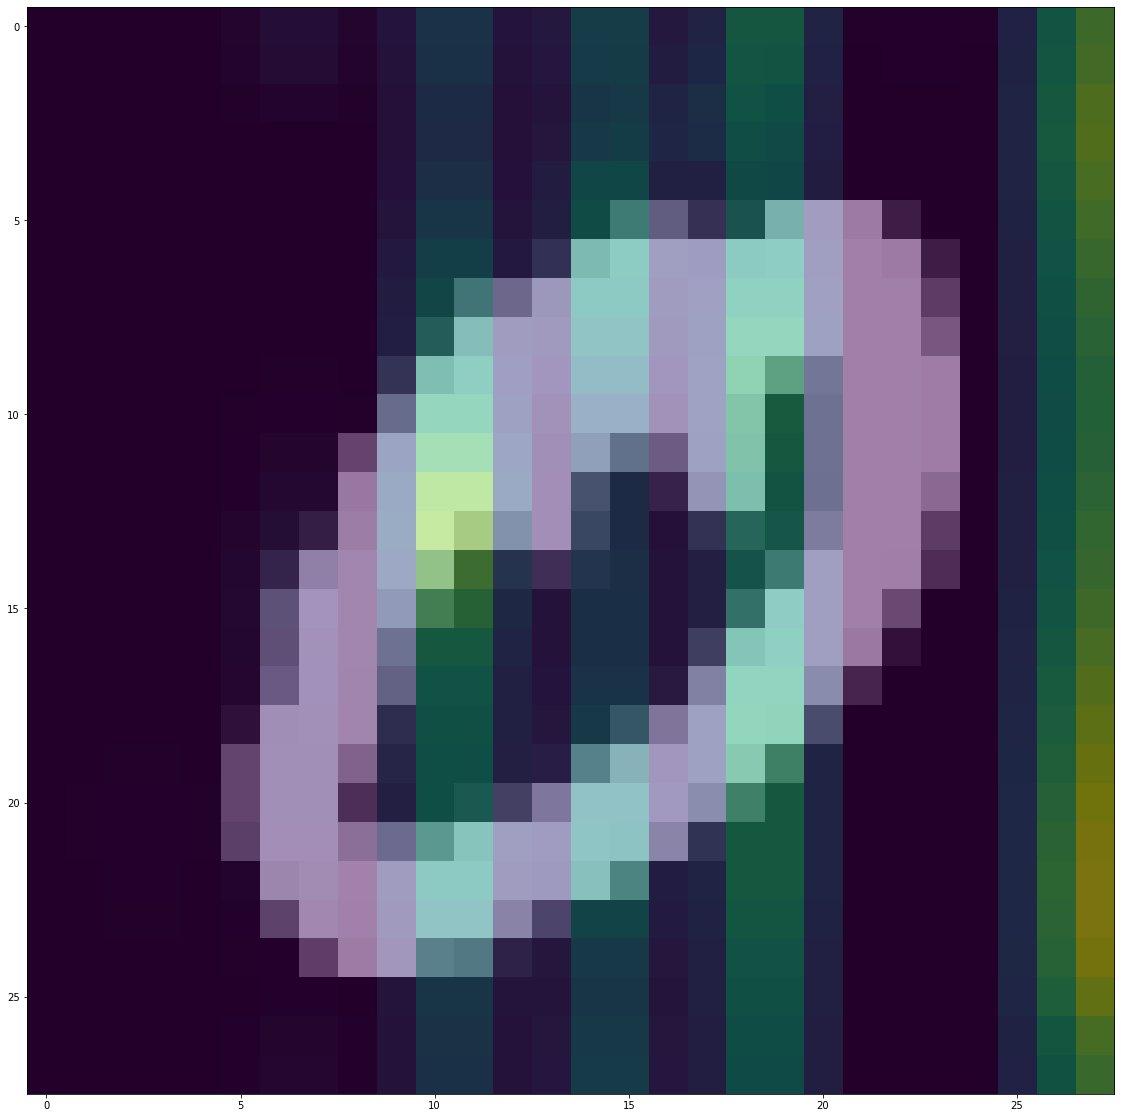

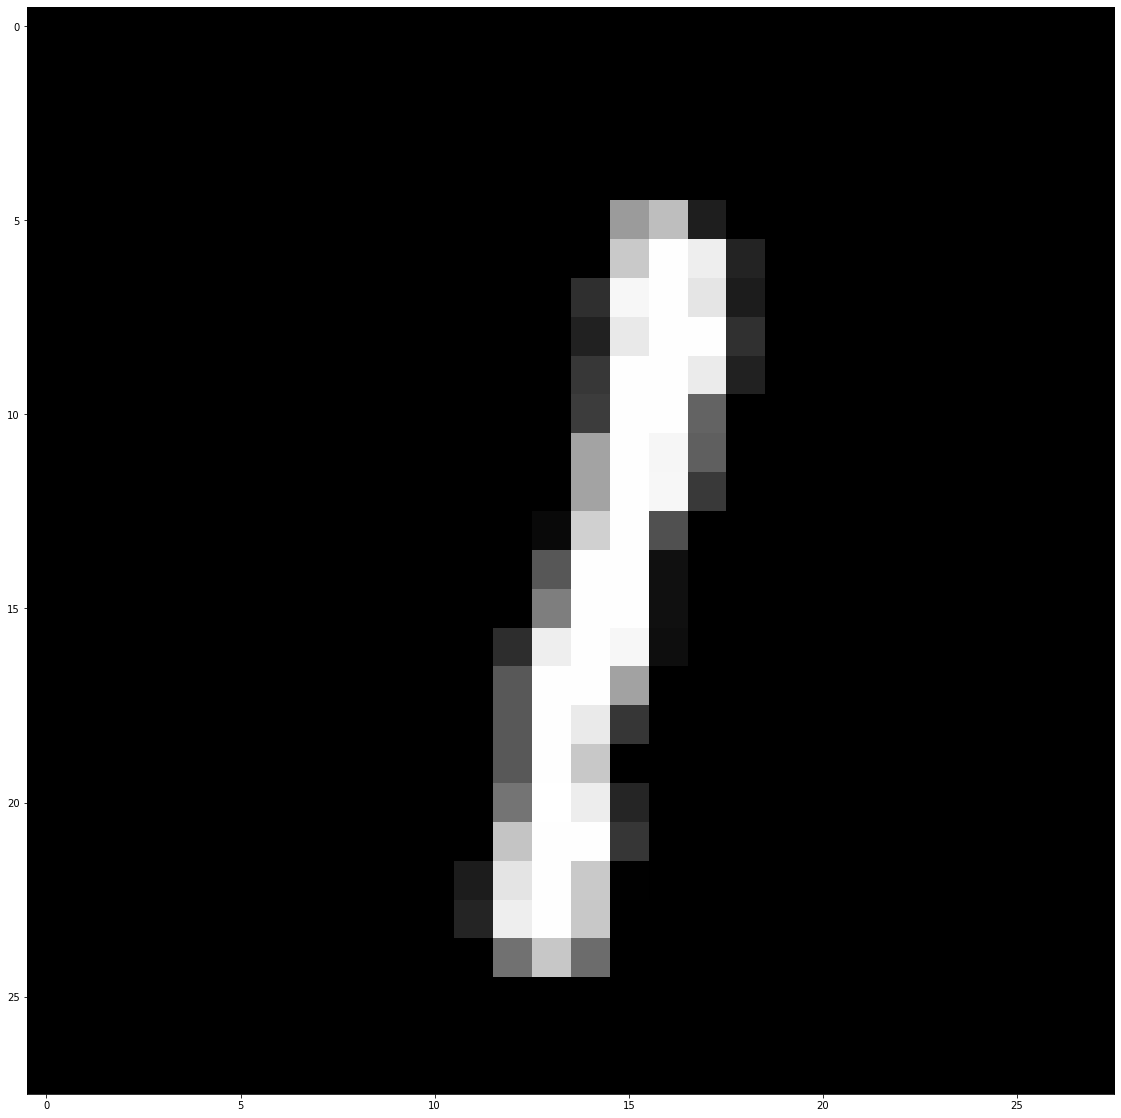

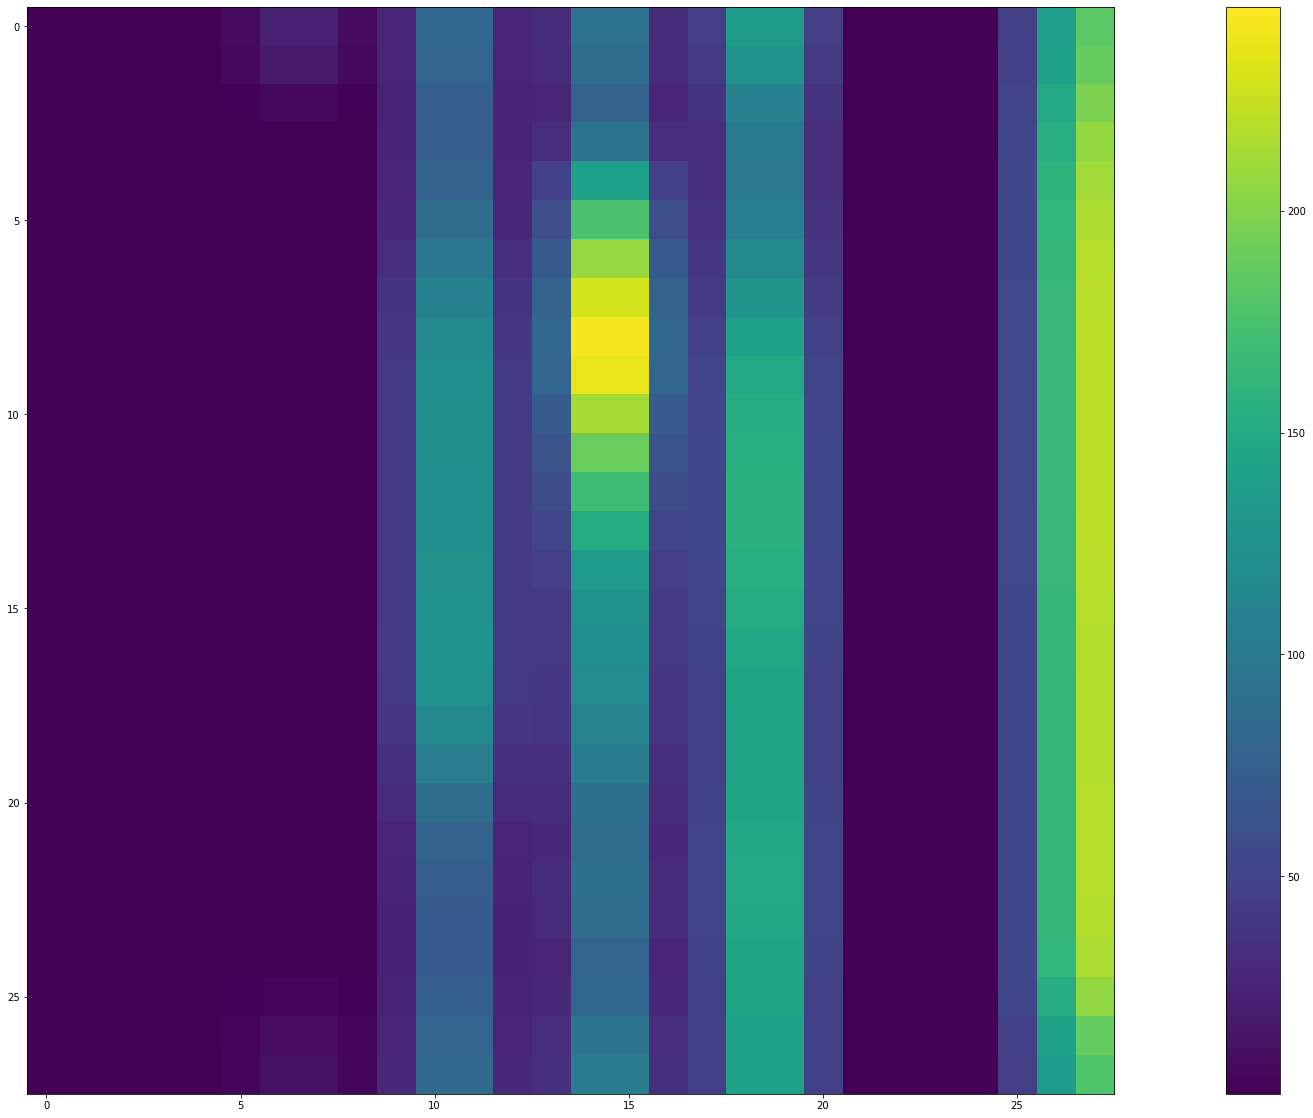

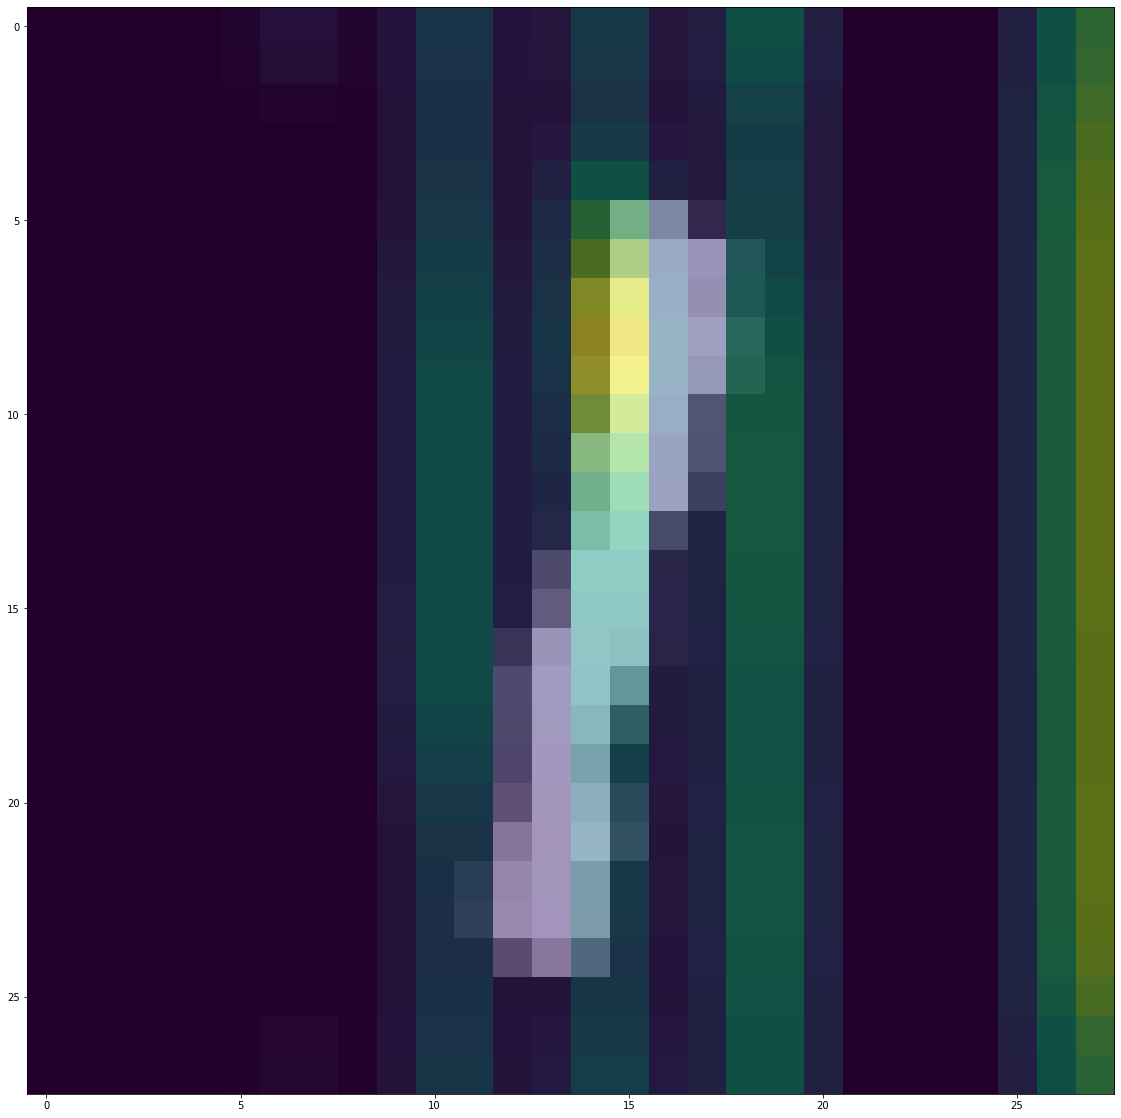

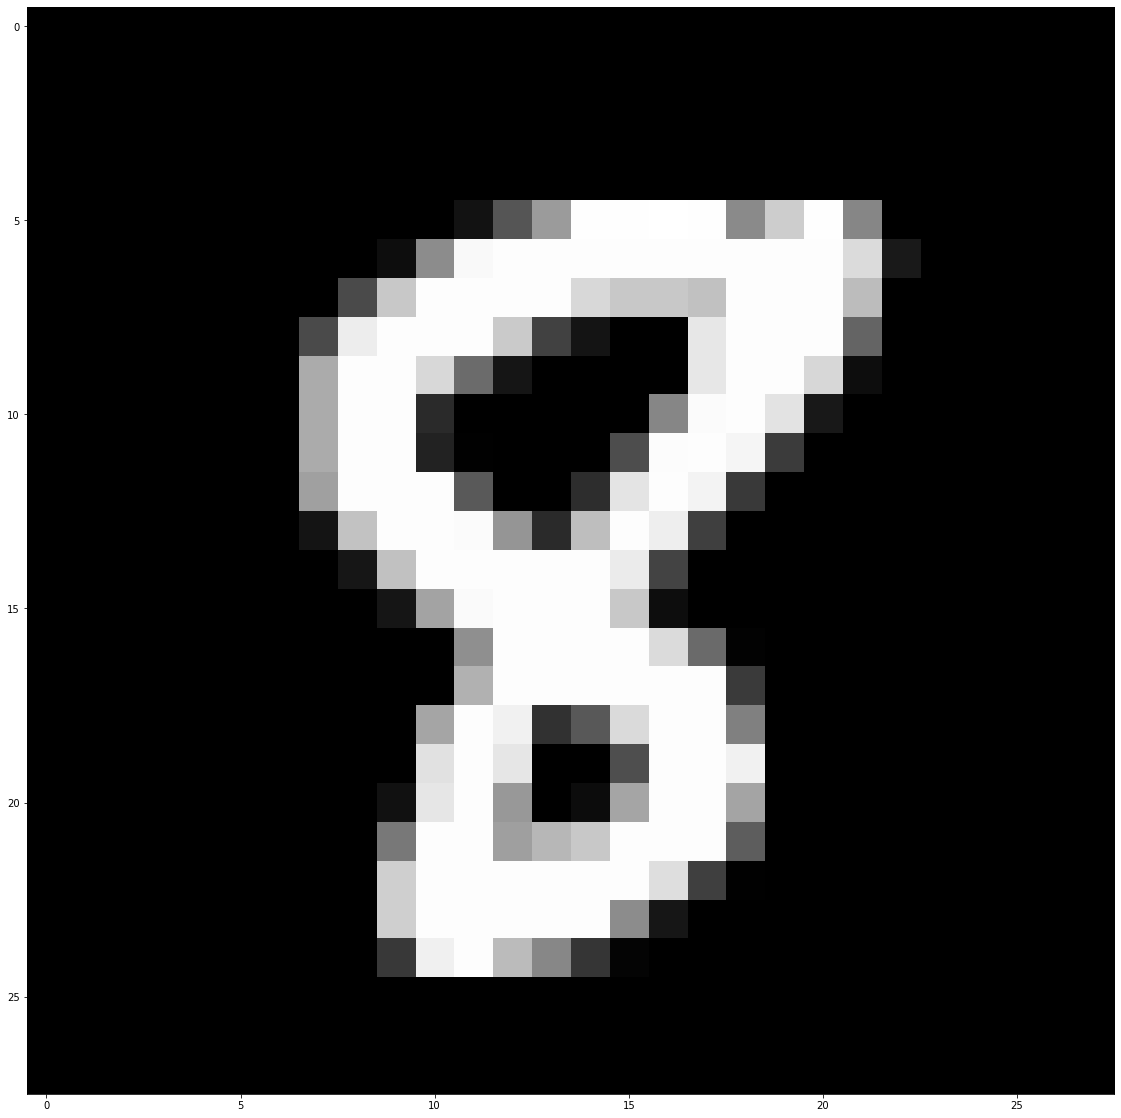

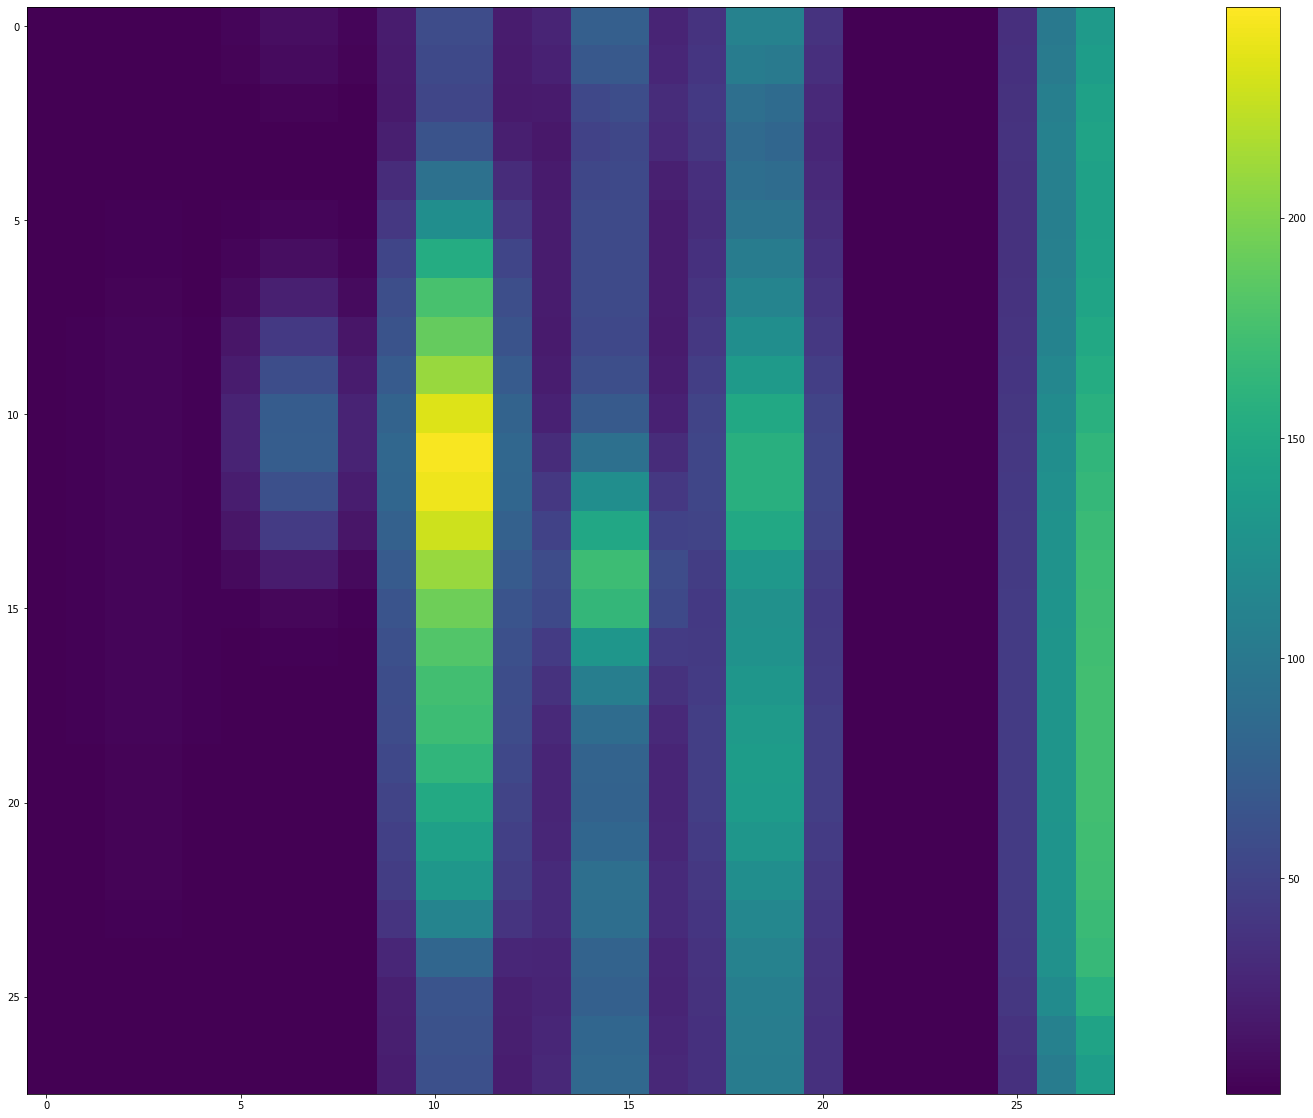

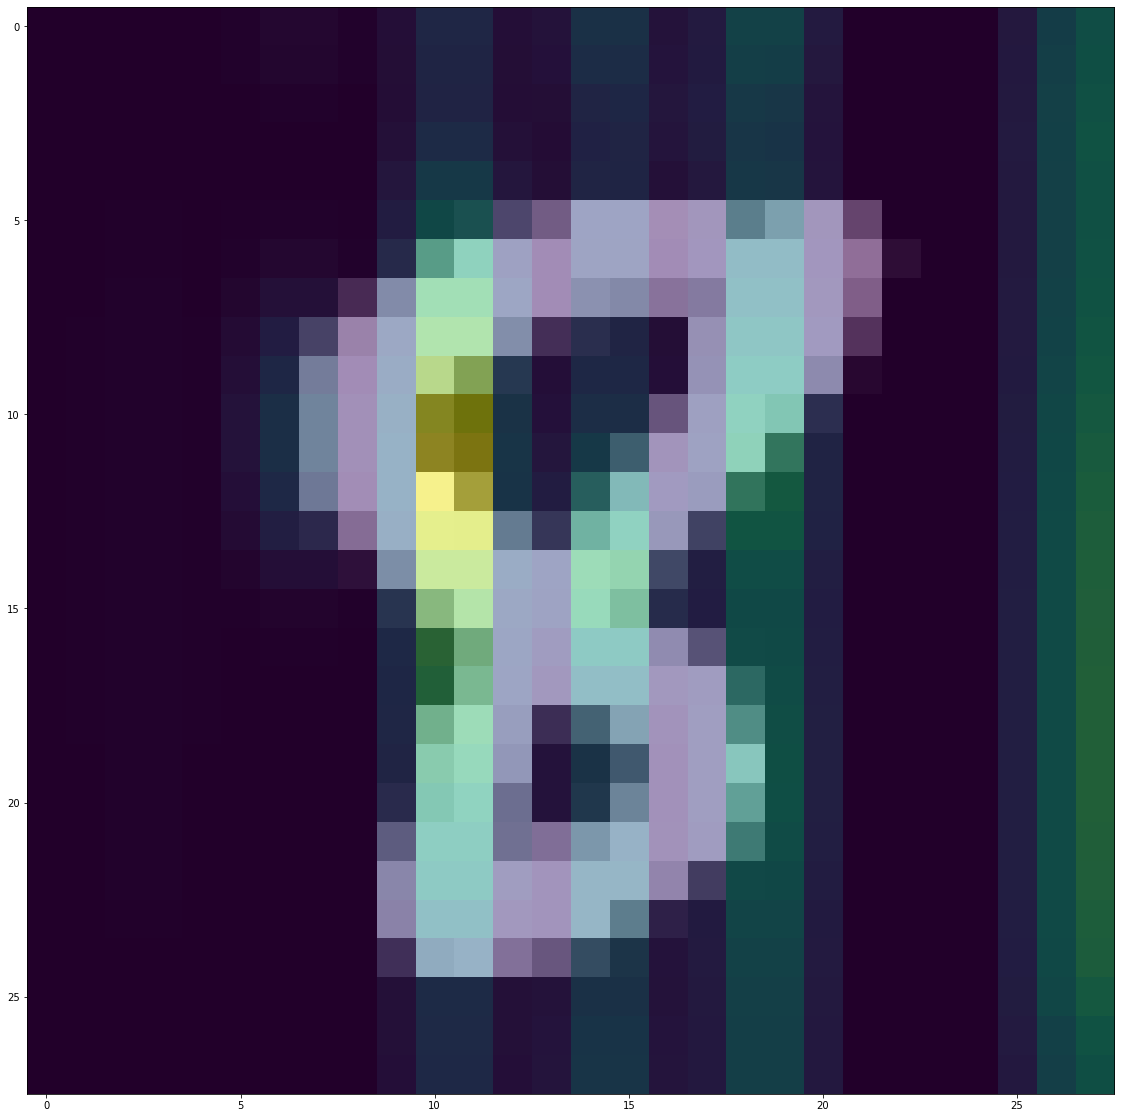

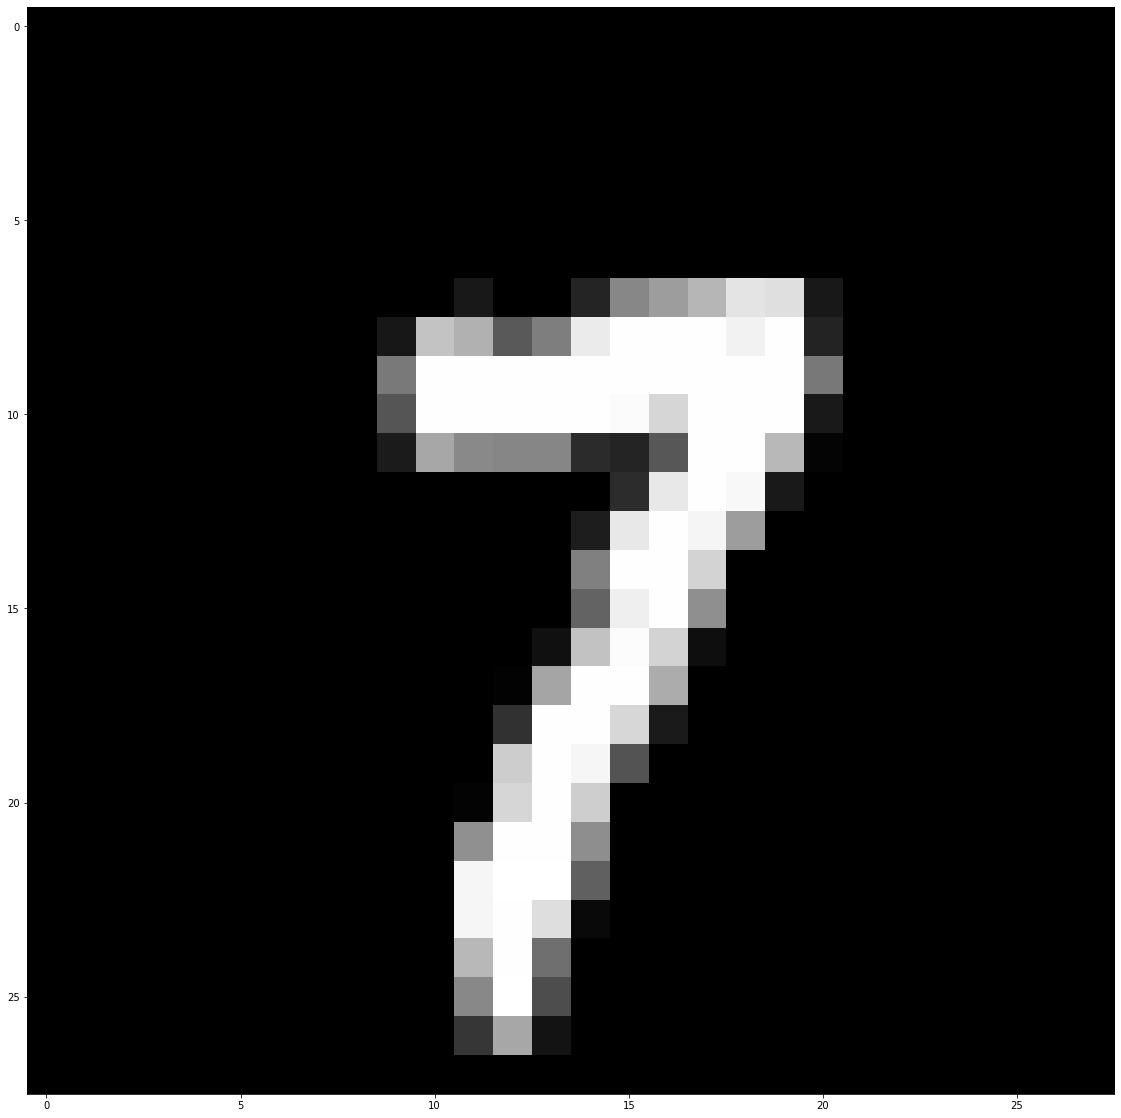

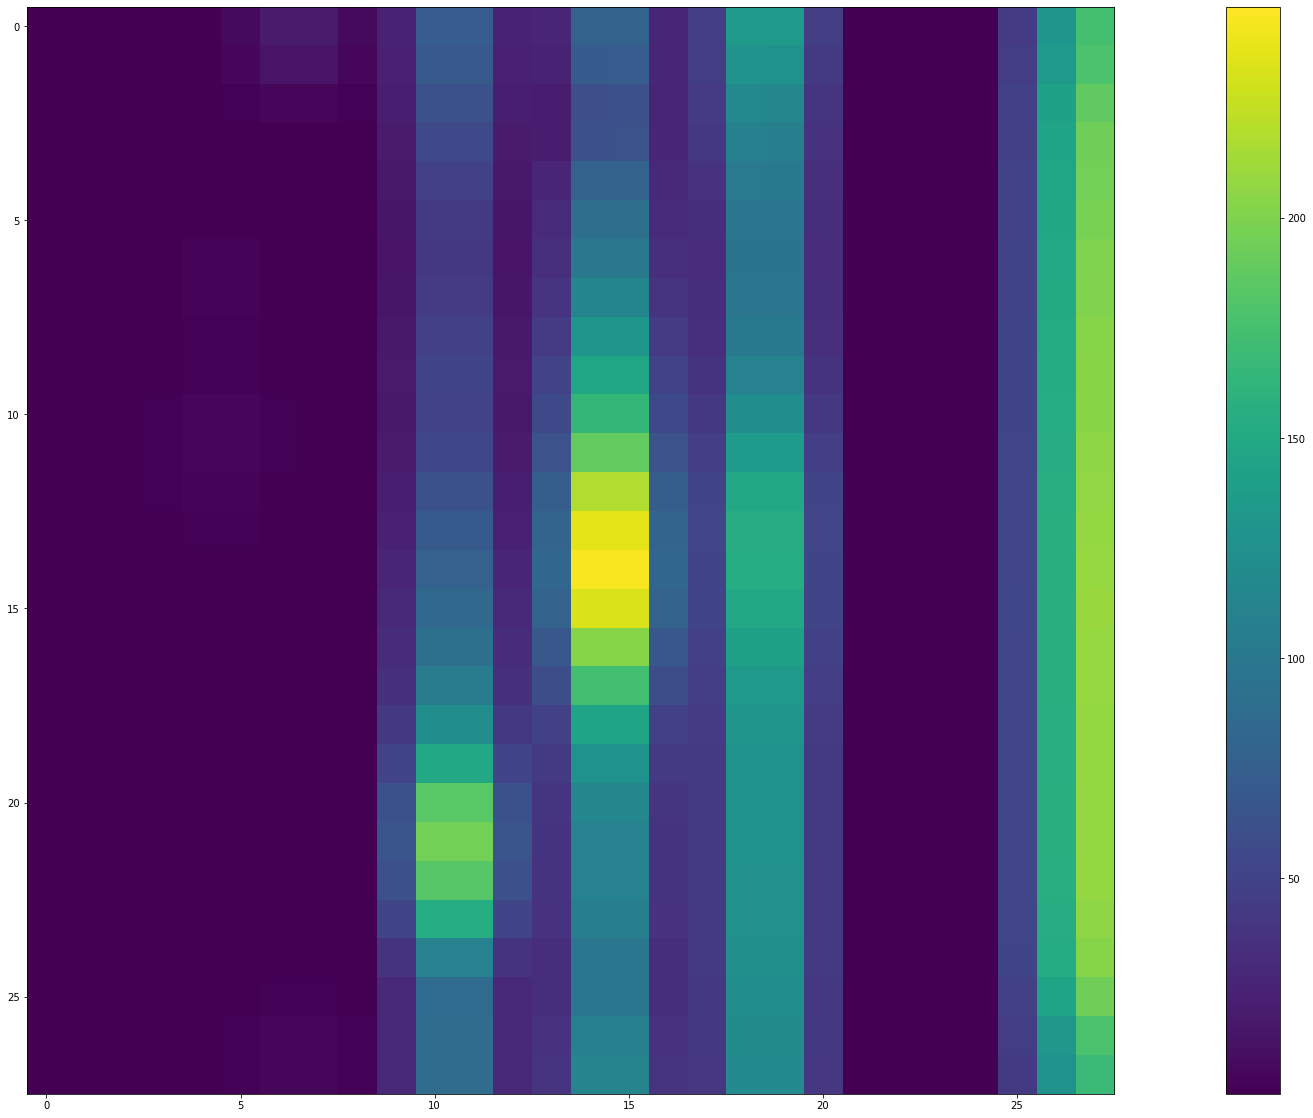

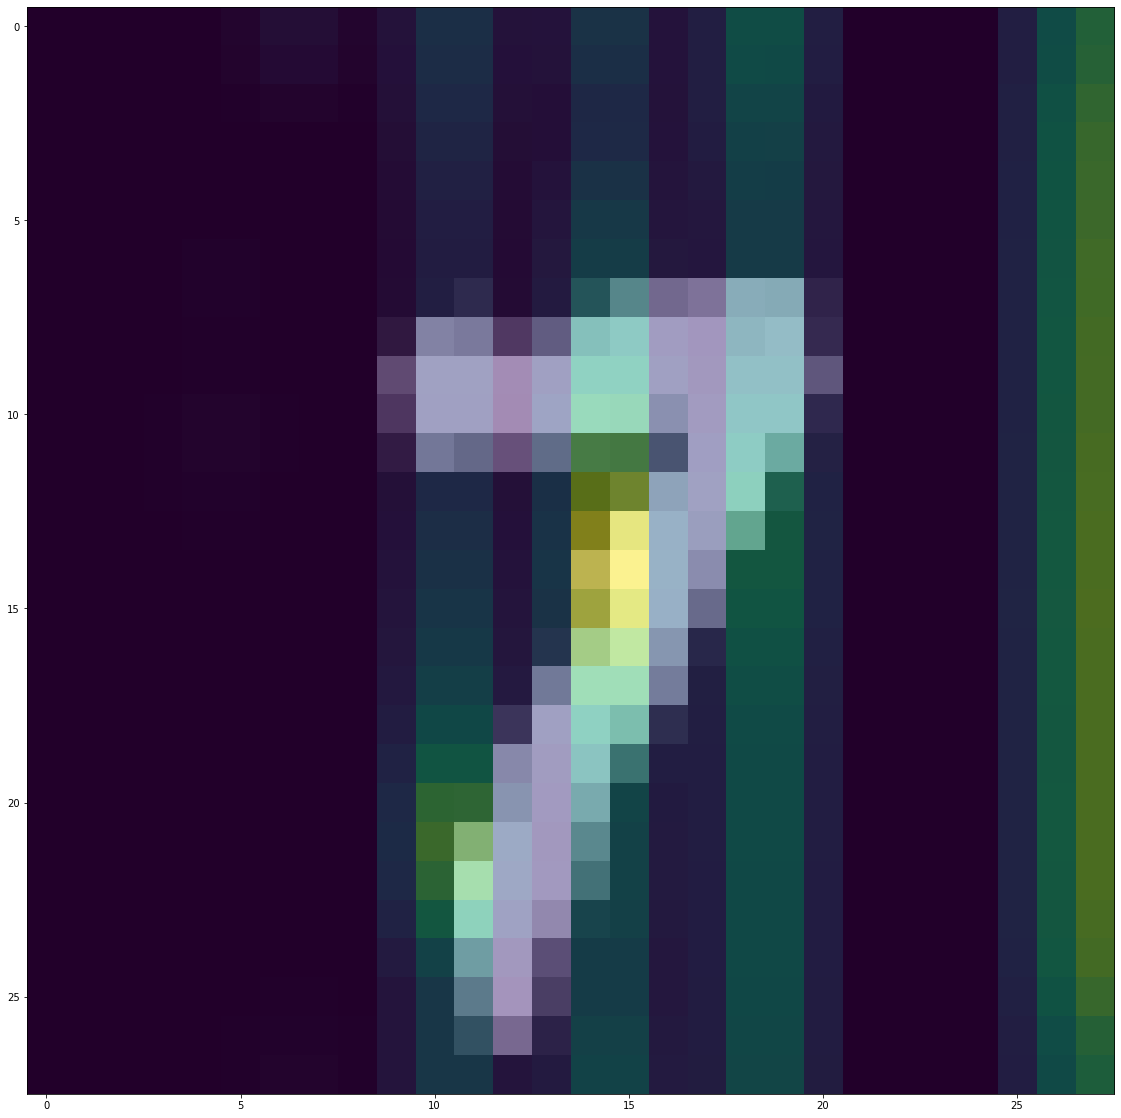

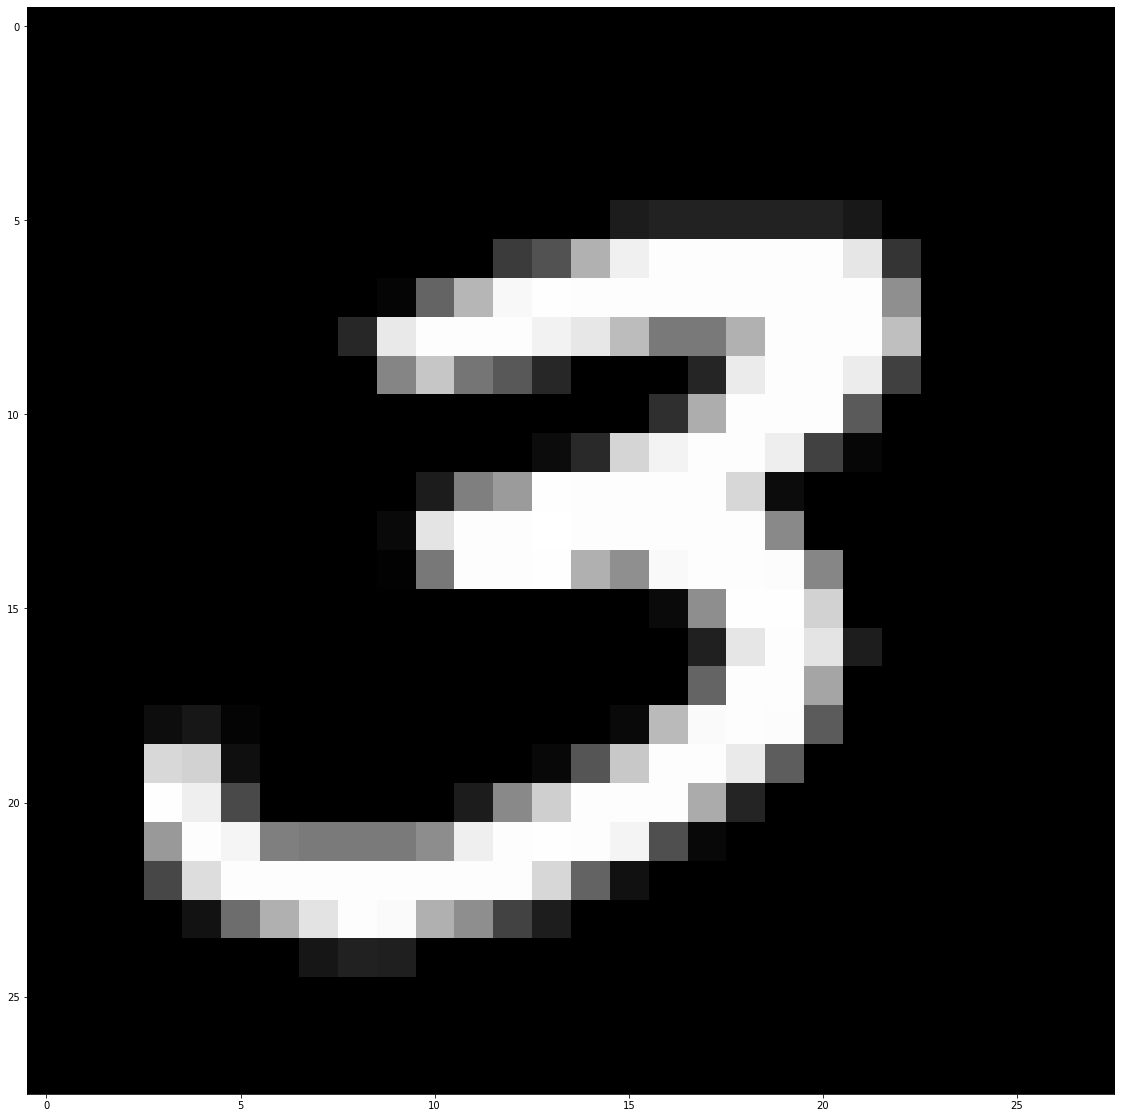

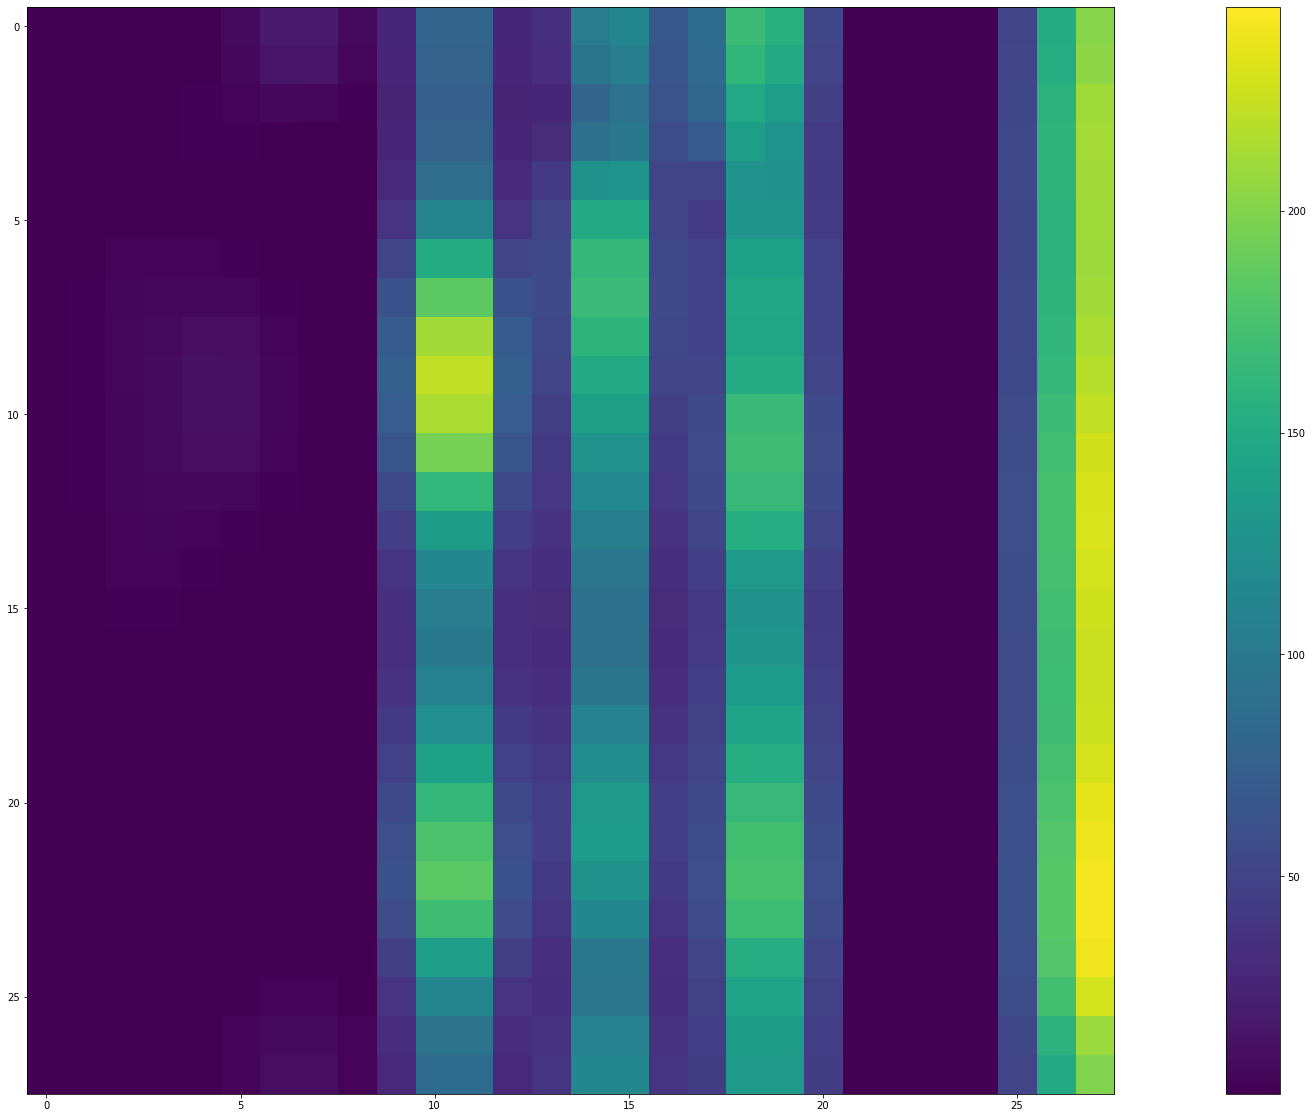

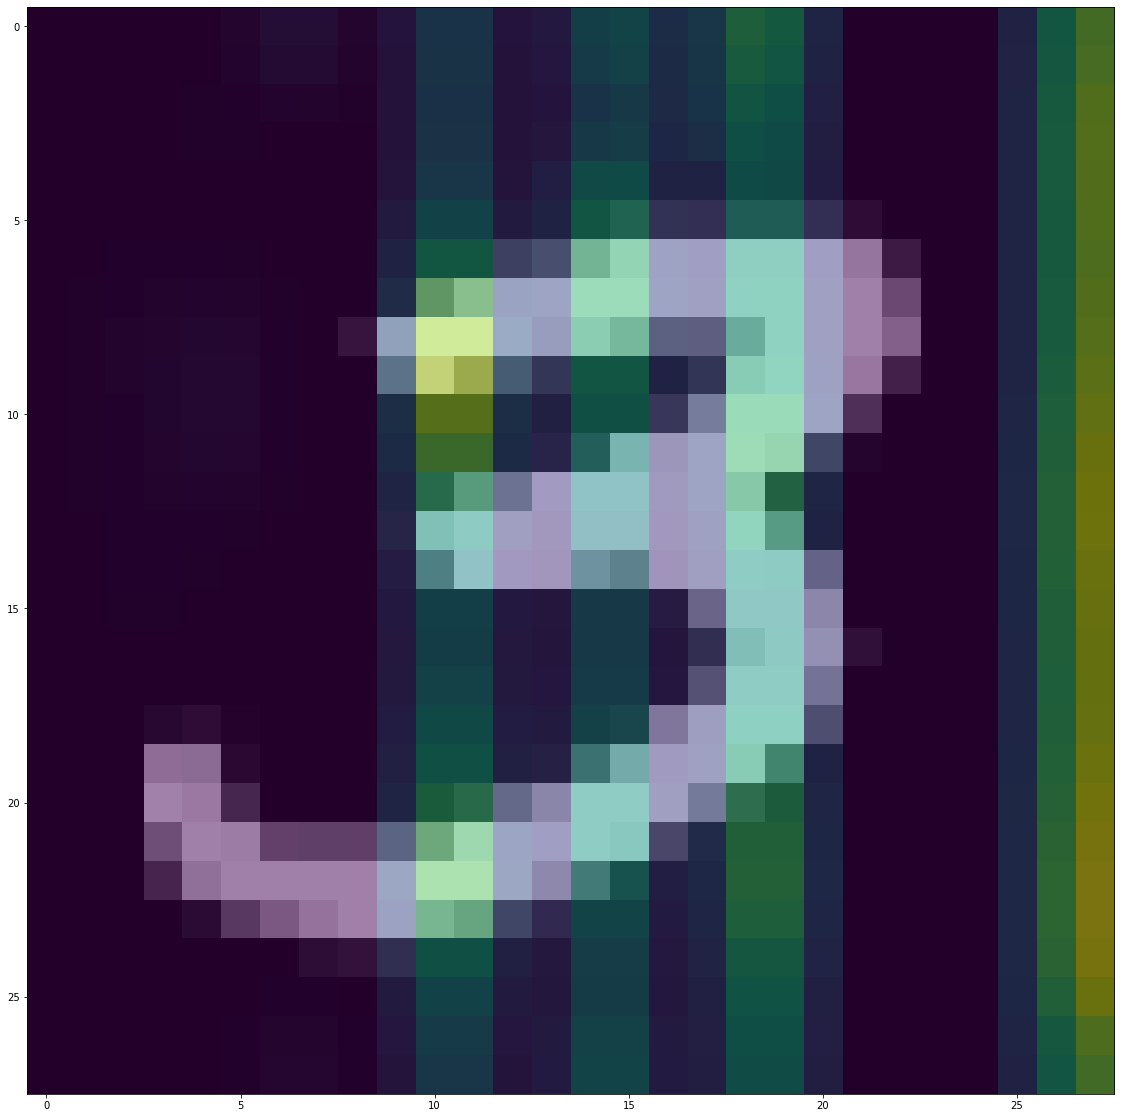

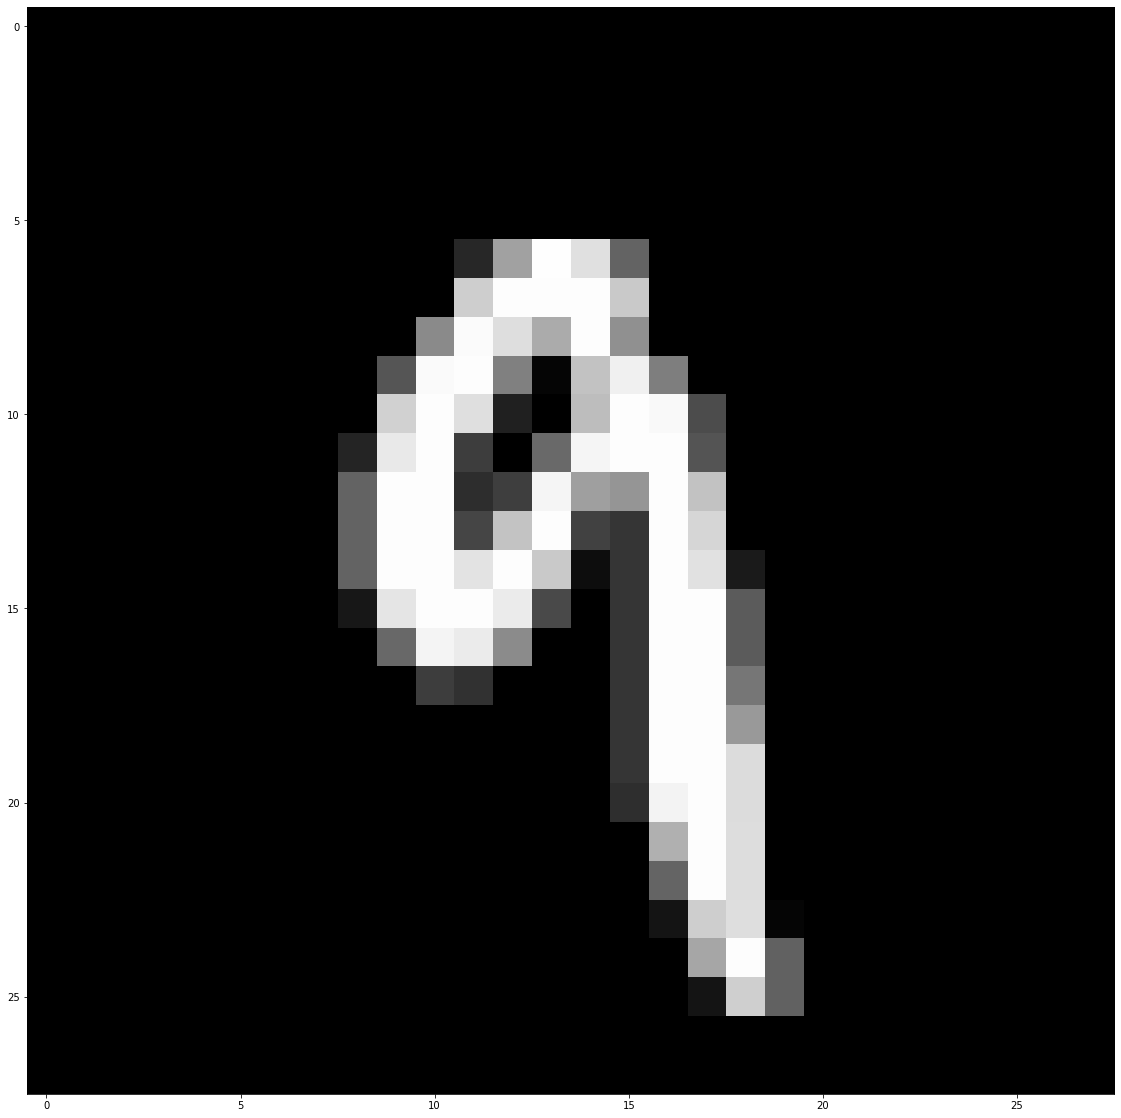

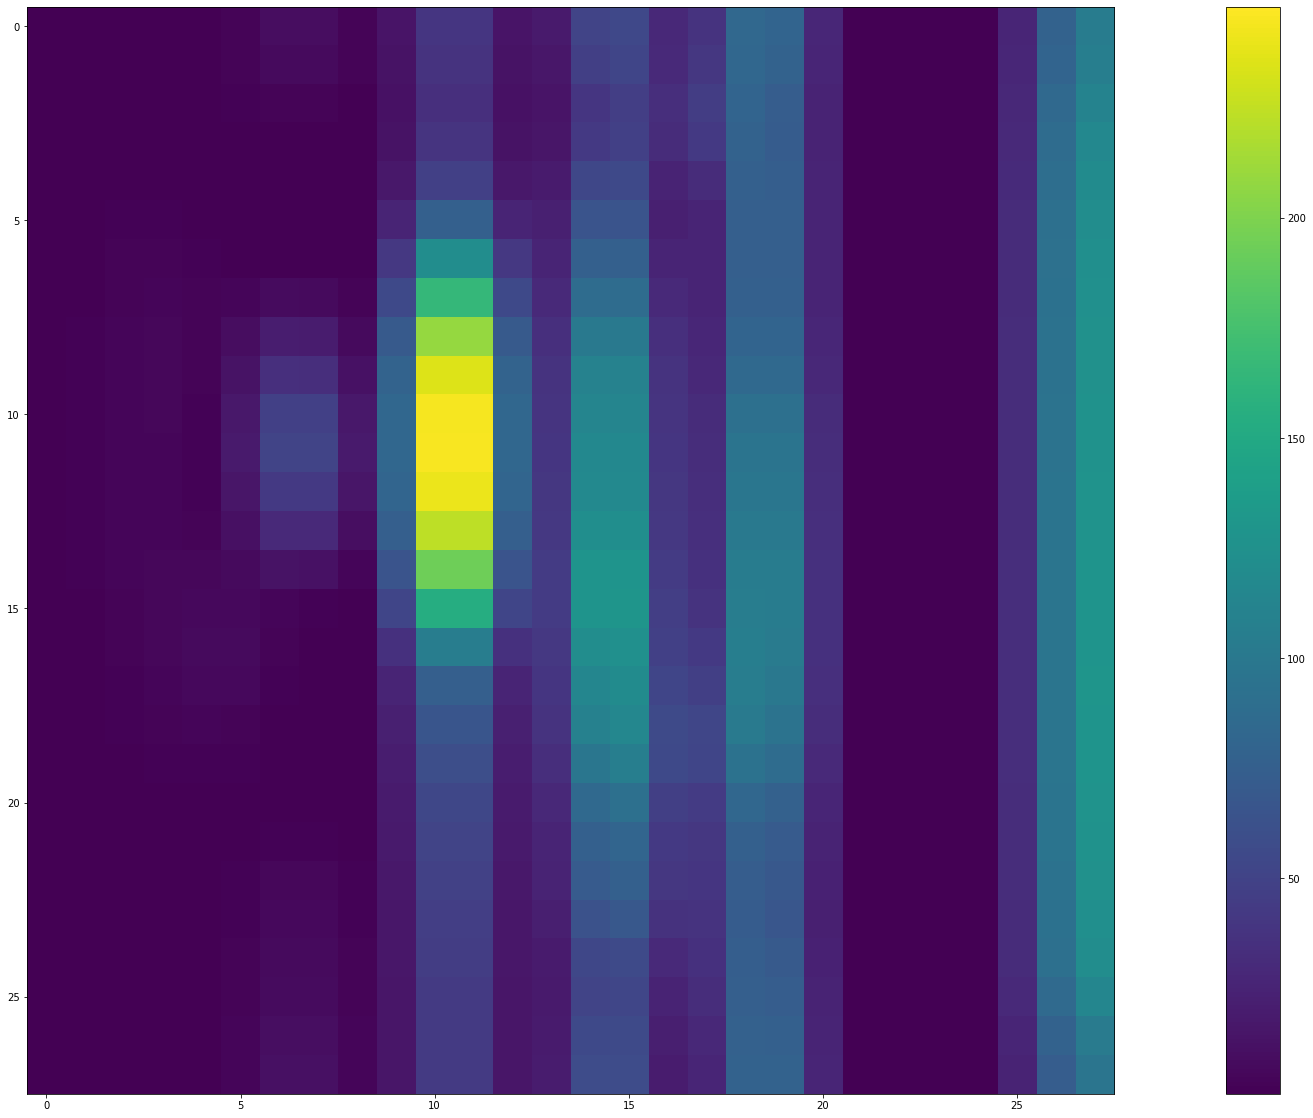

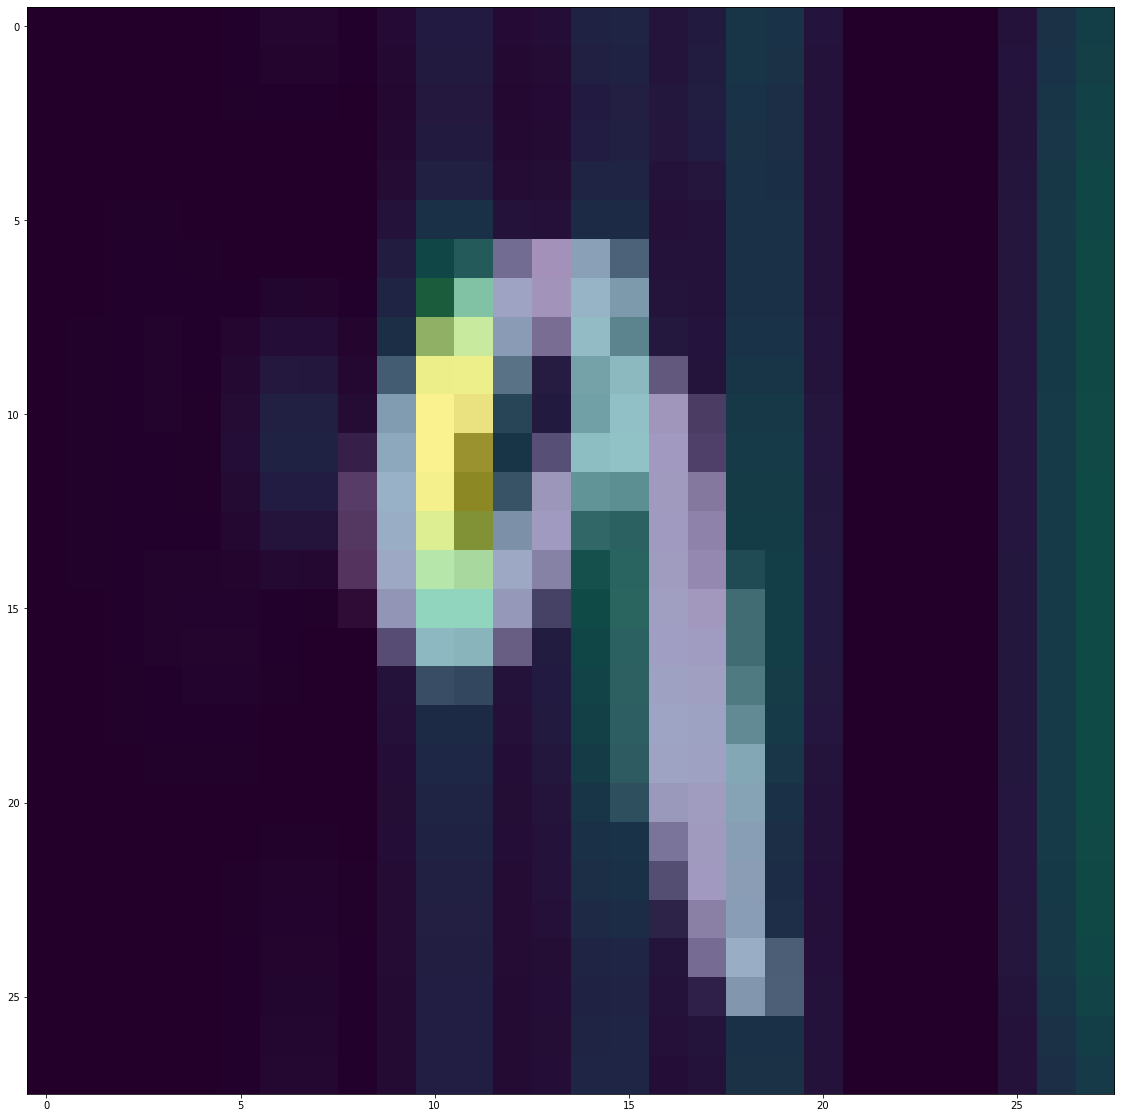

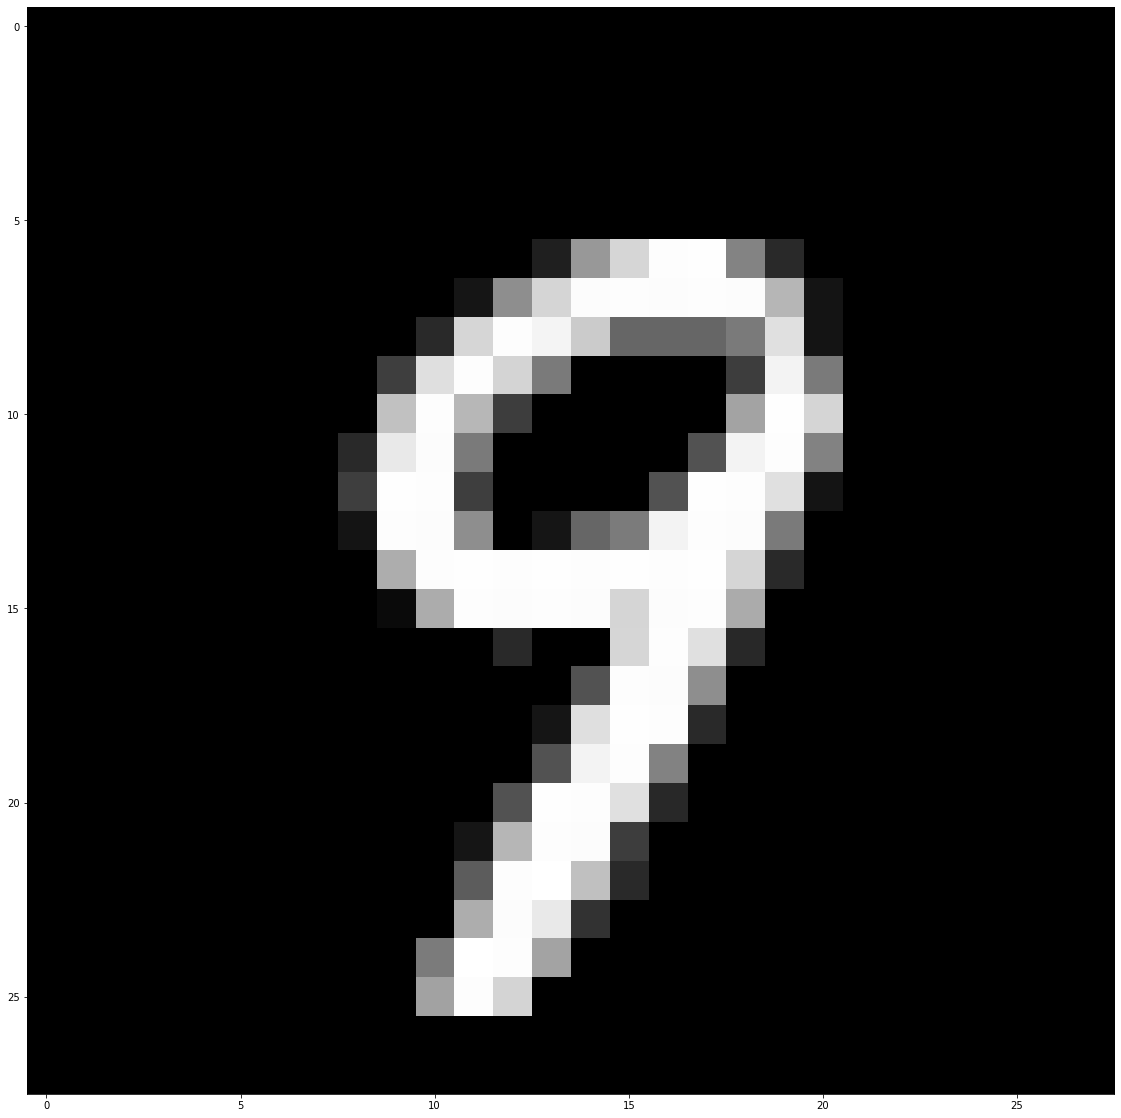

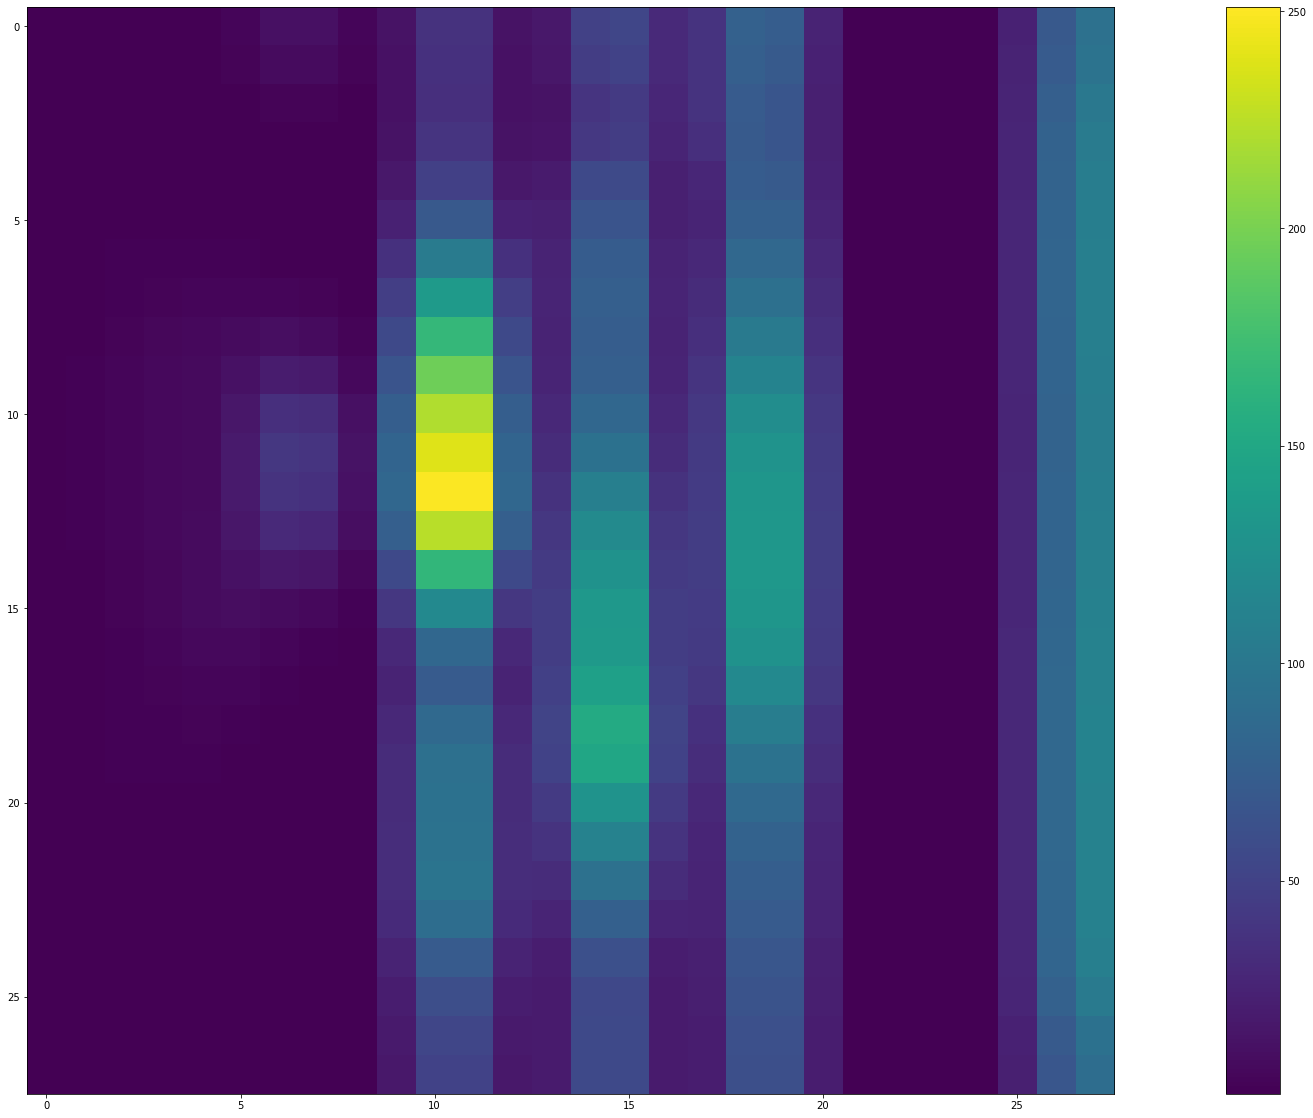

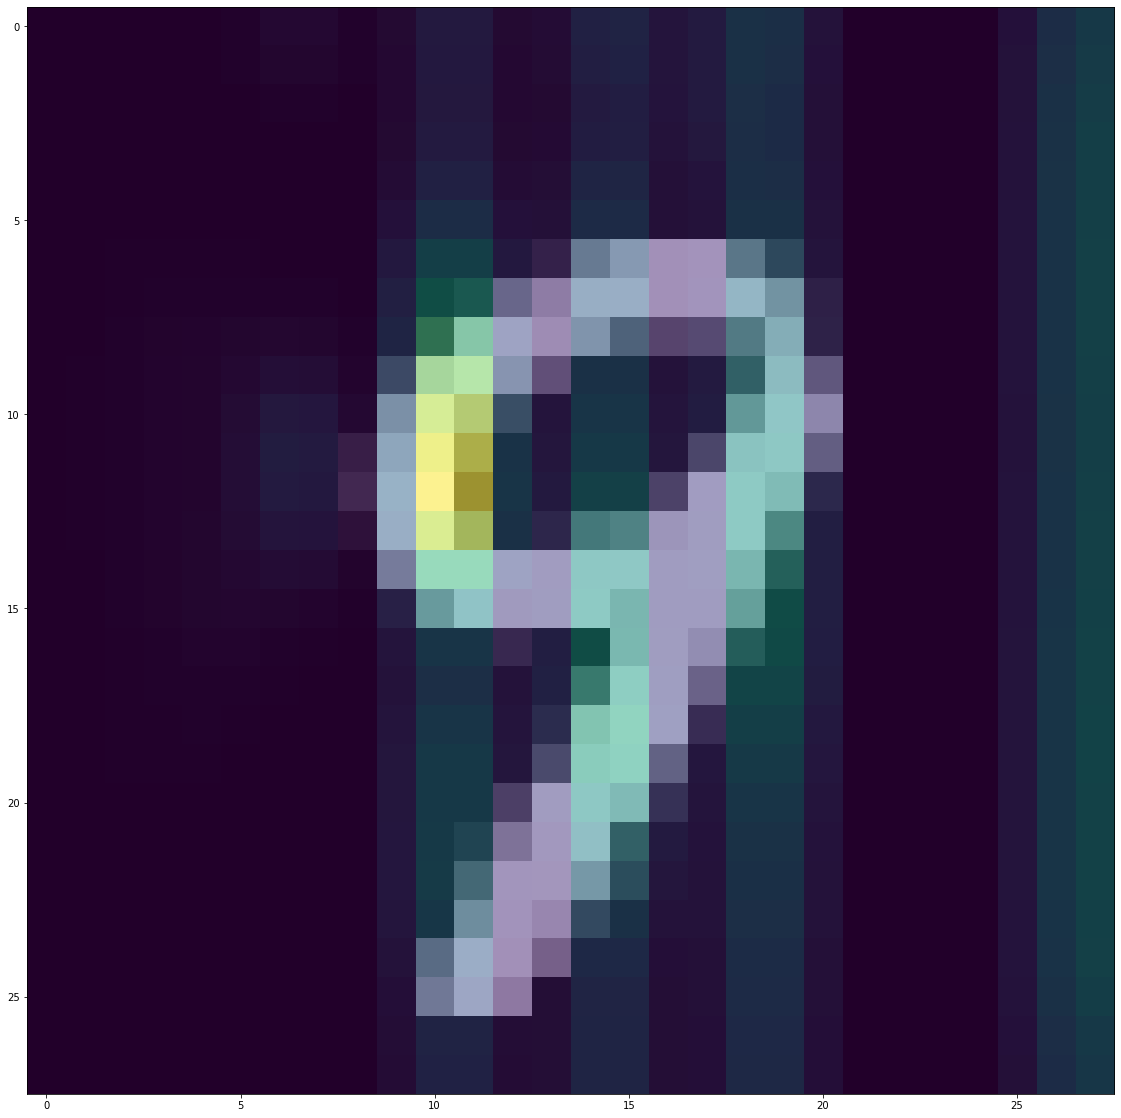

In [45]:

import imutils

model = model

image = x_test[20,:,:,:]
image = np.expand_dims(image,axis=0)


preds = model.predict(image)
i = np.argmax(preds[0])
cam = GradCAM(model, i)


heatmap_seq = cam.compute_heatmap(image)

image = np.concatenate([image,image,image],axis=-1)
print(np.max(heatmap_seq))

(heatmap_seq, output_seq) = cam.overlay_heatmap(heatmap_seq, image, alpha=0.5)


num_sequence = 10;

for seq in range(num_sequence):
    orig = image[0,seq,...];
    heatmap = heatmap_seq[seq,...];
    output = output_seq[seq,...];
    heatmap = (heatmap ).astype("uint8")
    orig = (orig * 255).astype("uint8")
    output = (output ).astype("uint8")
    
    
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(40,20))
    plt.imshow(orig)
    plt.figure(figsize=(40,20))
    plt.imshow(heatmap)
    plt.colorbar()
    plt.figure(figsize=(40,20))
    plt.imshow(output)
